### CASA eMERLIN Tutorial Jupyter Notebook 

This notebook uses the Jupyter kernel for CASA built by Aard Keimpema from the Joint Institute of VLBI ERIC (JIVE). Instructions for downloading and running the Docker container for the CASA Jupyter Notebook can be found at https://github.com/aardk/jupyter-casa

This project uses the the temporary notebook service, tmpnb (https://github.com/jupyter/tmpnb) to launch "temporary" Jupyter notebook servers.

The notebook used in this tutorial makes extensive use of Anita Richards calibration tutorial for ERIS 2017 (http://www.astron.nl/eris2017/lectures.php) 

In [1]:
import os

In [2]:
casa['build']['version']

'4.7.0'

In [3]:
multi_source = 'all_avg.ms'

In [4]:
listobs(vis=multi_source) 

           MeasurementSet Name:  /home/jupyter/all_avg.ms      MS Version 2
   Observer: Teaching Data Set     Project: Teaching  
Observation: e-MERLIN

  Telescope Observation Date    Observer       Project        
  e-MERLIN  [                   4.93757e+09, 4.93761e+09]Teaching Data SetTeaching       
  e-MERLIN  [                   4.93757e+09, 4.93761e+09]Teaching Data SetTeaching       
  e-MERLIN  [                   4.93758e+09, 4.93758e+09]Calibrators    Calibrat       
  e-MERLIN  [                   4.93758e+09, 4.93759e+09]Calibrators    Calibrat       
  e-MERLIN  [                   4.93761e+09, 4.93762e+09]Calibrators    Calibrat       
Data records: 747300       Total elapsed time = 50270 seconds
   Observed from   05-May-2015/18:32:09.5   to   06-May-2015/08:29:59.5 (UTC)

   ObservationID = 0         ArrayID = 0
  Date        Timerange (UTC)          Scan  FldId FieldName             nRows     SpwIds   Average Interval(s)    ScanIntent
  05-May-2015/18:32:09.5 - 18:3

True

Show log 2018-01-23 09:56:49	INFO	listobs::ms::summary	Writing output to file: casapy_temp.txt
 2018-01-23 09:56:49	INFO	listobs::MSMetaData::_computeScanAndSubScanProperties Computing scan and subscan properties...

From the listobs output we can see that there are 5 fields in the MS file, all_avg.ms. These are:

e-MERLIN name|Common name|Role
---------|-----|-----------|----------
1252+5634|3C277.1|target
1302+5748|J1302+5748|phase reference source
1407+284|OQ208|bandpass cal.
0319+415|3C84|bandpass, polarization leakage cal.
1331+305|3C286|flux, polarization angle cal.

**define variable names for the different fields**

In [5]:
target = '1252+5634' # 3C277.1
phref  = '1302+5748'  # J1302+5748
bpcal  = '0319+415' # 3C84 - brightest source
bpcal2 = '1407+284'
bpcals  = '0319+415,1407+284' # If using more than one e.g. 3C84, OQ208/1407+284
leakcal = '0319+415'  # 3C84 - if not observed, use BP cal
fluxcal = '1331+305'  # 3C286, also pol angle cal.

In [6]:
bases=['0319+415','1252+5634','1302+5748','1331+305','1407+284']
cals=['0319+415','1302+5748','1331+305','1407+284']
calsources='{},{},{},{}'.format(phref,bpcal,bpcal2,fluxcal)  # list of unique cal sources

In [7]:
antref = 'Mk2'        # Reference antenna
eMfactor =  0.938     # Flux scale factor if VLA values for 1331+305 are used

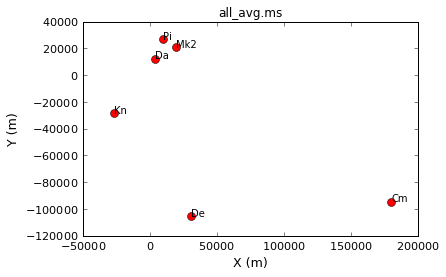

Show log 2018-01-23 09:57:00	INFO	plotants::::	Preparing data ... 
 2018-01-23 09:57:00	INFO	plotants::::	Now get the data
 2018-01-23 09:57:00	INFO	plotants::::	Done Processing data ... 
 2018-01-23 09:57:00	INFO	plotants::::	msplot clear cache: 
 2018-01-23 09:57:00	INFO	plotants::::+	/home/jupyter/all_avg.ms/STATE
 2018-01-23 09:57:00	INFO	plotants::::+	/home/jupyter/all_avg.ms/SPECTRAL_WINDOW
 2018-01-23 09:57:00	INFO	plotants::::+	/home/jupyter/all_avg.ms/SOURCE
 2018-01-23 09:57:00	INFO	plotants::::+	/home/jupyter/all_avg.ms/PROCESSOR
 2018-01-23 09:57:00	INFO	plotants::::+	/home/jupyter/all_avg.ms/POLARIZATION
 2018-01-23 09:57:00	INFO	plotants::::+	/home/jupyter/all_avg.ms/POINTING
 2018-01-23 09:57:00	INFO	plotants::::+	/home/jupyter/all_avg.ms/OBSERVATION
 2018-01-23 09:57:00	INFO	plotants::::+	/home/jupyter/all_avg.ms/HISTORY
 2018-01-23 09:57:00	INFO	plotants::::+	/home/jupyter/all_avg.ms/FLAG_CMD
 2018-01-23 09:57:00	INFO	plotants::::+	/home/jupyter/all_avg.ms/FIELD
 2018-01-23 09:57:00	INFO	plotants::::+	/home/jupyter/all_avg.ms/FEED
 2018-01-23 09:57:00	INFO	plotants::::+	/home/jupyter/all_avg.ms/DATA_DESCRIPTION
 2018-01-23 09:57:00	INFO	plotants::::+	/home/jupyter/all_avg.ms/ANTENNA
 2018-01-23 09:57:00	INFO	plotants::::+	/home/jupyter/all_avg.ms

In [8]:
plotants(vis = multi_source)
clearstat()

True

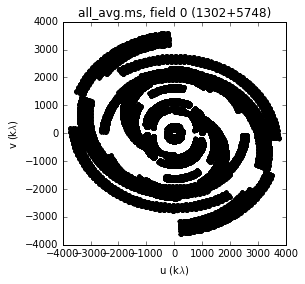

Show log 2018-01-23 09:58:32	INFO	plotuv::::	Plotting field 0 (1302+5748)

In [10]:
plotuv(vis=multi_source,maxnpts=10000000,symb='.',field=phref,colors='k')

## 2. Flagging of bad data ## 

First, Back up original flag state. You can then revert to this state by using @mode='restore' and the versionname you want to go back to.

In [11]:
flagmanager(vis=multi_source,
             mode='save',
             versionname='pre_quack')

Show log 2018-01-23 09:58:37	INFO	flagmanager::AgentFlagger::open	Table type is Measurement Set
 2018-01-23 09:58:37	INFO	flagmanager::::	Save current flagversions to pre_quack
 2018-01-23 09:58:37	INFO	plotants::::	Creating new backup flag file called pre_quack

#### Flag start of each scan ####

The decision on how long to quack (latency before antennas settle on-source) is made by inspecting the phase-reference. Plot amplitude against time. Once launched, {{plotms}} can be controlled interactively, see help plotms and the CASA Cookbook

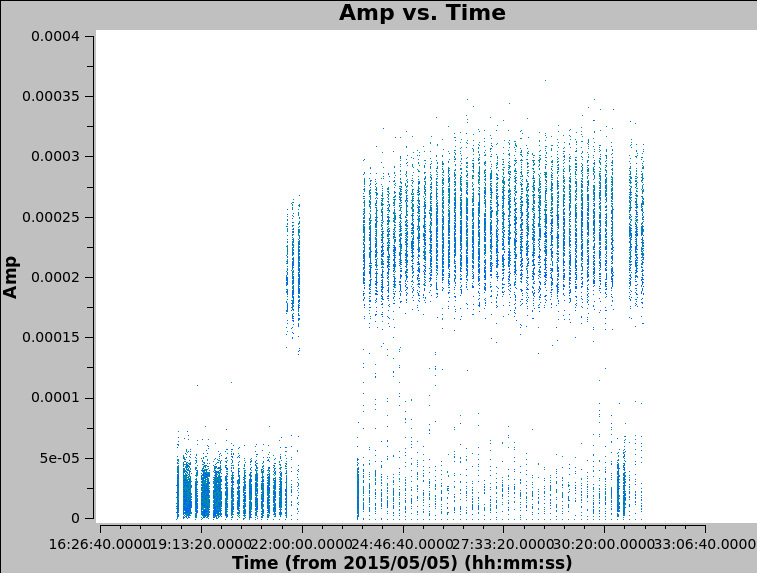

True

Show log 2018-01-23 09:58:44	INFO	PlotMS::params_changed	Updating: REDRAW, MSDATA, CACHE, AXES, CANVAS, DISPLAY, ITERATION, LOG, PLOTMS_OPTIONS.
 2018-01-23 09:58:44	INFO	PlotMS::load_cache	Clearing the existing plotms cache.
 2018-01-23 09:58:44	INFO	PlotMS::load_cache	Clearing the existing plotms cache.
 2018-01-23 09:58:44	INFO	PlotMS::params_changed	Updating: REDRAW, MSDATA, CACHE, AXES, CANVAS, DISPLAY, ITERATION, LOG, PLOTMS_OPTIONS.
 2018-01-23 09:58:44	INFO	PlotMS::load_cache	Clearing the existing plotms cache.
 2018-01-23 09:58:44	INFO	PlotMS::load_cache	START Current memory usage: 1671.64 kilobytes.
 2018-01-23 09:58:44	INFO	PlotMS::load_cache	Plot Data Transformations:
 2018-01-23 09:58:44	INFO	PlotMS::load_cache+ Frame = 
 2018-01-23 09:58:44	INFO	PlotMS::load_cache+ VelDef = RADIO
 2018-01-23 09:58:44	INFO	PlotMS::load_cache+ RestFreq = 0 MHz
 2018-01-23 09:58:44	INFO	PlotMS::load_cache+ dX = 0 arcsec
 2018-01-23 09:58:44	INFO	PlotMS::load_cache+ dY = 0 arcsec
 2018-01-23 09:58:44	INFO	PlotMS::load_cache+ formStokes = false
 2018-01-23 09:58:44	INFO	PlotMS::load_cache	Data Averaging: 
 2018-01-23 09:58:44	INFO	PlotMS::load_cache+ Using VECTOR averaging.
 2018-01-23 09:58:44	INFO	PlotMS::load_cache+ Channel: 24 channels
 2018-01-23 09:58:44	INFO	PlotMS::load_cache	Plot Data Calibration:
 2018-01-23 09:58:44	INFO	PlotMS::load_cache+ Use Calibration = 0
 2018-01-23 09:58:44	INFO	PlotMS::load_cache+ Calibration Library = 
 2018-01-23 09:58:44	INFO	PlotMS::load_cache	Caching for the new plot: Amp(17) vs. Time(2)...
 2018-01-23 09:58:50	INFO	PlotMS::load_cache	Data selection will yield a total of 27320 plottable points (flagged and unflagged).
 2018-01-23 09:58:50	INFO	PlotMS::load_cache+	The plotms cache will require an estimated 0.00098352 GB of memory (36 bytes/point).
 2018-01-23 09:58:50	INFO	PlotMS::load_cache+	This is 0.902444% of the memory avail. to CASA (free=0.108984 GB).
 2018-01-23 09:58:50	INFO	PlotMS::load_cache	Loading chunks......
 2018-01-23 09:59:00	INFO	PlotMS::load_cache	SPW 0: number of channels averaged = 24
 2018-01-23 09:59:00	INFO	PlotMS::load_cache	SPW 1: number of channels averaged = 24
 2018-01-23 09:59:00	INFO	PlotMS::load_cache	SPW 2: number of channels averaged = 24
 2018-01-23 09:59:00	INFO	PlotMS::load_cache	SPW 3: number of channels averaged = 24
 2018-01-23 09:59:00	INFO	PlotMS::load_cache	Generating the plot mask.
 2018-01-23 09:59:00	INFO	PlotMS::load_cache	refTime = 2015/05/05/00:00:00.0
 2018-01-23 09:59:00	INFO	PlotMS::load_cache	Finished loading.
 2018-01-23 09:59:00	INFO	PlotMS::load_cache	Setting up iteration indexing (if necessary), and calculating plot ranges.
 2018-01-23 09:59:00	INFO	PlotMS::load_cache	Global ranges:
 2018-01-23 09:59:00	INFO	PlotMS::load_cache+	Time: 4.93757e+09-4.93761e+09 (unflagged); 1.79769e+308--1.79769e+308 (flagged).
 2018-01-23 09:59:00	INFO	PlotMS::load_cache+	Amp: 0-0.000363756 (unflagged); 1.79769e+308--1.79769e+308(flagged).
 2018-01-23 09:59:00	INFO	PlotMS::plot	Plotting 27320 unflagged points.
 2018-01-23 09:58:44	INFO	PlotMS::load_cache	END Time: +17 seconds. Memory: +195088 kilobytes.
 2018-01-23 09:59:00	INFO	plotms::::	Plot file /home/jupyter/plotms_temp.png
 2018-01-23 09:59:01	INFO	plotms::::	Exporting the plot.
 2018-01-23 09:59:01	INFO	plotms::::	Calling pm.save
 2018-01-23 09:59:01	INFO	QPExporter::export	START Current memory usage: 196786 kilobytes.
 2018-01-23 09:59:01	INFO	QPExporter::export	END Time: +1 seconds. Memory: +47.8281 kilobytes.

In [12]:
plotms(vis=multi_source,
     field=phref,           # View the phase-ref
     spw='0~3:20~43',             # Select and average only the first ~third of channels in each spw  
     avgchannel='24',             # in case of bandpass errors in uncalibrated data 
     xaxis='time',
     yaxis='amp',
     antenna='Mk2&Pi',     
     correlation='LL,RR',   
     coloraxis='corr',            # colour LL and RR differently
     showgui=F)                 # use showgui=T to use the interactive plotms gui

Ignore the data which are entirely very low amplitude, these will be flagged later. Inspect the data where just a small part is bad. Zoom in on a few scans (see Figure) and count integrations (each is 4 sec) and/or use the Tools tab Hover to measure the bad time.
NB these data are scaled in raw correlator units, not Jy.

In [13]:
flagdata(vis='all_avg.ms',
     mode='quack',       # Flag part of each scan, default is to flag the start
     quackinterval= 60)  # duration of the start of the scan to flag in seconds ( I choose 60 seconds)      

{}

Show log 2018-01-23 09:59:24	INFO	flagdata::::	Backup original flags before applying new flags
 2018-01-23 09:59:24	INFO	AgentFlagger::open	Table type is Measurement Set
 2018-01-23 09:59:24	INFO	plotants::::	Creating new backup flag file called flagdata_1
 2018-01-23 09:59:26	INFO	AgentFlagger::open	Table type is Measurement Set
 2018-01-23 09:59:26	INFO	flagdata::::	Quack mode is active
 2018-01-23 09:59:26	INFO	flagdata::::	Initializing the agents
 2018-01-23 09:59:26	INFO	Quack::setAgentParameters quackinterval is 60
 2018-01-23 09:59:26	INFO	Quack::setAgentParameters quackmode is beg
 2018-01-23 09:59:26	INFO	Quack::setAgentParameters quackincrement is 0
 2018-01-23 09:59:26	INFO	AgentFlagger::initAgents	There are 1 valid agents in list
 2018-01-23 09:59:26	INFO	flagdata::::	Running the agentflagger tool
 2018-01-23 09:59:29	INFO	FlagMSHandler::preSweep 134 Scans found in MS
 2018-01-23 09:59:29	INFO	FlagMSHandler::	------------------------------------------------------------------------------------ 
 2018-01-23 09:59:29	INFO	FlagMSHandler::	Chunk = 1 [progress: 0%], Observation = 0, Array = 0, Scan = 1, Field = 0 (1302+5748), Spw = 0, Channels = 64, Corrs = [ RR RL LR LL ], Total Rows = 765
 2018-01-23 09:59:29	INFO	Quack::chunkSummary	=> Data flagged so far 31.3725%
 2018-01-23 09:59:29	INFO	FlagMSHandler::	------------------------------------------------------------------------------------ 
 2018-01-23 09:59:29	INFO	FlagMSHandler::	Chunk = 2 [progress: 0%], Observation = 0, Array = 0, Scan = 1, Field = 0 (1302+5748), Spw = 1, Channels = 64, Corrs = [ RR RL LR LL ], Total Rows = 765
 2018-01-23 09:59:29	INFO	Quack::chunkSummary	=> Data flagged so far 31.3725%
 2018-01-23 09:59:29	INFO	FlagMSHandler::	------------------------------------------------------------------------------------ 
 2018-01-23 09:59:29	INFO	FlagMSHandler::	Chunk = 3 [progress: 0%], Observation = 0, Array = 0, Scan = 1, Field = 0 (1302+5748), Spw = 2, Channels = 64, Corrs = [ RR RL LR LL ], Total Rows = 765
 2018-01-23 09:59:29	INFO	Quack::chunkSummary	=> Data flagged so far 31.3725%
 2018-01-23 09:59:29	INFO	FlagMSHandler::	------------------------------------------------------------------------------------ 
 2018-01-23 09:59:29	INFO	FlagMSHandler::	Chunk = 4 [progress: 0%], Observation = 0, Array = 0, Scan = 1, Field = 0 (1302+5748), Spw = 3, Channels = 64, Corrs = [ RR RL LR LL ], Total Rows = 765
 2018-01-23 09:59:29	INFO	Quack::chunkSummary	=> Data flagged so far 31.3725%
 2018-01-23 09:59:29	INFO	FlagMSHandler::	------------------------------------------------------------------------------------ 
 2018-01-23 09:59:29	INFO	FlagMSHandler::	Chunk = 5 [progress: 0%], Observation = 0, Array = 0, Scan = 2, Field = 0 (1302+5748), Spw = 0, Channels = 64, Corrs = [ RR RL LR LL ], Total Rows = 2940
 2018-01-23 09:59:29	INFO	Quack::chunkSummary	=> Data flagged so far 8.16327%
 2018-01-23 09:59:29	INFO	FlagMSHandler::	------------------------------------------------------------------------------------ 
 2018-01-23 09:59:29	INFO	FlagMSHandler::	Chunk = 6 [progress: 1%], Observation = 0, Array = 0, Scan = 2, Field = 0 (1302+5748), Spw = 1, Channels = 64, Corrs = [ RR RL LR LL ], Total Rows = 2940
 2018-01-23 09:59:29	INFO	Quack::chunkSummary	=> Data flagged so far 8.16327%
 2018-01-23 09:59:29	INFO	FlagMSHandler::	------------------------------------------------------------------------------------ 
 2018-01-23 09:59:29	INFO	FlagMSHandler::	Chunk = 7 [progress: 1%], Observation = 0, Array = 0, Scan = 2, Field = 0 (1302+5748), Spw = 2, Channels = 64, Corrs = [ RR RL LR LL ], Total Rows = 2940
 2018-01-23 09:59:29	INFO	Quack::chunkSummary	=> Data flagged so far 8.16327%
 2018-01-23 09:59:29	INFO	FlagMSHandler::	------------------------------------------------------------------------------------ 
 2018-01-23 09:59:29	INFO	FlagMSHandler::	Chunk = 8 [progress: 1%], Observation = 0, Array = 0, Scan = 2, Field = 0 (1302+5748), Spw = 3, Channels = 64, Corrs = [ RR RL 

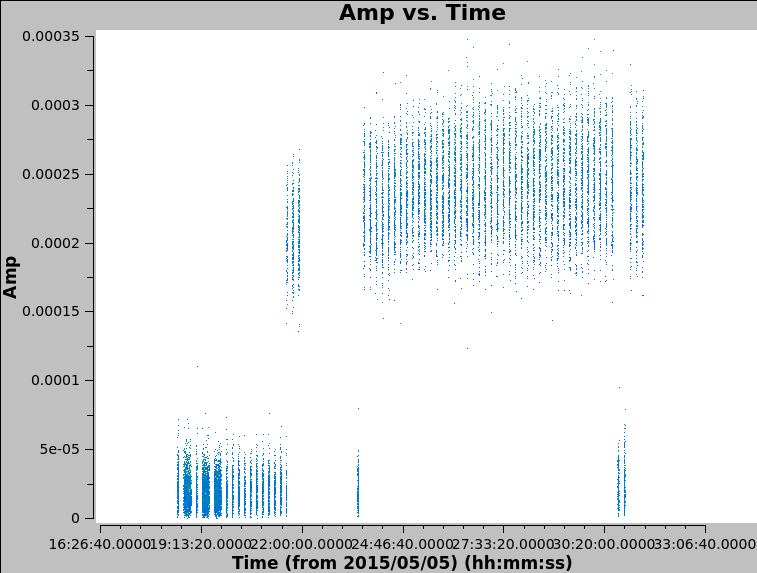

True

Show log 2018-01-23 10:00:01	INFO	PlotMS::params_changed	Updating: REDRAW, MSDATA, CACHE, AXES, CANVAS, DISPLAY, ITERATION, LOG, PLOTMS_OPTIONS.
 2018-01-23 10:00:01	INFO	PlotMS::load_cache	Clearing the existing plotms cache.
 2018-01-23 10:00:01	INFO	PlotMS::load_cache	START Current memory usage: 6863.39 kilobytes.
 2018-01-23 10:00:01	INFO	PlotMS::load_cache	Plot Data Transformations:
 2018-01-23 10:00:01	INFO	PlotMS::load_cache+ Frame = 
 2018-01-23 10:00:01	INFO	PlotMS::load_cache+ VelDef = RADIO
 2018-01-23 10:00:01	INFO	PlotMS::load_cache+ RestFreq = 0 MHz
 2018-01-23 10:00:01	INFO	PlotMS::load_cache+ dX = 0 arcsec
 2018-01-23 10:00:01	INFO	PlotMS::load_cache+ dY = 0 arcsec
 2018-01-23 10:00:01	INFO	PlotMS::load_cache+ formStokes = false
 2018-01-23 10:00:01	INFO	PlotMS::load_cache	Data Averaging: 
 2018-01-23 10:00:01	INFO	PlotMS::load_cache+ Using VECTOR averaging.
 2018-01-23 10:00:01	INFO	PlotMS::load_cache+ Channel: 24 channels
 2018-01-23 10:00:01	INFO	PlotMS::load_cache	Plot Data Calibration:
 2018-01-23 10:00:01	INFO	PlotMS::load_cache+ Use Calibration = 0
 2018-01-23 10:00:01	INFO	PlotMS::load_cache+ Calibration Library = 
 2018-01-23 10:00:01	INFO	PlotMS::load_cache	Caching for the new plot: Amp(17) vs. Time(2)...
 2018-01-23 10:00:05	INFO	PlotMS::load_cache	Data selection will yield a total of 27320 plottable points (flagged and unflagged).
 2018-01-23 10:00:05	INFO	PlotMS::load_cache+	The plotms cache will require an estimated 0.00098352 GB of memory (36 bytes/point).
 2018-01-23 10:00:05	INFO	PlotMS::load_cache+	This is 0.525227% of the memory avail. to CASA (free=0.187256 GB).
 2018-01-23 10:00:05	INFO	PlotMS::load_cache	Loading chunks......
 2018-01-23 10:00:15	INFO	PlotMS::load_cache	SPW 0: number of channels averaged = 24
 2018-01-23 10:00:15	INFO	PlotMS::load_cache	SPW 1: number of channels averaged = 24
 2018-01-23 10:00:15	INFO	PlotMS::load_cache	SPW 2: number of channels averaged = 24
 2018-01-23 10:00:15	INFO	PlotMS::load_cache	SPW 3: number of channels averaged = 24
 2018-01-23 10:00:15	INFO	PlotMS::load_cache	Generating the plot mask.
 2018-01-23 10:00:15	INFO	PlotMS::load_cache	refTime = 2015/05/05/00:00:00.0
 2018-01-23 10:00:15	INFO	PlotMS::load_cache	Finished loading.
 2018-01-23 10:00:15	INFO	PlotMS::load_cache	Setting up iteration indexing (if necessary), and calculating plot ranges.
 2018-01-23 10:00:15	INFO	PlotMS::load_cache	Global ranges:
 2018-01-23 10:00:15	INFO	PlotMS::load_cache+	Time: 4.93757e+09-4.93761e+09 (unflagged); 4.93757e+09-4.93761e+09 (flagged).
 2018-01-23 10:00:15	INFO	PlotMS::load_cache+	Amp: 3.07053e-07-0.000348546 (unflagged); 0-0.000363756(flagged).
 2018-01-23 10:00:15	INFO	PlotMS::plot	Plotting 18872 unflagged points.
 2018-01-23 10:00:01	INFO	PlotMS::load_cache	END Time: +14 seconds. Memory: +191703 kilobytes.
 2018-01-23 10:00:15	INFO	plotms::::	Plot file /home/jupyter/plotms_temp.png
 2018-01-23 10:00:16	INFO	plotms::::	Exporting the plot.
 2018-01-23 10:00:16	INFO	plotms::::	Calling pm.save
 2018-01-23 10:00:16	INFO	QPExporter::export	START Current memory usage: 198563 kilobytes.
 2018-01-23 10:00:16	INFO	QPExporter::export	END Time: +1 seconds. Memory: +0.953125 kilobytes.

In [14]:
#Check in plotms:
plotms(vis=multi_source,
        field=phref,                    # All fields now
        spw='0~3:20~43',             # Select and average only the first ~third of channels in each spw  
        avgchannel='24',             # in case of bandpass errors in uncalibrated data 
        xaxis='time',
        yaxis='amp',
        antenna='Mk2&Pi',     
        correlation='LL,RR',   
        coloraxis='corr',           # colour each field differently
        showgui=F)

### Identify and flag noisy end channels ###
Plot the visibility amplitudes of a bright source as a function of channel in order to identify what to flag. 

Below we plot the bandpass calibrator for a single baseline (Mk2-Pi) for spw 0. You can see the edge channels on both sides have lower sensitivity than the rest. These should be flagged. You can view the different baselines and spws to identify the other low-sensitivity channels. 

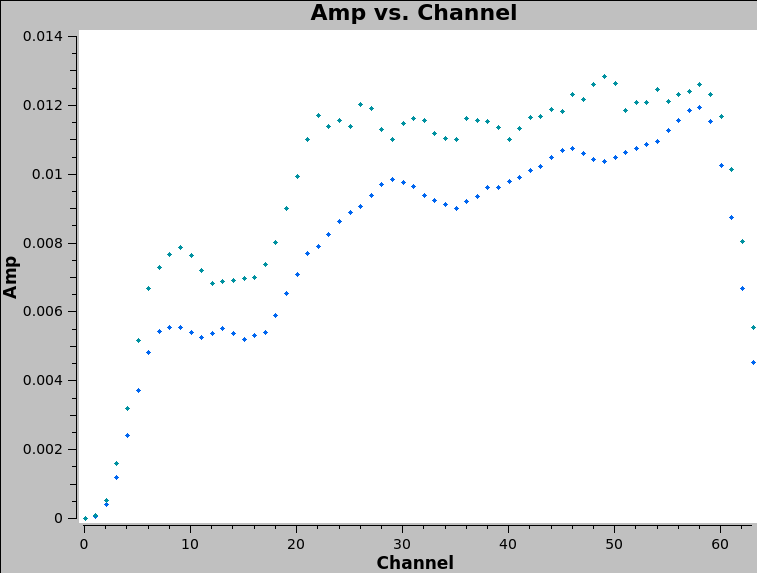

True

Show log 2018-01-23 10:05:45	INFO	PlotMS::params_changed	Updating: REDRAW, MSDATA, CACHE, AXES, CANVAS, DISPLAY, ITERATION, LOG, PLOTMS_OPTIONS.
 2018-01-23 10:05:45	INFO	PlotMS::load_cache	Clearing the existing plotms cache.
 2018-01-23 10:05:45	INFO	PlotMS::load_cache	START Current memory usage: 6926.59 kilobytes.
 2018-01-23 10:05:45	INFO	PlotMS::load_cache	Plot Data Transformations:
 2018-01-23 10:05:45	INFO	PlotMS::load_cache+ Frame = 
 2018-01-23 10:05:45	INFO	PlotMS::load_cache+ VelDef = RADIO
 2018-01-23 10:05:45	INFO	PlotMS::load_cache+ RestFreq = 0 MHz
 2018-01-23 10:05:45	INFO	PlotMS::load_cache+ dX = 0 arcsec
 2018-01-23 10:05:45	INFO	PlotMS::load_cache+ dY = 0 arcsec
 2018-01-23 10:05:45	INFO	PlotMS::load_cache+ formStokes = false
 2018-01-23 10:05:45	INFO	PlotMS::load_cache	Data Averaging: 
 2018-01-23 10:05:45	INFO	PlotMS::load_cache+ Using VECTOR averaging.
 2018-01-23 10:05:45	INFO	PlotMS::load_cache+ Time: 99999 seconds. Scan: true; Field: false
 2018-01-23 10:05:45	INFO	PlotMS::load_cache	Plot Data Calibration:
 2018-01-23 10:05:45	INFO	PlotMS::load_cache+ Use Calibration = 0
 2018-01-23 10:05:45	INFO	PlotMS::load_cache+ Calibration Library = 
 2018-01-23 10:05:45	INFO	PlotMS::load_cache	Caching for the new plot: Amp(17) vs. Channel(5)...
 2018-01-23 10:05:47	INFO	PlotMS::load_cache	Data selection will yield a total of 128 plottable points (flagged and unflagged).
 2018-01-23 10:05:47	INFO	PlotMS::load_cache+	The plotms cache will require an estimated 1.584e-06 GB of memory (12.375 bytes/point).
 2018-01-23 10:05:47	INFO	PlotMS::load_cache+	This is 0.000813242% of the memory avail. to CASA (free=0.194776 GB).
 2018-01-23 10:05:48	INFO	PlotMS::load_cache	Loading chunks......
 2018-01-23 10:05:48	INFO	PlotMS::load_cache	Generating the plot mask.
 2018-01-23 10:05:48	INFO	PlotMS::load_cache	refTime = 2015/05/06/00:00:00.0
 2018-01-23 10:05:48	INFO	PlotMS::load_cache	Finished loading.
 2018-01-23 10:05:48	INFO	PlotMS::load_cache	Setting up iteration indexing (if necessary), and calculating plot ranges.
 2018-01-23 10:05:48	INFO	PlotMS::load_cache	Global ranges:
 2018-01-23 10:05:48	INFO	PlotMS::load_cache+	Channel: 0-63 (unflagged); 1.79769e+308--1.79769e+308 (flagged).
 2018-01-23 10:05:48	INFO	PlotMS::load_cache+	Amp: 2.29484e-06-0.0128555 (unflagged); 1.79769e+308--1.79769e+308(flagged).
 2018-01-23 10:05:48	INFO	PlotMS::plot	Plotting 128 unflagged points.
 2018-01-23 10:05:45	INFO	PlotMS::load_cache	END Time: +3 seconds. Memory: +175.25 kilobytes.
 2018-01-23 10:05:48	INFO	plotms::::	Plot file /home/jupyter/plotms_temp.png
 2018-01-23 10:05:48	INFO	plotms::::	Exporting the plot.
 2018-01-23 10:05:48	INFO	plotms::::	Calling pm.save
 2018-01-23 10:05:48	INFO	QPExporter::export	START Current memory usage: 7098.77 kilobytes.
 2018-01-23 10:05:48	INFO	QPExporter::export	END Time: +0 seconds. Memory: +1 kilobytes.

In [18]:
os.system('rm -rf *.png')
plotms(vis=multi_source,
        field=bpcal,
        spw='0',
        xaxis='channel',
        yaxis='amp',
        antenna='Mk2&Pi',   # change if necessary
        correlation='LL,RR',   
        avgtime='99999',    # if data mostly good
        avgscan=T,
        coloraxis='corr') 

The ones I decided to flag are given in the flagdata command below. Back up existing flags (do this any time you think advisable).

In [19]:
flagmanager(vis='all_avg.ms',
            mode='save',
            versionname='pre_endchans')

Show log 2018-01-23 10:44:45	INFO	flagmanager::AgentFlagger::open	Table type is Measurement Set
 2018-01-23 10:44:45	INFO	flagmanager::::	Save current flagversions to pre_endchans
 2018-01-23 10:44:45	INFO	plotants::::	Creating new backup flag file called pre_endchans

In [20]:
flagdata(vis=multi_source,
    mode='manual',
    spw='0:0~6;60~63,1:0~3;61~63,2:0~3;61~63,3:0~4')

{}

Show log 2018-01-23 10:45:15	INFO	flagdata::::	Backup original flags before applying new flags
 2018-01-23 10:45:15	INFO	AgentFlagger::open	Table type is Measurement Set
 2018-01-23 10:45:15	INFO	plotants::::	Creating new backup flag file called flagdata_2
 2018-01-23 10:45:16	INFO	AgentFlagger::open	Table type is Measurement Set
 2018-01-23 10:45:16	INFO	flagdata::::	Manual mode is active
 2018-01-23 10:45:16	INFO	FlagMSHandler::selectData Selected spw-channels ids are Axis Lengths: [7, 4] (NB: Matrix in Row/Column order)
 2018-01-23 10:45:16	INFO	FlagMSHandler::selectData +	[0, 0, 6, 1
 2018-01-23 10:45:16	INFO	FlagMSHandler::selectData + 0, 60, 63, 1
 2018-01-23 10:45:16	INFO	FlagMSHandler::selectData + 1, 0, 3, 1
 2018-01-23 10:45:16	INFO	FlagMSHandler::selectData + 1, 61, 63, 1
 2018-01-23 10:45:16	INFO	FlagMSHandler::selectData + 2, 0, 3, 1
 2018-01-23 10:45:16	INFO	FlagMSHandler::selectData + 2, 61, 63, 1
 2018-01-23 10:45:16	INFO	FlagMSHandler::selectData + 3, 0, 4, 1]
 2018-01-23 10:45:16	INFO	flagdata::::	Initializing the agents
 2018-01-23 10:45:16	INFO	Manual::setAgentParameters autocorr is 0
 2018-01-23 10:45:16	INFO	AgentFlagger::initAgents	There are 1 valid agents in list
 2018-01-23 10:45:16	INFO	flagdata::::	Running the agentflagger tool
 2018-01-23 10:45:17	INFO	FlagMSHandler::	------------------------------------------------------------------------------------ 
 2018-01-23 10:45:17	INFO	FlagMSHandler::	Chunk = 1 [progress: 0%], Observation = 0, Array = 0, Scan = 1, Field = 0 (1302+5748), Spw = 0, Channels = 64, Corrs = [ RR RL LR LL ], Total Rows = 765
 2018-01-23 10:45:17	INFO	Manual::chunkSummary	=> Data flagged so far 17.1875%
 2018-01-23 10:45:17	INFO	FlagMSHandler::	------------------------------------------------------------------------------------ 
 2018-01-23 10:45:17	INFO	FlagMSHandler::	Chunk = 2 [progress: 0%], Observation = 0, Array = 0, Scan = 1, Field = 0 (1302+5748), Spw = 1, Channels = 64, Corrs = [ RR RL LR LL ], Total Rows = 765
 2018-01-23 10:45:17	INFO	Manual::chunkSummary	=> Data flagged so far 10.9375%
 2018-01-23 10:45:17	INFO	FlagMSHandler::	------------------------------------------------------------------------------------ 
 2018-01-23 10:45:17	INFO	FlagMSHandler::	Chunk = 3 [progress: 0%], Observation = 0, Array = 0, Scan = 1, Field = 0 (1302+5748), Spw = 2, Channels = 64, Corrs = [ RR RL LR LL ], Total Rows = 765
 2018-01-23 10:45:17	INFO	Manual::chunkSummary	=> Data flagged so far 10.9375%
 2018-01-23 10:45:17	INFO	FlagMSHandler::	------------------------------------------------------------------------------------ 
 2018-01-23 10:45:17	INFO	FlagMSHandler::	Chunk = 4 [progress: 0%], Observation = 0, Array = 0, Scan = 1, Field = 0 (1302+5748), Spw = 3, Channels = 64, Corrs = [ RR RL LR LL ], Total Rows = 765
 2018-01-23 10:45:17	INFO	Manual::chunkSummary	=> Data flagged so far 7.8125%
 2018-01-23 10:45:17	INFO	FlagMSHandler::	------------------------------------------------------------------------------------ 
 2018-01-23 10:45:17	INFO	FlagMSHandler::	Chunk = 5 [progress: 0%], Observation = 0, Array = 0, Scan = 2, Field = 0 (1302+5748), Spw = 0, Channels = 64, Corrs = [ RR RL LR LL ], Total Rows = 2940
 2018-01-23 10:45:17	INFO	Manual::chunkSummary	=> Data flagged so far 17.1875%
 2018-01-23 10:45:17	INFO	FlagMSHandler::	------------------------------------------------------------------------------------ 
 2018-01-23 10:45:17	INFO	FlagMSHandler::	Chunk = 6 [progress: 1%], Observation = 0, Array = 0, Scan = 2, Field = 0 (1302+5748), Spw = 1, Channels = 64, Corrs = [ RR RL LR LL ], Total Rows = 2940
 2018-01-23 10:45:17	INFO	Manual::chunkSummary	=> Data flagged so far 10.9375%
 2018-01-23 10:45:17	INFO	FlagMSHandler::	------------------------------------------------------------------------------------ 
 2018-01-23 10:45:17	INFO	FlagMSHandler::	Chunk = 7 [progress: 1%], Observation = 0, Array = 0, Scan = 2, Field = 0 (1302+5748), Spw = 2, Channels = 64, Corrs = [ RR RL LR LL ], Total 

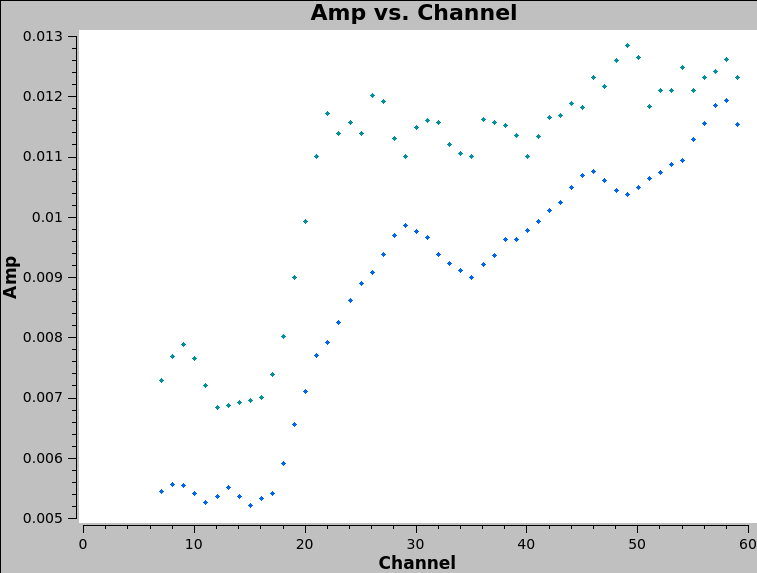

True

Show log 2018-01-23 10:46:41	INFO	PlotMS::params_changed	Updating: REDRAW, MSDATA, CACHE, AXES, CANVAS, DISPLAY, ITERATION, LOG, PLOTMS_OPTIONS.
 2018-01-23 10:46:41	INFO	PlotMS::load_cache	Clearing the existing plotms cache.
 2018-01-23 10:46:42	INFO	PlotMS::load_cache	START Current memory usage: 6939.72 kilobytes.
 2018-01-23 10:46:42	INFO	PlotMS::load_cache	Plot Data Transformations:
 2018-01-23 10:46:42	INFO	PlotMS::load_cache+ Frame = 
 2018-01-23 10:46:42	INFO	PlotMS::load_cache+ VelDef = RADIO
 2018-01-23 10:46:42	INFO	PlotMS::load_cache+ RestFreq = 0 MHz
 2018-01-23 10:46:42	INFO	PlotMS::load_cache+ dX = 0 arcsec
 2018-01-23 10:46:42	INFO	PlotMS::load_cache+ dY = 0 arcsec
 2018-01-23 10:46:42	INFO	PlotMS::load_cache+ formStokes = false
 2018-01-23 10:46:42	INFO	PlotMS::load_cache	Data Averaging: 
 2018-01-23 10:46:42	INFO	PlotMS::load_cache+ Using VECTOR averaging.
 2018-01-23 10:46:42	INFO	PlotMS::load_cache+ Time: 99999 seconds. Scan: true; Field: false
 2018-01-23 10:46:42	INFO	PlotMS::load_cache	Plot Data Calibration:
 2018-01-23 10:46:42	INFO	PlotMS::load_cache+ Use Calibration = 0
 2018-01-23 10:46:42	INFO	PlotMS::load_cache+ Calibration Library = 
 2018-01-23 10:46:42	INFO	PlotMS::load_cache	Caching for the new plot: Amp(17) vs. Channel(5)...
 2018-01-23 10:46:44	INFO	PlotMS::load_cache	Data selection will yield a total of 128 plottable points (flagged and unflagged).
 2018-01-23 10:46:44	INFO	PlotMS::load_cache+	The plotms cache will require an estimated 1.584e-06 GB of memory (12.375 bytes/point).
 2018-01-23 10:46:44	INFO	PlotMS::load_cache+	This is 0.000597673% of the memory avail. to CASA (free=0.265028 GB).
 2018-01-23 10:46:45	INFO	PlotMS::load_cache	Loading chunks......
 2018-01-23 10:46:45	INFO	PlotMS::load_cache	Generating the plot mask.
 2018-01-23 10:46:45	INFO	PlotMS::load_cache	refTime = 2015/05/06/00:00:00.0
 2018-01-23 10:46:45	INFO	PlotMS::load_cache	Finished loading.
 2018-01-23 10:46:45	INFO	PlotMS::load_cache	Setting up iteration indexing (if necessary), and calculating plot ranges.
 2018-01-23 10:46:45	INFO	PlotMS::load_cache	Global ranges:
 2018-01-23 10:46:45	INFO	PlotMS::load_cache+	Channel: 7-59 (unflagged); 0-63 (flagged).
 2018-01-23 10:46:45	INFO	PlotMS::load_cache+	Amp: 0.00522336-0.0128555 (unflagged); 2.2548e-06-0.0114813(flagged).
 2018-01-23 10:46:45	INFO	PlotMS::plot	Plotting 106 unflagged points.
 2018-01-23 10:46:42	INFO	PlotMS::load_cache	END Time: +4 seconds. Memory: +175.469 kilobytes.
 2018-01-23 10:46:45	INFO	plotms::::	Plot file /home/jupyter/plotms_temp.png
 2018-01-23 10:46:46	INFO	plotms::::	Exporting the plot.
 2018-01-23 10:46:46	INFO	plotms::::	Calling pm.save
 2018-01-23 10:46:46	INFO	QPExporter::export	START Current memory usage: 7113.39 kilobytes.
 2018-01-23 10:46:46	INFO	QPExporter::export	END Time: +0 seconds. Memory: +1.20312 kilobytes.

In [21]:
# Check the effects in plotms. Note the amplitude scaling
os.system('rm -rf *.png')
plotms(vis=multi_source,
        field=bpcal,
        spw='0',
        xaxis='channel',
        yaxis='amp',
        antenna='Mk2&Pi',   # change if necessary
        correlation='LL,RR',   
        avgtime='99999',    # if data mostly good
        avgscan=T,
        coloraxis='corr')

### Flag bad data by time range ###

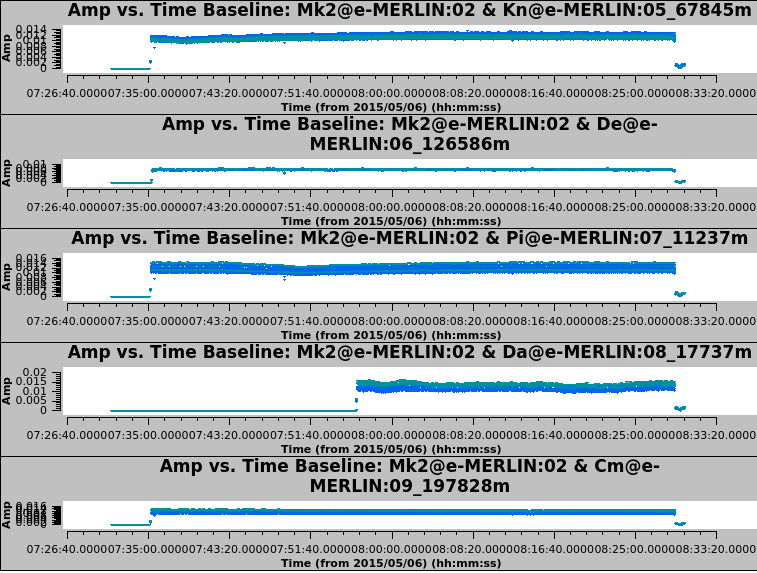

True

Show log 2018-01-23 10:49:20	INFO	PlotMS::params_changed	Updating: REDRAW, MSDATA, CACHE, AXES, CANVAS, DISPLAY, ITERATION, LOG, PLOTMS_OPTIONS.
 2018-01-23 10:49:20	INFO	PlotMS::load_cache	Clearing the existing plotms cache.
 2018-01-23 10:49:20	INFO	PlotMS::load_cache	START Current memory usage: 7544.38 kilobytes.
 2018-01-23 10:49:20	INFO	PlotMS::load_cache	Plot Data Transformations:
 2018-01-23 10:49:20	INFO	PlotMS::load_cache+ Frame = 
 2018-01-23 10:49:20	INFO	PlotMS::load_cache+ VelDef = RADIO
 2018-01-23 10:49:20	INFO	PlotMS::load_cache+ RestFreq = 0 MHz
 2018-01-23 10:49:20	INFO	PlotMS::load_cache+ dX = 0 arcsec
 2018-01-23 10:49:20	INFO	PlotMS::load_cache+ dY = 0 arcsec
 2018-01-23 10:49:20	INFO	PlotMS::load_cache+ formStokes = false
 2018-01-23 10:49:20	INFO	PlotMS::load_cache	Data Averaging: 
 2018-01-23 10:49:20	INFO	PlotMS::load_cache+ Using VECTOR averaging.
 2018-01-23 10:49:20	INFO	PlotMS::load_cache+ Channel: 64 channels
 2018-01-23 10:49:20	INFO	PlotMS::load_cache	Plot Data Calibration:
 2018-01-23 10:49:20	INFO	PlotMS::load_cache+ Use Calibration = 0
 2018-01-23 10:49:20	INFO	PlotMS::load_cache+ Calibration Library = 
 2018-01-23 10:49:20	INFO	PlotMS::load_cache	Caching for the new plot: Amp(17) vs. Time(2)...
 2018-01-23 10:49:23	INFO	PlotMS::load_cache	Data selection will yield a total of 36000 plottable points (flagged and unflagged).
 2018-01-23 10:49:23	INFO	PlotMS::load_cache+	The plotms cache will require an estimated 0.0006048 GB of memory (16.8 bytes/point).
 2018-01-23 10:49:23	INFO	PlotMS::load_cache+	This is 0.2418% of the memory avail. to CASA (free=0.250124 GB).
 2018-01-23 10:49:23	INFO	PlotMS::load_cache	Loading chunks......
 2018-01-23 10:49:26	INFO	PlotMS::load_cache	SPW 0: number of channels averaged = 64
 2018-01-23 10:49:26	INFO	PlotMS::load_cache	SPW 1: number of channels averaged = 64
 2018-01-23 10:49:26	INFO	PlotMS::load_cache	SPW 2: number of channels averaged = 64
 2018-01-23 10:49:26	INFO	PlotMS::load_cache	SPW 3: number of channels averaged = 64
 2018-01-23 10:49:26	INFO	PlotMS::load_cache	Generating the plot mask.
 2018-01-23 10:49:26	INFO	PlotMS::load_cache	refTime = 2015/05/06/00:00:00.0
 2018-01-23 10:49:26	INFO	PlotMS::load_cache	Finished loading.
 2018-01-23 10:49:26	INFO	PlotMS::load_cache	Setting up iteration indexing (if necessary), and calculating plot ranges.
 2018-01-23 10:49:26	INFO	PlotMS::load_cache	Global ranges:
 2018-01-23 10:49:26	INFO	PlotMS::load_cache+	Time: 4.93761e+09-4.93762e+09 (unflagged); 4.93761e+09-4.93761e+09 (flagged).
 2018-01-23 10:49:26	INFO	PlotMS::load_cache+	Amp: 2.17131e-07-0.0165115 (unflagged); 0-4.36586e-05(flagged).
 2018-01-23 10:49:26	INFO	PlotMS::load_cache	Setting up iteration indexing (if necessary), and calculating plot ranges.
 2018-01-23 10:49:26	INFO	PlotMS::load_cache	Found 5 Baseline iterations.
 2018-01-23 10:49:26	INFO	PlotMS::load_cache	Global ranges:
 2018-01-23 10:49:26	INFO	PlotMS::load_cache+	Time: 4.93761e+09-4.93762e+09 (unflagged); 4.93761e+09-4.93761e+09 (flagged).
 2018-01-23 10:49:26	INFO	PlotMS::load_cache+	Amp: 2.17131e-07-0.0165115 (unflagged); 0-4.36586e-05(flagged).
 2018-01-23 10:49:26	INFO	PlotMS::plot	Stepping to iteration = 1 (of 5): Baseline: Mk2@e-MERLIN:02 & Kn@e-MERLIN:05_67845m
 2018-01-23 10:49:26	INFO	PlotMS::plot	Stepping to iteration = 2 (of 5): Baseline: Mk2@e-MERLIN:02 & De@e-MERLIN:06_126586m
 2018-01-23 10:49:26	INFO	PlotMS::plot	Stepping to iteration = 3 (of 5): Baseline: Mk2@e-MERLIN:02 & Pi@e-MERLIN:07_11237m
 2018-01-23 10:49:26	INFO	PlotMS::plot	Stepping to iteration = 4 (of 5): Baseline: Mk2@e-MERLIN:02 & Da@e-MERLIN:08_17737m
 2018-01-23 10:49:26	INFO	PlotMS::plot	Stepping to iteration = 5 (of 5): Baseline: Mk2@e-MERLIN:02 & Cm@e-MERLIN:09_197828m
 2018-01-23 10:49:26	INFO	PlotMS::plot	Plotting 7072 unflagged points.
 2018-01-23 10:49:20	INFO	PlotMS::load_cache	END Time: +6 seconds. Memory: +52462.2 kilobytes.
 2018-01-23 10:49:26	INFO	plotms::::	Plot file /home/jupyter/plotms_temp.pn

In [22]:
# Inspect the channel-averaged data.

plotms(vis=multi_source,
        gridrows=5,
        gridcols=1,
        field=bpcal,
        avgchannel='64',
        xaxis='time',
        yaxis='amp',
        antenna='Mk2&*',           # Plot all baselines to refant
        correlation='LL,RR',   
        iteraxis='baseline', 
        coloraxis='corr',
        showgui=F)

Use zoom and hover to identify bad times (very low amplitudes). Plot each baseline separately if you prefer (gridrows=1).

Repeat for all the other sources. This target is bright enough to tell signal from noise in raw data, but for faint targets, flag any periods enclosed by bad phase-ref data and defer other flagging until after applying calibration. List the bad times/fields/antennas in a "flag command file" formatted like this with no spaces except between parameters:

mode='manual' field='1302+5748,1252+5634' antenna='Da' timerange='30:33:38~31:31:06

This can take some time. A flag command file has already been carefully prepared, which we will use below.

In [23]:
flagdata(vis=multi_source,
    mode='list',
    inpfile='all_avg_1.flags')

{}

Show log 2018-01-23 10:49:58	INFO	flagdata::::	Backup original flags before applying new flags
 2018-01-23 10:49:58	INFO	AgentFlagger::open	Table type is Measurement Set
 2018-01-23 10:49:58	INFO	plotants::::	Creating new backup flag file called flagdata_3
 2018-01-23 10:49:58	INFO	AgentFlagger::open	Table type is Measurement Set
 2018-01-23 10:49:58	INFO	flagdata::::	List mode is active
 2018-01-23 10:49:58	INFO	flagdata::::	Read 32 command(s) from file: all_avg_1.flags
 2018-01-23 10:50:00	INFO	flagdata::::	Selected 32 commands from combined input list(s) 
 2018-01-23 10:50:00	INFO	AgentFlagger::parseAgentParameters	Validating data column DATA based on input type
 2018-01-23 10:50:00	INFO	AgentFlagger::parseAgentParameters	Validating data column DATA based on input type
 2018-01-23 10:50:00	INFO	flagdata::::	Initializing the agents
 2018-01-23 10:50:01	INFO	Clip_30::setAgentParameters data column is DATA
 2018-01-23 10:50:01	INFO	Clip_30::setAgentParameters Visibility expression is ABS RR,RL,LR,LL
 2018-01-23 10:50:01	INFO	Clip_30::setAgentParameters clipzeros is 0
 2018-01-23 10:50:01	INFO	Clip_30::setAgentParameters clipoutside is 1
 2018-01-23 10:50:01	INFO	Clip_30::setAgentParameters clipmin is -1
 2018-01-23 10:50:01	INFO	Clip_30::setAgentParameters clipmax is 0.001
 2018-01-23 10:50:01	INFO	Clip_30::setAgentParameters Clipping outside [-1,0.001], plus NaNs
 2018-01-23 10:50:01	INFO	Clip_31::setAgentParameters data column is DATA
 2018-01-23 10:50:01	INFO	Clip_31::setAgentParameters Visibility expression is ABS RR,RL,LR,LL
 2018-01-23 10:50:01	INFO	Clip_31::setAgentParameters clipzeros is 0
 2018-01-23 10:50:01	INFO	Clip_31::setAgentParameters clipoutside is 1
 2018-01-23 10:50:01	INFO	Clip_31::setAgentParameters clipmin is -1
 2018-01-23 10:50:01	INFO	Clip_31::setAgentParameters clipmax is 0.0015
 2018-01-23 10:50:01	INFO	Clip_31::setAgentParameters Clipping outside [-1,0.0015], plus NaNs
 2018-01-23 10:50:01	INFO	AgentFlagger::initAgents	There are 32 valid agents in list
 2018-01-23 10:50:01	INFO	flagdata::::	Running the agentflagger tool
 2018-01-23 10:50:02	INFO	FlagMSHandler::	------------------------------------------------------------------------------------ 
 2018-01-23 10:50:02	INFO	FlagMSHandler::	Chunk = 1 [progress: 0%], Observation = 0, Array = 0, Scan = 1, Field = 0 (1302+5748), Spw = 0, Channels = 64, Corrs = [ RR RL LR LL ], Total Rows = 765
 2018-01-23 10:50:02	INFO	Manual_13::chunkSummary	=> Data flagged so far 100%
 2018-01-23 10:50:02	INFO	FlagMSHandler::	------------------------------------------------------------------------------------ 
 2018-01-23 10:50:02	INFO	FlagMSHandler::	Chunk = 2 [progress: 0%], Observation = 0, Array = 0, Scan = 1, Field = 0 (1302+5748), Spw = 1, Channels = 64, Corrs = [ RR RL LR LL ], Total Rows = 765
 2018-01-23 10:50:02	INFO	Manual_13::chunkSummary	=> Data flagged so far 100%
 2018-01-23 10:50:02	INFO	FlagMSHandler::	------------------------------------------------------------------------------------ 
 2018-01-23 10:50:02	INFO	FlagMSHandler::	Chunk = 3 [progress: 0%], Observation = 0, Array = 0, Scan = 1, Field = 0 (1302+5748), Spw = 2, Channels = 64, Corrs = [ RR RL LR LL ], Total Rows = 765
 2018-01-23 10:50:02	INFO	Manual_13::chunkSummary	=> Data flagged so far 100%
 2018-01-23 10:50:02	INFO	FlagMSHandler::	------------------------------------------------------------------------------------ 
 2018-01-23 10:50:02	INFO	FlagMSHandler::	Chunk = 4 [progress: 0%], Observation = 0, Array = 0, Scan = 1, Field = 0 (1302+5748), Spw = 3, Channels = 64, Corrs = [ RR RL LR LL ], Total Rows = 765
 2018-01-23 10:50:02	INFO	Manual_13::chunkSummary	=> Data flagged so far 100%
 2018-01-23 10:50:02	INFO	Clip_30::chunkSummary	=> Data flagged so far 0.00561683%
 2018-01-23 10:50:02	INFO	FlagMSHandler::	------------------------------------------------------------------------------------ 
 2018-01-23 10:50:02	INFO	FlagMSHandler::	Chunk = 5 [progress: 0%], Observation = 0, Array = 0, Scan 

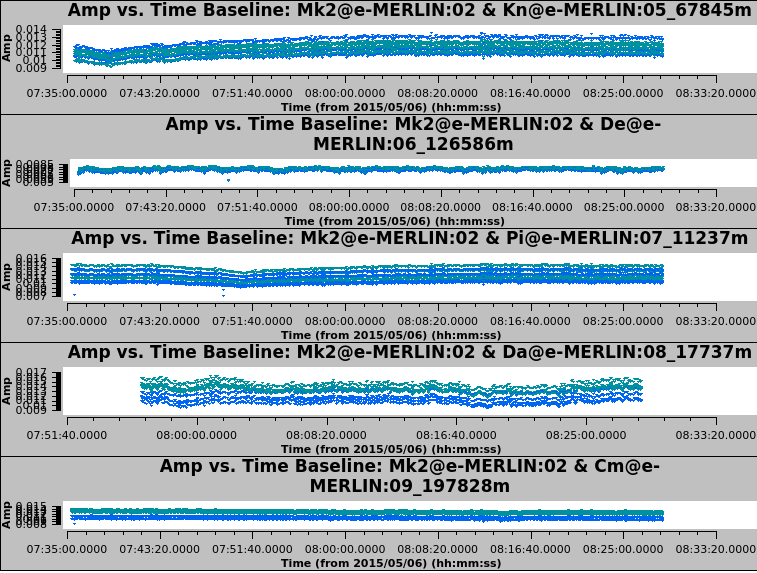

True

Show log 2018-01-23 10:50:32	INFO	PlotMS::params_changed	Updating: REDRAW, MSDATA, CACHE, AXES, CANVAS, DISPLAY, ITERATION, LOG, PLOTMS_OPTIONS.
 2018-01-23 10:50:32	INFO	PlotMS::load_cache	Clearing the existing plotms cache.
 2018-01-23 10:50:32	INFO	PlotMS::load_cache	START Current memory usage: 7908.66 kilobytes.
 2018-01-23 10:50:32	INFO	PlotMS::load_cache	Plot Data Transformations:
 2018-01-23 10:50:32	INFO	PlotMS::load_cache+ Frame = 
 2018-01-23 10:50:32	INFO	PlotMS::load_cache+ VelDef = RADIO
 2018-01-23 10:50:32	INFO	PlotMS::load_cache+ RestFreq = 0 MHz
 2018-01-23 10:50:32	INFO	PlotMS::load_cache+ dX = 0 arcsec
 2018-01-23 10:50:32	INFO	PlotMS::load_cache+ dY = 0 arcsec
 2018-01-23 10:50:32	INFO	PlotMS::load_cache+ formStokes = false
 2018-01-23 10:50:32	INFO	PlotMS::load_cache	Data Averaging: 
 2018-01-23 10:50:32	INFO	PlotMS::load_cache+ Using VECTOR averaging.
 2018-01-23 10:50:32	INFO	PlotMS::load_cache+ Channel: 64 channels
 2018-01-23 10:50:32	INFO	PlotMS::load_cache	Plot Data Calibration:
 2018-01-23 10:50:32	INFO	PlotMS::load_cache+ Use Calibration = 0
 2018-01-23 10:50:32	INFO	PlotMS::load_cache+ Calibration Library = 
 2018-01-23 10:50:32	INFO	PlotMS::load_cache	Caching for the new plot: Amp(17) vs. Time(2)...
 2018-01-23 10:50:35	INFO	PlotMS::load_cache	Data selection will yield a total of 36000 plottable points (flagged and unflagged).
 2018-01-23 10:50:35	INFO	PlotMS::load_cache+	The plotms cache will require an estimated 0.0006048 GB of memory (16.8 bytes/point).
 2018-01-23 10:50:35	INFO	PlotMS::load_cache+	This is 0.230288% of the memory avail. to CASA (free=0.262628 GB).
 2018-01-23 10:50:35	INFO	PlotMS::load_cache	Loading chunks......
 2018-01-23 10:50:38	INFO	PlotMS::load_cache	SPW 0: number of channels averaged = 64
 2018-01-23 10:50:38	INFO	PlotMS::load_cache	SPW 1: number of channels averaged = 64
 2018-01-23 10:50:38	INFO	PlotMS::load_cache	SPW 2: number of channels averaged = 64
 2018-01-23 10:50:38	INFO	PlotMS::load_cache	SPW 3: number of channels averaged = 64
 2018-01-23 10:50:38	INFO	PlotMS::load_cache	Generating the plot mask.
 2018-01-23 10:50:38	INFO	PlotMS::load_cache	refTime = 2015/05/06/00:00:00.0
 2018-01-23 10:50:38	INFO	PlotMS::load_cache	Finished loading.
 2018-01-23 10:50:38	INFO	PlotMS::load_cache	Setting up iteration indexing (if necessary), and calculating plot ranges.
 2018-01-23 10:50:38	INFO	PlotMS::load_cache	Global ranges:
 2018-01-23 10:50:38	INFO	PlotMS::load_cache+	Time: 4.93761e+09-4.93762e+09 (unflagged); 4.93761e+09-4.93762e+09 (flagged).
 2018-01-23 10:50:38	INFO	PlotMS::load_cache+	Amp: 0.00546853-0.0165115 (unflagged); 0-0.0150304(flagged).
 2018-01-23 10:50:38	INFO	PlotMS::load_cache	Setting up iteration indexing (if necessary), and calculating plot ranges.
 2018-01-23 10:50:38	INFO	PlotMS::load_cache	Found 5 Baseline iterations.
 2018-01-23 10:50:38	INFO	PlotMS::load_cache	Global ranges:
 2018-01-23 10:50:38	INFO	PlotMS::load_cache+	Time: 4.93761e+09-4.93762e+09 (unflagged); 4.93761e+09-4.93762e+09 (flagged).
 2018-01-23 10:50:38	INFO	PlotMS::load_cache+	Amp: 0.00546853-0.0165115 (unflagged); 0-0.0150304(flagged).
 2018-01-23 10:50:38	INFO	PlotMS::plot	Stepping to iteration = 1 (of 5): Baseline: Mk2@e-MERLIN:02 & Kn@e-MERLIN:05_67845m
 2018-01-23 10:50:38	INFO	PlotMS::plot	Stepping to iteration = 2 (of 5): Baseline: Mk2@e-MERLIN:02 & De@e-MERLIN:06_126586m
 2018-01-23 10:50:38	INFO	PlotMS::plot	Stepping to iteration = 3 (of 5): Baseline: Mk2@e-MERLIN:02 & Pi@e-MERLIN:07_11237m
 2018-01-23 10:50:38	INFO	PlotMS::plot	Stepping to iteration = 4 (of 5): Baseline: Mk2@e-MERLIN:02 & Da@e-MERLIN:08_17737m
 2018-01-23 10:50:38	INFO	PlotMS::plot	Stepping to iteration = 5 (of 5): Baseline: Mk2@e-MERLIN:02 & Cm@e-MERLIN:09_197828m
 2018-01-23 10:50:38	INFO	PlotMS::plot	Plotting 6344 unflagged points.
 2018-01-23 10:50:32	INFO	PlotMS::load_cache	END Time: +6 seconds. Memory: +52355 kilobytes.
 2018-01-23 10:50:38	INFO	plotms::::	Plot file /home/jupyter/plotms_temp.png
 201

In [24]:
plotms(vis=multi_source,
        gridrows=5,
        gridcols=1,
        field=bpcal,
        avgchannel='64',
        xaxis='time',
        yaxis='amp',
        antenna='Mk2&*',           # Plot all baselines to refant
        correlation='LL,RR',   
        iteraxis='baseline', 
        coloraxis='corr',
        showgui=F)

Nice! the bad data is gone. Now we can begin with the calibration steps

## 3. Delay Calibration

#### Making plots 

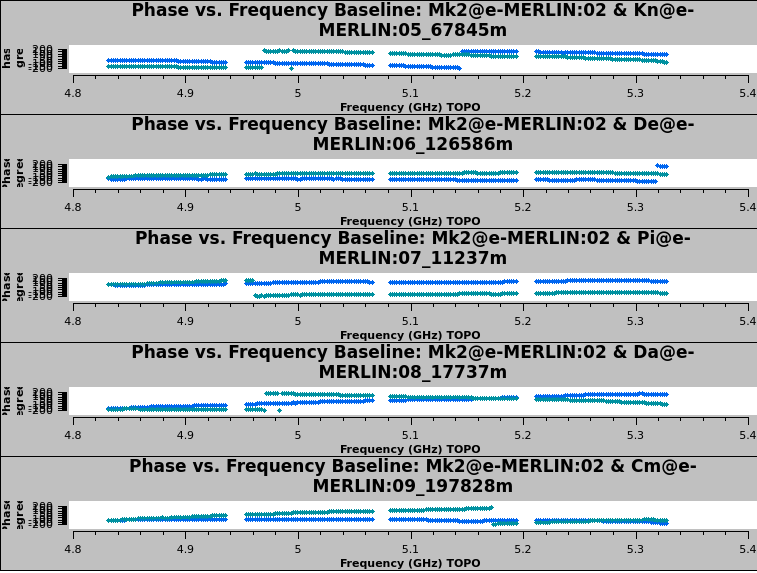

True

Show log 2018-01-23 10:51:18	INFO	PlotMS::params_changed	Updating: REDRAW, MSDATA, CACHE, AXES, CANVAS, DISPLAY, ITERATION, LOG, PLOTMS_OPTIONS.
 2018-01-23 10:51:18	INFO	PlotMS::load_cache	Clearing the existing plotms cache.
 2018-01-23 10:51:18	INFO	PlotMS::load_cache	START Current memory usage: 8115.94 kilobytes.
 2018-01-23 10:51:18	INFO	PlotMS::load_cache	Plot Data Transformations:
 2018-01-23 10:51:18	INFO	PlotMS::load_cache+ Frame = 
 2018-01-23 10:51:18	INFO	PlotMS::load_cache+ VelDef = RADIO
 2018-01-23 10:51:18	INFO	PlotMS::load_cache+ RestFreq = 0 MHz
 2018-01-23 10:51:18	INFO	PlotMS::load_cache+ dX = 0 arcsec
 2018-01-23 10:51:18	INFO	PlotMS::load_cache+ dY = 0 arcsec
 2018-01-23 10:51:18	INFO	PlotMS::load_cache+ formStokes = false
 2018-01-23 10:51:18	INFO	PlotMS::load_cache	Data Averaging: 
 2018-01-23 10:51:18	INFO	PlotMS::load_cache+ Using VECTOR averaging.
 2018-01-23 10:51:18	INFO	PlotMS::load_cache+ Time: 60000 seconds. Scan: false; Field: false
 2018-01-23 10:51:18	INFO	PlotMS::load_cache	Plot Data Calibration:
 2018-01-23 10:51:18	INFO	PlotMS::load_cache+ Use Calibration = 0
 2018-01-23 10:51:18	INFO	PlotMS::load_cache+ Calibration Library = 
 2018-01-23 10:51:18	INFO	PlotMS::load_cache	Caching for the new plot: Phase(18) vs. Frequency(6)...
 2018-01-23 10:51:20	INFO	PlotMS::load_cache	Data selection will yield a total of 2560 plottable points (flagged and unflagged).
 2018-01-23 10:51:20	INFO	PlotMS::load_cache+	The plotms cache will require an estimated 1.8816e-05 GB of memory (7.35 bytes/point).
 2018-01-23 10:51:20	INFO	PlotMS::load_cache+	This is 0.00717993% of the memory avail. to CASA (free=0.262064 GB).
 2018-01-23 10:51:21	INFO	PlotMS::load_cache	Loading chunks......
 2018-01-23 10:51:22	INFO	PlotMS::load_cache	Generating the plot mask.
 2018-01-23 10:51:22	INFO	PlotMS::load_cache	refTime = 2015/05/06/00:00:00.0
 2018-01-23 10:51:22	INFO	PlotMS::load_cache	Finished loading.
 2018-01-23 10:51:22	INFO	PlotMS::load_cache	Setting up iteration indexing (if necessary), and calculating plot ranges.
 2018-01-23 10:51:22	INFO	PlotMS::load_cache	Global ranges:
 2018-01-23 10:51:22	INFO	PlotMS::load_cache+	Frequency: 4.831-5.327 (unflagged); 4.817-5.209 (flagged).
 2018-01-23 10:51:22	INFO	PlotMS::load_cache+	Phase: -179.904-179.797 (unflagged); -172.455-171.477(flagged).
 2018-01-23 10:51:22	INFO	PlotMS::load_cache	Setting up iteration indexing (if necessary), and calculating plot ranges.
 2018-01-23 10:51:22	INFO	PlotMS::load_cache	Found 5 Baseline iterations.
 2018-01-23 10:51:22	INFO	PlotMS::load_cache	Global ranges:
 2018-01-23 10:51:22	INFO	PlotMS::load_cache+	Frequency: 4.831-5.327 (unflagged); 4.817-5.209 (flagged).
 2018-01-23 10:51:22	INFO	PlotMS::load_cache+	Phase: -179.904-179.797 (unflagged); -172.455-171.477(flagged).
 2018-01-23 10:51:22	INFO	PlotMS::plot	Stepping to iteration = 1 (of 5): Baseline: Mk2@e-MERLIN:02 & Kn@e-MERLIN:05_67845m
 2018-01-23 10:51:22	INFO	PlotMS::plot	Stepping to iteration = 2 (of 5): Baseline: Mk2@e-MERLIN:02 & De@e-MERLIN:06_126586m
 2018-01-23 10:51:22	INFO	PlotMS::plot	Stepping to iteration = 3 (of 5): Baseline: Mk2@e-MERLIN:02 & Pi@e-MERLIN:07_11237m
 2018-01-23 10:51:22	INFO	PlotMS::plot	Stepping to iteration = 4 (of 5): Baseline: Mk2@e-MERLIN:02 & Da@e-MERLIN:08_17737m
 2018-01-23 10:51:22	INFO	PlotMS::plot	Stepping to iteration = 5 (of 5): Baseline: Mk2@e-MERLIN:02 & Cm@e-MERLIN:09_197828m
 2018-01-23 10:51:22	INFO	PlotMS::plot	Plotting 452 unflagged points.
 2018-01-23 10:51:18	INFO	PlotMS::load_cache	END Time: +5 seconds. Memory: +856.594 kilobytes.
 2018-01-23 10:51:22	INFO	plotms::::	Plot file /home/jupyter/plotms_temp.png
 2018-01-23 10:51:23	INFO	plotms::::	Exporting the plot.
 2018-01-23 10:51:23	INFO	plotms::::	Calling pm.save
 2018-01-23 10:51:23	INFO	QPExporter::export	START Current memory usage: 8926.89 kilobytes.
 2018-01-23 10:51:23	INFO	QPExporter::export	END Time: +0 seconds. Memory: +5.17188 kilobytes.
 2018-01-23 10:51:23	INFO	PlotMS::plot	Step

In [25]:
#Plot the raw phase against frequency for a bright source.

plotms(vis=multi_source,
    field=bpcal,
    xaxis='frequency',
    gridrows=5,
    gridcols=1,
    iteraxis='baseline',    # Plot multiple baselines on one page
    yaxis='phase',
    antenna='Mk2&*',
    avgtime='60000',                              # Average all times 
    correlation='LL,RR',
    coloraxis='corr',
    showgui=F)

The y-axis spans -200 to +200 deg and some data has a slope of about a full 360 deg across the 512-MHz bandwidth. 

The different correlations are coloured.

**QUESTION 1** What is the apparent delay error this corresponds to? What will be the effect on the amplitudes? [Answer](Answer_1.html)

**QUESTION 2** Delay corrections are calculated relative to a reference antenna which has its phase assumed to be zero, so the corrections factorised per other antenna include any correction due to the refant. Roughly what do you expect the magnitude of the Cm corrections to be? Do you expect the two hands of polarization to have the same sign? [Answer](Answer_2.html)

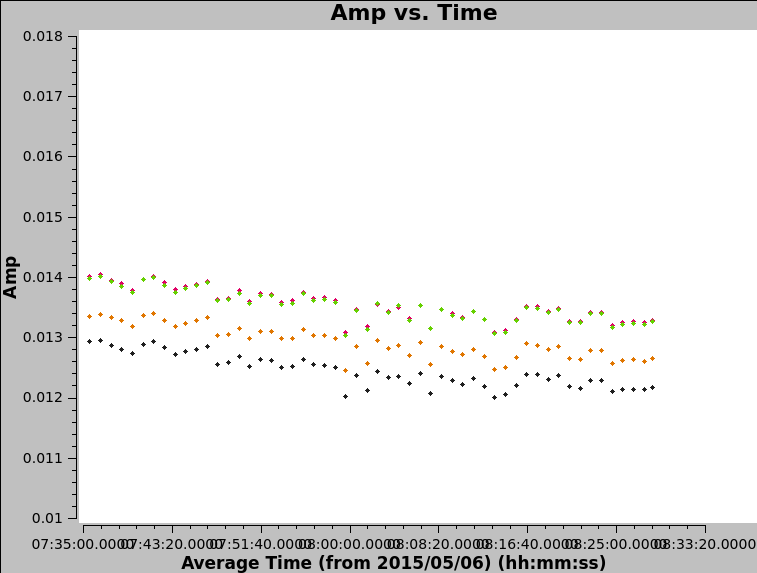

True

Show log 2018-01-23 10:51:26	INFO	PlotMS::params_changed	Updating: REDRAW, MSDATA, CACHE, AXES, CANVAS, DISPLAY, ITERATION, LOG, PLOTMS_OPTIONS.
 2018-01-23 10:51:26	INFO	PlotMS::load_cache	Clearing the existing plotms cache.
 2018-01-23 10:51:26	INFO	PlotMS::load_cache	START Current memory usage: 7569.66 kilobytes.
 2018-01-23 10:51:26	INFO	PlotMS::load_cache	Plot Data Transformations:
 2018-01-23 10:51:26	INFO	PlotMS::load_cache+ Frame = 
 2018-01-23 10:51:26	INFO	PlotMS::load_cache+ VelDef = RADIO
 2018-01-23 10:51:26	INFO	PlotMS::load_cache+ RestFreq = 0 MHz
 2018-01-23 10:51:26	INFO	PlotMS::load_cache+ dX = 0 arcsec
 2018-01-23 10:51:26	INFO	PlotMS::load_cache+ dY = 0 arcsec
 2018-01-23 10:51:26	INFO	PlotMS::load_cache+ formStokes = false
 2018-01-23 10:51:26	INFO	PlotMS::load_cache	Data Averaging: 
 2018-01-23 10:51:26	INFO	PlotMS::load_cache+ Using VECTOR averaging.
 2018-01-23 10:51:26	INFO	PlotMS::load_cache+ Channel: 64 channels
 2018-01-23 10:51:26	INFO	PlotMS::load_cache+ Time: 60 seconds. Scan: false; Field: false
 2018-01-23 10:51:26	INFO	PlotMS::load_cache	Plot Data Calibration:
 2018-01-23 10:51:26	INFO	PlotMS::load_cache+ Use Calibration = 0
 2018-01-23 10:51:26	INFO	PlotMS::load_cache+ Calibration Library = 
 2018-01-23 10:51:26	INFO	PlotMS::load_cache	Caching for the new plot: Amp(17) vs. Time(2)...
 2018-01-23 10:51:29	INFO	PlotMS::load_cache	Data selection will yield a total of 240 plottable points (flagged and unflagged).
 2018-01-23 10:51:29	INFO	PlotMS::load_cache+	The plotms cache will require an estimated 1.488e-05 GB of memory (62 bytes/point).
 2018-01-23 10:51:29	INFO	PlotMS::load_cache+	This is 0.00567341% of the memory avail. to CASA (free=0.262276 GB).
 2018-01-23 10:51:29	INFO	PlotMS::load_cache	Loading chunks......
 2018-01-23 10:51:30	INFO	PlotMS::load_cache	SPW 0: number of channels averaged = 64
 2018-01-23 10:51:30	INFO	PlotMS::load_cache	SPW 1: number of channels averaged = 64
 2018-01-23 10:51:30	INFO	PlotMS::load_cache	SPW 2: number of channels averaged = 64
 2018-01-23 10:51:30	INFO	PlotMS::load_cache	SPW 3: number of channels averaged = 64
 2018-01-23 10:51:30	INFO	PlotMS::load_cache	Generating the plot mask.
 2018-01-23 10:51:30	INFO	PlotMS::load_cache	refTime = 2015/05/06/00:00:00.0
 2018-01-23 10:51:30	INFO	PlotMS::load_cache	Finished loading.
 2018-01-23 10:51:30	INFO	PlotMS::load_cache	Setting up iteration indexing (if necessary), and calculating plot ranges.
 2018-01-23 10:51:30	INFO	PlotMS::load_cache	Global ranges:
 2018-01-23 10:51:30	INFO	PlotMS::load_cache+	Time: 4.93761e+09-4.93762e+09 (unflagged); 4.93761e+09-4.93762e+09 (flagged).
 2018-01-23 10:51:30	INFO	PlotMS::load_cache+	Amp: 0.0120194-0.0140539 (unflagged); 2.3542e-07-0.000806069(flagged).
 2018-01-23 10:51:30	INFO	PlotMS::plot	Plotting 216 unflagged points.
 2018-01-23 10:51:26	INFO	PlotMS::load_cache	END Time: +3 seconds. Memory: +3562.94 kilobytes.
 2018-01-23 10:51:30	INFO	plotms::::	Plot file /home/jupyter/plotms_temp.png
 2018-01-23 10:51:30	INFO	plotms::::	Exporting the plot.
 2018-01-23 10:51:30	INFO	plotms::::	Calling pm.save
 2018-01-23 10:51:30	INFO	QPExporter::export	START Current memory usage: 11137 kilobytes.
 2018-01-23 10:51:30	INFO	QPExporter::export	END Time: +0 seconds. Memory: +1.21875 kilobytes.

In [26]:
#Plot the effect on amplitudes of averaging across a bandpass with phase errors:

plotms(vis=multi_source,
    field=bpcal,
    avgtime='60',antenna='Mk2&Cm',correlation='RR', # 60-sec average, one baseline/pol
    xaxis='time',yaxis='amp',ydatacolumn='data',     # Plot amplitude v. time with fixed y scale 
    plotrange=[-1,-1,0.01,0.018],coloraxis='spw',  
    spw='0~3',avgchannel='64',showgui=F)                       # Average all unflagged channels

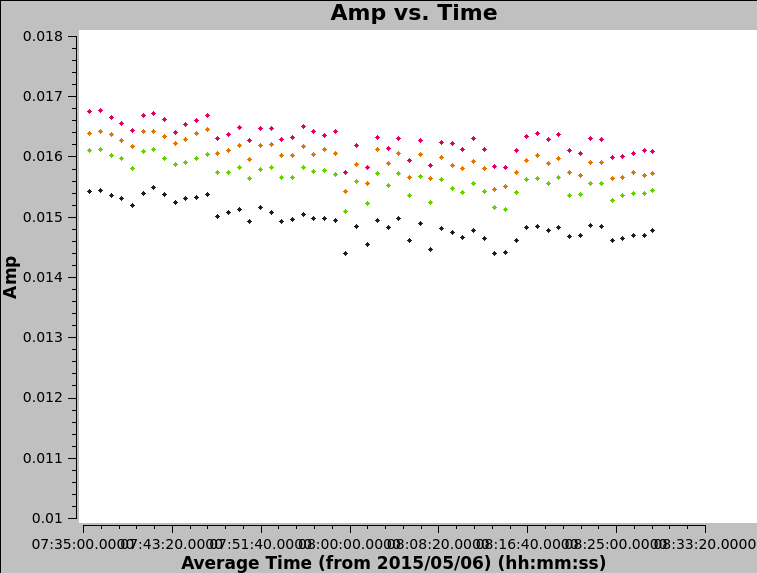

True

Show log 2018-01-23 10:51:35	INFO	PlotMS::params_changed	Updating: REDRAW, MSDATA, CACHE, AXES, CANVAS, DISPLAY, ITERATION, LOG, PLOTMS_OPTIONS.
 2018-01-23 10:51:35	INFO	PlotMS::load_cache	Clearing the existing plotms cache.
 2018-01-23 10:51:35	INFO	PlotMS::load_cache	START Current memory usage: 7592.08 kilobytes.
 2018-01-23 10:51:35	INFO	PlotMS::load_cache	Plot Data Transformations:
 2018-01-23 10:51:35	INFO	PlotMS::load_cache+ Frame = 
 2018-01-23 10:51:35	INFO	PlotMS::load_cache+ VelDef = RADIO
 2018-01-23 10:51:35	INFO	PlotMS::load_cache+ RestFreq = 0 MHz
 2018-01-23 10:51:35	INFO	PlotMS::load_cache+ dX = 0 arcsec
 2018-01-23 10:51:35	INFO	PlotMS::load_cache+ dY = 0 arcsec
 2018-01-23 10:51:35	INFO	PlotMS::load_cache+ formStokes = false
 2018-01-23 10:51:35	INFO	PlotMS::load_cache	Data Averaging: 
 2018-01-23 10:51:35	INFO	PlotMS::load_cache+ Using VECTOR averaging.
 2018-01-23 10:51:35	INFO	PlotMS::load_cache+ Time: 60 seconds. Scan: false; Field: false
 2018-01-23 10:51:35	INFO	PlotMS::load_cache	Plot Data Calibration:
 2018-01-23 10:51:35	INFO	PlotMS::load_cache+ Use Calibration = 0
 2018-01-23 10:51:35	INFO	PlotMS::load_cache+ Calibration Library = 
 2018-01-23 10:51:35	INFO	PlotMS::load_cache	Caching for the new plot: Amp(17) vs. Time(2)...
 2018-01-23 10:51:37	INFO	PlotMS::load_cache	Data selection will yield a total of 240 plottable points (flagged and unflagged).
 2018-01-23 10:51:37	INFO	PlotMS::load_cache+	The plotms cache will require an estimated 1.488e-05 GB of memory (62 bytes/point).
 2018-01-23 10:51:37	INFO	PlotMS::load_cache+	This is 0.0056492% of the memory avail. to CASA (free=0.2634 GB).
 2018-01-23 10:51:38	INFO	PlotMS::load_cache	Loading chunks......
 2018-01-23 10:51:39	INFO	PlotMS::load_cache	Generating the plot mask.
 2018-01-23 10:51:39	INFO	PlotMS::load_cache	refTime = 2015/05/06/00:00:00.0
 2018-01-23 10:51:39	INFO	PlotMS::load_cache	Finished loading.
 2018-01-23 10:51:39	INFO	PlotMS::load_cache	Setting up iteration indexing (if necessary), and calculating plot ranges.
 2018-01-23 10:51:39	INFO	PlotMS::load_cache	Global ranges:
 2018-01-23 10:51:39	INFO	PlotMS::load_cache+	Time: 4.93761e+09-4.93762e+09 (unflagged); 4.93761e+09-4.93762e+09 (flagged).
 2018-01-23 10:51:39	INFO	PlotMS::load_cache+	Amp: 0.0144037-0.0167785 (unflagged); 7.74763e-06-0.00103561(flagged).
 2018-01-23 10:51:39	INFO	PlotMS::plot	Plotting 216 unflagged points.
 2018-01-23 10:51:35	INFO	PlotMS::load_cache	END Time: +4 seconds. Memory: +3495.56 kilobytes.
 2018-01-23 10:51:39	INFO	plotms::::	Plot file /home/jupyter/plotms_temp.png
 2018-01-23 10:51:39	INFO	plotms::::	Exporting the plot.
 2018-01-23 10:51:39	INFO	plotms::::	Calling pm.save
 2018-01-23 10:51:39	INFO	QPExporter::export	START Current memory usage: 11085.1 kilobytes.
 2018-01-23 10:51:39	INFO	QPExporter::export	END Time: +0 seconds. Memory: +1 kilobytes.

In [27]:
#Repeat for a single channel 

plotms(vis=multi_source,field=bpcal,
    avgtime='60',antenna='Mk2&Cm',correlation='RR', # 60-sec average, one baseline/pol
    xaxis='time',yaxis='amp',ydatacolumn='data',        # Plot amplitude v. time with fixed y scale 
    plotrange=[-1,-1,0.01,0.018],coloraxis='spw',  
    spw='0~3:55',showgui=F)                                       # Just one channel per spw

**QUESTION 3** In the plots, which has the higher amplitudes - the channel-averaged data or the single channel? [Answer](Answer_3.html)

Plot the delay for a bright source (below we plot the flux calibrator, 3C84) every 10 min (shown in different colours). 
The slopes are almost parallel showing that the delay error is stable for more than 10 min and the S/N is good (low scatter) so this is a suitable solution interval.


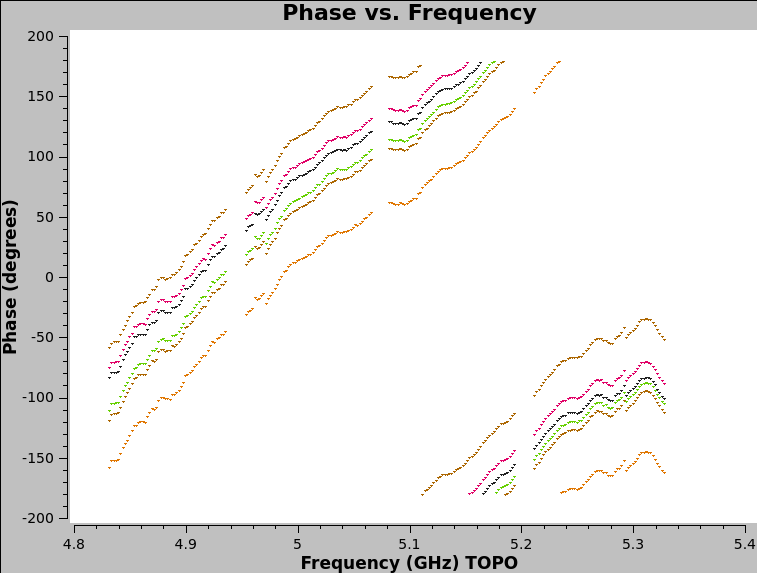

True

Show log 2018-01-23 10:51:43	INFO	PlotMS::params_changed	Updating: REDRAW, MSDATA, CACHE, AXES, CANVAS, DISPLAY, ITERATION, LOG, PLOTMS_OPTIONS.
 2018-01-23 10:51:43	INFO	PlotMS::load_cache	Clearing the existing plotms cache.
 2018-01-23 10:51:43	INFO	PlotMS::load_cache	START Current memory usage: 7609.28 kilobytes.
 2018-01-23 10:51:43	INFO	PlotMS::load_cache	Plot Data Transformations:
 2018-01-23 10:51:43	INFO	PlotMS::load_cache+ Frame = 
 2018-01-23 10:51:43	INFO	PlotMS::load_cache+ VelDef = RADIO
 2018-01-23 10:51:43	INFO	PlotMS::load_cache+ RestFreq = 0 MHz
 2018-01-23 10:51:43	INFO	PlotMS::load_cache+ dX = 0 arcsec
 2018-01-23 10:51:43	INFO	PlotMS::load_cache+ dY = 0 arcsec
 2018-01-23 10:51:43	INFO	PlotMS::load_cache+ formStokes = false
 2018-01-23 10:51:43	INFO	PlotMS::load_cache	Data Averaging: 
 2018-01-23 10:51:43	INFO	PlotMS::load_cache+ Using VECTOR averaging.
 2018-01-23 10:51:43	INFO	PlotMS::load_cache+ Time: 600 seconds. Scan: false; Field: false
 2018-01-23 10:51:43	INFO	PlotMS::load_cache	Plot Data Calibration:
 2018-01-23 10:51:43	INFO	PlotMS::load_cache+ Use Calibration = 0
 2018-01-23 10:51:43	INFO	PlotMS::load_cache+ Calibration Library = 
 2018-01-23 10:51:43	INFO	PlotMS::load_cache	Caching for the new plot: Phase(18) vs. Frequency(6)...
 2018-01-23 10:51:46	INFO	PlotMS::load_cache	Data selection will yield a total of 1536 plottable points (flagged and unflagged).
 2018-01-23 10:51:46	INFO	PlotMS::load_cache+	The plotms cache will require an estimated 2.8704e-05 GB of memory (18.6875 bytes/point).
 2018-01-23 10:51:46	INFO	PlotMS::load_cache+	This is 0.010897% of the memory avail. to CASA (free=0.263412 GB).
 2018-01-23 10:51:46	INFO	PlotMS::load_cache	Loading chunks......
 2018-01-23 10:51:47	INFO	PlotMS::load_cache	Generating the plot mask.
 2018-01-23 10:51:47	INFO	PlotMS::load_cache	refTime = 2015/05/06/00:00:00.0
 2018-01-23 10:51:47	INFO	PlotMS::load_cache	Finished loading.
 2018-01-23 10:51:47	INFO	PlotMS::load_cache	Setting up iteration indexing (if necessary), and calculating plot ranges.
 2018-01-23 10:51:47	INFO	PlotMS::load_cache	Global ranges:
 2018-01-23 10:51:47	INFO	PlotMS::load_cache+	Frequency: 4.831-5.327 (unflagged); 4.817-5.209 (flagged).
 2018-01-23 10:51:47	INFO	PlotMS::load_cache+	Phase: -179.717-179.951 (unflagged); -172.286-169.929(flagged).
 2018-01-23 10:51:47	INFO	PlotMS::plot	Plotting 1356 unflagged points.
 2018-01-23 10:51:43	INFO	PlotMS::load_cache	END Time: +3 seconds. Memory: +517.625 kilobytes.
 2018-01-23 10:51:47	INFO	plotms::::	Plot file /home/jupyter/plotms_temp.png
 2018-01-23 10:51:48	INFO	plotms::::	Exporting the plot.
 2018-01-23 10:51:48	INFO	plotms::::	Calling pm.save
 2018-01-23 10:51:48	INFO	QPExporter::export	START Current memory usage: 8132.16 kilobytes.
 2018-01-23 10:51:48	INFO	QPExporter::export	END Time: +0 seconds. Memory: +1 kilobytes.

In [28]:
plotms(vis=multi_source,
    field=bpcal,
    xaxis='frequency',
    yaxis='phase',
    ydatacolumn='data',
    antenna='Mk2&Cm',       # Just one baseline for clarity
    avgtime='600',          # Average every 10 min
    correlation='RR',       # Just one pol for clarity 
    coloraxis='time',       # Colour each 10-min differently
    showgui=F)


*Notes:*

The phase of the reference antenna is taken as the origin of phase and by default a model of a point source at the phase centre is used. This should have zero phase offset on all baselines and {{gaincal}} is used to calculated the corrections needed to add to the data to achieve this, factorised per antenna. It is known that 0319+415 and 1407+284 are point-like for short scans on these baselines at 5 GHz. 1331+305 isn't but the compact core is bright enough to use as a starting estimate. We hope that the phase ref is also pointlike, this will be checked later.

#### Deriving solutions

- gaincal produces a table of corrections which, when applied to the data, should produce flat phases as a function of frequency.

In [29]:
os.system('rm -rf all_avg.K')                  # Remove any old version
gaincal(vis=multi_source,
    gaintype='K',                                   # Delay calibration 
    field= '{},{},{},{}'.format(phref,fluxcal,bpcal,bpcal2),   # All calibration sources
    caltable='all_avg.K',                           # Output table containing corrections
    spw='0~3',
    solint='600',                                   # 10-min solution interval
    refant='Mk2',                                   # Phase of this antenna set to origin
    minblperant=2,                                  # For each antenna and solint, require solutions on 
    minsnr=2)     

Show log 2018-01-23 10:51:58	INFO	gaincal::calibrater::open	Opening MS: all_avg.ms for calibration.
 2018-01-23 10:51:58	INFO	gaincal::Calibrater::	Initializing nominal selection to the whole MS.
 2018-01-23 10:51:58	INFO	gaincal::calibrater::setdata	Beginning selectvis--(MSSelection version)-------
 2018-01-23 10:51:58	INFO	gaincal::calibrater::reset	Reseting solve/apply state
 2018-01-23 10:51:58	INFO	gaincal::Calibrater::selectvis	Performing selection on MeasurementSet
 2018-01-23 10:51:58	INFO	gaincal::Calibrater::selectvis+ Selecting on spw: '0~3'
 2018-01-23 10:51:58	INFO	gaincal::Calibrater::selectvis+ Selecting on field: '1302+5748,1331+305,0319+415,1407+284'
 2018-01-23 10:51:59	INFO	gaincal::Calibrater::selectvis	By selection 747300 rows are reduced to 338100
 2018-01-23 10:51:59	INFO	gaincal::Calibrater::selectvis	Frequency selection: 
 2018-01-23 10:51:59	INFO	gaincal::Calibrater::selectvis	. Spw 0:0~63 (64 channels, step by 1)
 2018-01-23 10:51:59	INFO	gaincal::Calibrater::selectvis+	. Spw 1:0~63 (64 channels, step by 1)
 2018-01-23 10:51:59	INFO	gaincal::Calibrater::selectvis+	. Spw 2:0~63 (64 channels, step by 1)
 2018-01-23 10:51:59	INFO	gaincal::Calibrater::selectvis+	. Spw 3:0~63 (64 channels, step by 1)
 2018-01-23 10:51:59	INFO	gaincal::calibrater::setdata	chanmode=none nchan=1 start=0 step=1 mStart='0km/s' mStep='0km/s' msSelect=''
 2018-01-23 10:51:59	INFO	gaincal::calibrater::setsolve	Beginning setsolve--(MSSelection version)-------
 2018-01-23 10:51:59	INFO	gaincal::Calibrater::setsolve	Arranging to SOLVE:
 2018-01-23 10:51:59	INFO	gaincal::Calibrater::setsolve	. K Jones: table=all_avg.K append=false solint=600s refant='Mk2' minsnr=2 apmode=AP solnorm=false
 2018-01-23 10:51:59	INFO	gaincal::calibrater::solve	Beginning solve-----------------------------
 2018-01-23 10:51:59	INFO	gaincal::Calibrater::solve	The following calibration terms are arranged for apply:
 2018-01-23 10:51:59	INFO	gaincal::Calibrater::solve	. (None)
 2018-01-23 10:51:59	INFO	gaincal::Calibrater::solve	The following calibration term is arranged for solve:
 2018-01-23 10:51:59	INFO	gaincal::Calibrater::solve	. K Jones: table=all_avg.K append=false solint=600s refant='Mk2' minsnr=2 apmode=AP solnorm=false
 2018-01-23 10:51:59	INFO	gaincal::Calibrater::solve	Solving for K Jones
 2018-01-23 10:51:59	INFO	gaincal::::	For solint = 600s, found 340 solution intervals.
 2018-01-23 10:52:04	INFO	gaincal::Calibrater::solve Found good K Jones solutions in 260 slots.
 2018-01-23 10:52:04	INFO	gaincal::::	Writing solutions to table: all_avg.K
 2018-01-23 10:52:06	INFO	gaincal::calibrater::solve	Finished solving.
 2018-01-23 10:52:06	INFO	gaincal::::	Calibration solve statistics per spw: (expected/attempted/succeeded):
 2018-01-23 10:52:06	INFO	gaincal:::: Spw 0: 85/65/65
 2018-01-23 10:52:06	INFO	gaincal:::: Spw 1: 85/65/65
 2018-01-23 10:52:06	INFO	gaincal:::: Spw 2: 85/65/65
 2018-01-23 10:52:06	INFO	gaincal:::: Spw 3: 85/65/65

Inspect the solutions. Are they of the magnitude you expect? They are stable in time, showing that the phase ref solutions can be applied to the target

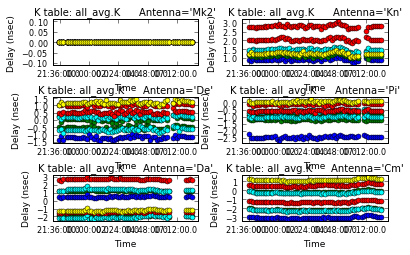

Show log 2018-01-23 10:52:17	INFO	plotcal::tableplot::setgui	Switching to NO-GUI mode. All current plots will be reset.
 2018-01-23 10:52:17	INFO	plotcal::plotcal::createCalTab Detected a NewCalTable!
 2018-01-23 10:52:18	INFO	plotants::::	Now get the data
 2018-01-23 10:52:18	INFO	plotants::::	Done Processing data ... 
 2018-01-23 10:52:18	INFO	plotants::::	Now get the data
 2018-01-23 10:52:18	INFO	plotants::::	Done Processing data ... 
 2018-01-23 10:52:18	INFO	plotants::::	Now get the data
 2018-01-23 10:52:18	INFO	plotants::::	Done Processing data ... 
 2018-01-23 10:52:18	INFO	plotants::::	Now get the data
 2018-01-23 10:52:18	INFO	plotants::::	Done Processing data ... 
 2018-01-23 10:52:18	INFO	plotants::::	Now get the data
 2018-01-23 10:52:18	INFO	plotants::::	Done Processing data ... 
 2018-01-23 10:52:18	INFO	plotants::::	Now get the data
 2018-01-23 10:52:18	INFO	plotants::::	Done Processing data ...

In [31]:
plotcal(caltable='all_avg.K',
    xaxis='time',yaxis='delay',             # Plot delay against time
    subplot=321, iteration='antenna',       # Each antenna in a separate pane, coloured by spw
    showgui=F)

## 4. Setting the flux scale 

1331+305 (= 3C286) is an almost non-variable radio galaxy and its total flux density is very well known as a function of time and frequency ([Perley & Butler 2013]((http://adsabs.harvard.edu/abs/2013ApJS..204...19P)) . It is somewhat resolved by e-MERLIN, so we use a model made from a ~12-hr observation centred on 5.5 GHz. This is scaled to the current observing frequency range (around 5 GHz) using {{setjy}} which derives the appropriate total flux density, spectral index and curvature using parameters from Perley & Butler (2013). However, a few percent of the flux is resolved-out by e-MERLIN; the simplest way (at present) to account for this is later to scale the fluxes derived for the other calibration sources by 0.938 (based on calculations for e-MERLIN by Fenech et al.).

The model is a set of clean components (see Imaging tutorial) and setjy enters these in the Measurement Set so that their Fourier transform can be used as a uv-plane model to compare later with the actual visibility amplitudes.

In [32]:
setjy(vis=multi_source,
    field=fluxcal,
    standard='Perley-Butler 2013',
    model='3C286_C.clean.model.tt0')

{'2': {'0': {'fluxd': array([ 7.37608099,  0.        ,  0.        ,  0.        ])},
  '1': {'fluxd': array([ 7.25162458,  0.        ,  0.        ,  0.        ])},
  '2': {'fluxd': array([ 7.13195324,  0.        ,  0.        ,  0.        ])},
  '3': {'fluxd': array([ 7.01678133,  0.        ,  0.        ,  0.        ])},
  'fieldName': '1331+305'},
 'format': "{field Id: {spw Id: {fluxd: [I,Q,U,V] in Jy}, 'fieldName':field name }}"}

Show log 2018-01-23 10:52:31	INFO	setjy::::	{'field': '1331+305'}
 2018-01-23 10:52:31	INFO	Imager::open() Opening MeasurementSet /home/jupyter/all_avg.ms
 2018-01-23 10:52:31	INFO	setjy::::	Using /home/jupyter/3C286_C.clean.model.tt0 for modimage.
 2018-01-23 10:52:32	INFO	setjy::::	CASA Version 0.4.7 (REL r00)
 2018-01-23 10:52:32	INFO	setjy:::: Tagged on: 2017-02-20 15:48:56 UTC
 2018-01-23 10:52:34	INFO	imager::setjy()	Using channel dependent flux densities
 2018-01-23 10:52:34	INFO	imager::data selection	Selected 40500 out of 747300 rows.
 2018-01-23 10:52:34	INFO	imager::setjy() 1331+305 (fld ind 2) spw 0 [I=7.3761, Q=0, U=0, V=0] Jy @ 4.817e+09Hz, (Perley-Butler 2013)
 2018-01-23 10:52:34	INFO	imager::setjy() 1331+305 (fld ind 2) spw 1 [I=7.2516, Q=0, U=0, V=0] Jy @ 4.945e+09Hz, (Perley-Butler 2013)
 2018-01-23 10:52:34	INFO	imager::setjy() 1331+305 (fld ind 2) spw 2 [I=7.132, Q=0, U=0, V=0] Jy @ 5.073e+09Hz, (Perley-Butler 2013)
 2018-01-23 10:52:35	INFO	imager::setjy() 1331+305 (fld ind 2) spw 3 [I=7.0168, Q=0, U=0, V=0] Jy @ 5.201e+09Hz, (Perley-Butler 2013)
 2018-01-23 10:52:35	SEVERE	MeasTable::dUTC(Double) (file /usr/local/casa/casacore/measures/Measures/MeasTable.cc, line 4396)	Leap second table TAI_UTC seems out-of-date. 
 2018-01-23 10:52:35	SEVERE	MeasTable::dUTC(Double) (file /usr/local/casa/casacore/measures/Measures/MeasTable.cc, line 4396)+	Until the table is updated (see the CASA documentation or your system admin),
 2018-01-23 10:52:35	SEVERE	MeasTable::dUTC(Double) (file /usr/local/casa/casacore/measures/Measures/MeasTable.cc, line 4396)+	times and coordinates derived from UTC could be wrong by 1s or more.
 2018-01-23 10:52:35	INFO	imager::setjy()	Using model image /home/jupyter/3C286_C.clean.model.tt0
 2018-01-23 10:52:35	INFO	imager::setjy()	Scaling spw(s) [0, 1, 2, 3]'s model image by channel to I = 7.37702, 7.13099, 6.90495 Jy @(4.81605e+09, 5.07405e+09, 5.33005e+09)Hz (LSRK) for visibility prediction (a few representative values are shown).
 2018-01-23 10:52:36	INFO	imager::setjy()	The model image's reference pixel is 1.03671e-06 arcsec from 1331+305's phase center.
 2018-01-23 10:52:36	INFO	imager::setjy()	Will clear any existing model with matching field=1331+305 and spw=*
 2018-01-23 10:52:36	INFO Clearing model records in MS header for selected fields.
 2018-01-23 10:52:36	INFO 1331+305 (id = 2) not found.
 2018-01-23 10:52:36	INFO	imager::data selection	Selected 10125 out of 747300 rows.
 2018-01-23 10:52:36	INFO	imager::data selection	Selected 10125 out of 747300 rows.
 2018-01-23 10:52:37	INFO	imager::data selection	Selected 10125 out of 747300 rows.
 2018-01-23 10:52:37	INFO	imager::data selection	Selected 10125 out of 747300 rows.

By default, setjy scales the model for each channel, as seen if you plot the model amplitudes against uv distance, coloured by spectral window. The model only appears for the baselines present for the short time interval for which 1331+305 was observed here

## 5. Initial Bandpass Calibration

We have a Catch 22 situation: in order to derive good time-dependent corrections we need to average amplitude as well as phase in frequency, but in order to average in frequency we need the phase to be flat in time and the amplitude to have the correct spectral index. So we derive initial time-dependent solutions for the bandpass calibration sources, but discard these after they have been applied to derive the initial bandpass solutions. 

### Time-dependent pre-calibration to prepare for bandpass calibration

Estimate the time-averaging interval for phase by plotting a single channel again.

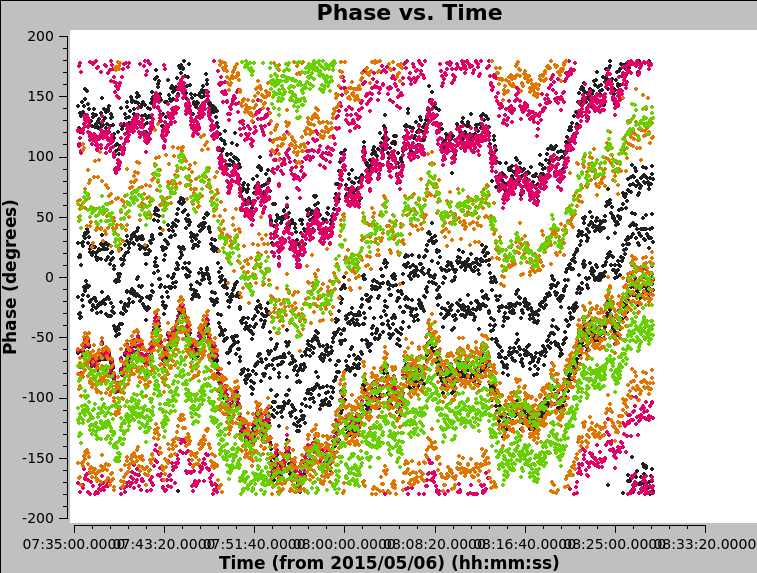

True

Show log 2018-01-23 10:52:44	INFO	PlotMS::params_changed	Updating: REDRAW, MSDATA, CACHE, AXES, CANVAS, DISPLAY, ITERATION, LOG, PLOTMS_OPTIONS.
 2018-01-23 10:52:44	INFO	PlotMS::load_cache	Clearing the existing plotms cache.
 2018-01-23 10:52:44	INFO	PlotMS::load_cache	START Current memory usage: 7626.61 kilobytes.
 2018-01-23 10:52:44	INFO	PlotMS::load_cache	Plot Data Transformations:
 2018-01-23 10:52:44	INFO	PlotMS::load_cache+ Frame = 
 2018-01-23 10:52:44	INFO	PlotMS::load_cache+ VelDef = RADIO
 2018-01-23 10:52:44	INFO	PlotMS::load_cache+ RestFreq = 0 MHz
 2018-01-23 10:52:44	INFO	PlotMS::load_cache+ dX = 0 arcsec
 2018-01-23 10:52:44	INFO	PlotMS::load_cache+ dY = 0 arcsec
 2018-01-23 10:52:44	INFO	PlotMS::load_cache+ formStokes = false
 2018-01-23 10:52:44	INFO	PlotMS::load_cache	Data Averaging: None.
 2018-01-23 10:52:44	INFO	PlotMS::load_cache	Plot Data Calibration:
 2018-01-23 10:52:44	INFO	PlotMS::load_cache+ Use Calibration = 0
 2018-01-23 10:52:44	INFO	PlotMS::load_cache+ Calibration Library = 
 2018-01-23 10:52:44	INFO	PlotMS::load_cache	Caching for the new plot: Phase(18) vs. Time(2)...
 2018-01-23 10:52:47	INFO	PlotMS::load_cache	Data selection will yield a total of 14400 plottable points (flagged and unflagged).
 2018-01-23 10:52:47	INFO	PlotMS::load_cache+	The plotms cache will require an estimated 0.0003312 GB of memory (23 bytes/point).
 2018-01-23 10:52:47	INFO	PlotMS::load_cache+	This is 0.144043% of the memory avail. to CASA (free=0.229932 GB).
 2018-01-23 10:52:47	INFO	PlotMS::load_cache	Loading chunks......
 2018-01-23 10:52:48	INFO	PlotMS::load_cache	Generating the plot mask.
 2018-01-23 10:52:48	INFO	PlotMS::load_cache	refTime = 2015/05/06/00:00:00.0
 2018-01-23 10:52:48	INFO	PlotMS::load_cache	Finished loading.
 2018-01-23 10:52:48	INFO	PlotMS::load_cache	Setting up iteration indexing (if necessary), and calculating plot ranges.
 2018-01-23 10:52:48	INFO	PlotMS::load_cache	Global ranges:
 2018-01-23 10:52:48	INFO	PlotMS::load_cache+	Time: 4.93761e+09-4.93762e+09 (unflagged); 4.93761e+09-4.93762e+09 (flagged).
 2018-01-23 10:52:48	INFO	PlotMS::load_cache+	Phase: -180-179.999 (unflagged); -179.784-179.983(flagged).
 2018-01-23 10:52:48	INFO	PlotMS::plot	Plotting 12768 unflagged points.
 2018-01-23 10:52:44	INFO	PlotMS::load_cache	END Time: +5 seconds. Memory: +50385.6 kilobytes.
 2018-01-23 10:52:48	INFO	plotms::::	Plot file /home/jupyter/plotms_temp.png
 2018-01-23 10:52:49	INFO	plotms::::	Exporting the plot.
 2018-01-23 10:52:49	INFO	plotms::::	Calling pm.save
 2018-01-23 10:52:49	INFO	QPExporter::export	START Current memory usage: 58013.9 kilobytes.
 2018-01-23 10:52:49	INFO	QPExporter::export	END Time: +1 seconds. Memory: +1.125 kilobytes.

In [33]:
plotms(vis=multi_source,
    field=bpcal,               # Plot bright, point-like source
    spw='0~3:55',
    antenna='Mk2&Cm',                 # Single channel, long baseline likely to have fastest phase
    xaxis='time',
    yaxis='phase',
    ydatacolumn='data', # Plot phase against time, no averaging
    coloraxis='spw',
    customsymbol=True,
    symbolsize=5,
    symbolshape='circle',
    showgui=F)

The integration-to-integration scatter in the plot is noise (mostly instrumental) which cannot be removed but the longer-term wiggles are mainly due to the atmosphere and we want to derive corrections to reduce these to about the level of the noise or at least to less than 5-10 deg. The longer a solution interval, the better the S/N but the interval has to be short enough not to average over the wiggles.

QUESTION 4 The plot shows 4 spws. What other effect, apart from atmospheric phase errors, will be solved by calibrating against a point model at the phase centre? [Answer](Answer_4.html)

### Deriving Phase solutions

In [34]:
os.system('rm -rf bpcals_precal.p1')
gaincal(vis=multi_source,
    calmode='p',                    # Solve for phase only
    field=bpcals,                   # Two sources suitable for bandpass calibration were observed
    caltable='bpcals_precal.p1',    # The output solution table
    solint=120,                     # Enter a suitable solution interval (in seconds)
    refant='Mk2',
    minblperant=2, minsnr=2,
    gaintable='all_avg.K')          # Apply the delay solutions to allow averaging phase across the band

Show log 2018-01-23 10:57:29	INFO	gaincal::calibrater::open	Opening MS: all_avg.ms for calibration.
 2018-01-23 10:57:29	INFO	gaincal::Calibrater::	Initializing nominal selection to the whole MS.
 2018-01-23 10:57:30	INFO	gaincal::calibrater::setdata	Beginning selectvis--(MSSelection version)-------
 2018-01-23 10:57:30	INFO	gaincal::calibrater::reset	Reseting solve/apply state
 2018-01-23 10:57:30	INFO	gaincal::Calibrater::selectvis	Performing selection on MeasurementSet
 2018-01-23 10:57:30	INFO	gaincal::Calibrater::selectvis+ Selecting on field: '0319+415,1407+284'
 2018-01-23 10:57:30	INFO	gaincal::Calibrater::selectvis	By selection 747300 rows are reduced to 92700
 2018-01-23 10:57:30	INFO	gaincal::Calibrater::selectvis	Frequency selection: Selecting all channels in all spws.
 2018-01-23 10:57:30	INFO	gaincal::calibrater::setdata	chanmode=none nchan=1 start=0 step=1 mStart='0km/s' mStep='0km/s' msSelect=''
 2018-01-23 10:57:30	INFO	gaincal::calibrater::setapply	Beginning setapply--(MSSelection version)-------
 2018-01-23 10:57:30	INFO	gaincal::Calibrater::setapply(type, applypar)	Arranging to APPLY:
 2018-01-23 10:57:30	INFO	gaincal:::: (K Jones: Enforcing calWt()=False for phase/delay-like terms)
 2018-01-23 10:57:30	INFO	gaincal::Calibrater::setapply(type, applypar)	. K Jones: table=all_avg.K select= interp=linear spwmap=[-1] calWt=false
 2018-01-23 10:57:30	INFO	gaincal::calibrater::setsolve	Beginning setsolve--(MSSelection version)-------
 2018-01-23 10:57:30	INFO	gaincal::Calibrater::setsolve	Arranging to SOLVE:
 2018-01-23 10:57:30	INFO	gaincal::Calibrater::setsolve	. G Jones: table=bpcals_precal.p1 append=false solint=120s refant='Mk2' minsnr=2 apmode=P solnorm=false
 2018-01-23 10:57:30	INFO	gaincal::calibrater::solve	Beginning solve-----------------------------
 2018-01-23 10:57:30	INFO	gaincal::Calibrater::solve	The following calibration terms are arranged for apply:
 2018-01-23 10:57:30	INFO	gaincal::Calibrater::solve	. K Jones: table=all_avg.K select= interp=linear spwmap=[-1] calWt=false
 2018-01-23 10:57:30	INFO	gaincal::Calibrater::solve	The following calibration term is arranged for solve:
 2018-01-23 10:57:30	INFO	gaincal::Calibrater::solve	. G Jones: table=bpcals_precal.p1 append=false solint=120s refant='Mk2' minsnr=2 apmode=P solnorm=false
 2018-01-23 10:57:30	INFO	gaincal::Calibrater::solve	Solving for G Jones
 2018-01-23 10:57:30	INFO	gaincal::::	For solint = 120s, found 208 solution intervals.
 2018-01-23 10:57:33	INFO	gaincal::Calibrater::solve Found good G Jones solutions in 200 slots.
 2018-01-23 10:57:33	INFO	gaincal::::	Applying refant: Mk2
 2018-01-23 10:57:33	INFO	gaincal::::	Enforcing apmode on solutions.
 2018-01-23 10:57:33	INFO	gaincal::::	Writing solutions to table: bpcals_precal.p1
 2018-01-23 10:57:35	INFO	gaincal::calibrater::solve	Finished solving.
 2018-01-23 10:57:35	INFO	gaincal::::	Calibration solve statistics per spw: (expected/attempted/succeeded):
 2018-01-23 10:57:35	INFO	gaincal:::: Spw 0: 52/50/50
 2018-01-23 10:57:35	INFO	gaincal:::: Spw 1: 52/50/50
 2018-01-23 10:57:35	INFO	gaincal:::: Spw 2: 52/50/50
 2018-01-23 10:57:35	INFO	gaincal:::: Spw 3: 52/50/50

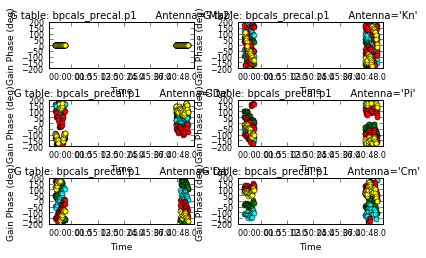

Show log 2018-01-23 10:57:38	INFO	plotcal::tableplot::setgui	Switching to GUI mode. All current plots will be reset.
 2018-01-23 10:57:38	INFO	plotcal::plotcal::createCalTab Detected a NewCalTable!
 2018-01-23 10:57:38	INFO	plotants::::	Now get the data
 2018-01-23 10:57:38	INFO	plotants::::	Done Processing data ... 
 2018-01-23 10:57:38	INFO	plotants::::	Now get the data
 2018-01-23 10:57:38	INFO	plotants::::	Done Processing data ... 
 2018-01-23 10:57:38	INFO	plotants::::	Now get the data
 2018-01-23 10:57:38	INFO	plotants::::	Done Processing data ... 
 2018-01-23 10:57:38	INFO	plotants::::	Now get the data
 2018-01-23 10:57:38	INFO	plotants::::	Done Processing data ... 
 2018-01-23 10:57:38	INFO	plotants::::	Now get the data
 2018-01-23 10:57:38	INFO	plotants::::	Done Processing data ... 
 2018-01-23 10:57:38	INFO	plotants::::	Now get the data
 2018-01-23 10:57:39	INFO	plotants::::	Done Processing data ...

In [35]:
#Check the solutions. Each spw should have a coherent set of solutions, not just noise.

plotcal(caltable='bpcals_precal.p1',
    xaxis='time',
    yaxis='phase',
    subplot=321,
    plotrange=[-1,-1,-180,180],
    iteration='antenna',
    showgui=T)

### Deriving Amplitude solutions

The previous plot of amplitude against time (In 20 and 21) showed that the uncorrected amplitudes have only a slow systematic slope with time, so a longer solution interval can be used, minimising phase noise.

**QUESTION 5** Why solve for phase separately before solving for amplitude? [Answer](Answer_5.html)

In [36]:
os.system('rm -rf bpcals_precal.ap1')
gaincal(vis=multi_source,
    calmode='ap',                    # Solve for amplitude and phase
    field=bpcal,
    caltable='bpcals_precal.ap1',    # Output solution table
    solint=120,                   # Longer solution interval
    solnorm=T,                       # Normalise the amplitude solutions,
    refant='Mk2',                    # i.e. individual solutions differ but the product
    minblperant=2,minsnr=2,          # is unity so that the overall flux scale is not affected 
    gaintable=['all_avg.K','bpcals_precal.p1']) # Apply the existing delay and phase solutions

Show log 2018-01-23 10:57:46	INFO	gaincal::calibrater::open	Opening MS: all_avg.ms for calibration.
 2018-01-23 10:57:46	INFO	gaincal::Calibrater::	Initializing nominal selection to the whole MS.
 2018-01-23 10:57:46	INFO	gaincal::calibrater::setdata	Beginning selectvis--(MSSelection version)-------
 2018-01-23 10:57:46	INFO	gaincal::calibrater::reset	Reseting solve/apply state
 2018-01-23 10:57:46	INFO	gaincal::Calibrater::selectvis	Performing selection on MeasurementSet
 2018-01-23 10:57:46	INFO	gaincal::Calibrater::selectvis+ Selecting on field: '0319+415'
 2018-01-23 10:57:46	INFO	gaincal::Calibrater::selectvis	By selection 747300 rows are reduced to 54000
 2018-01-23 10:57:46	INFO	gaincal::Calibrater::selectvis	Frequency selection: Selecting all channels in all spws.
 2018-01-23 10:57:46	INFO	gaincal::calibrater::setdata	chanmode=none nchan=1 start=0 step=1 mStart='0km/s' mStep='0km/s' msSelect=''
 2018-01-23 10:57:46	INFO	gaincal::calibrater::setapply	Beginning setapply--(MSSelection version)-------
 2018-01-23 10:57:46	INFO	gaincal::Calibrater::setapply(type, applypar)	Arranging to APPLY:
 2018-01-23 10:57:46	INFO	gaincal:::: (K Jones: Enforcing calWt()=False for phase/delay-like terms)
 2018-01-23 10:57:46	INFO	gaincal::Calibrater::setapply(type, applypar)	. K Jones: table=all_avg.K select= interp=linear spwmap=[-1] calWt=false
 2018-01-23 10:57:46	INFO	gaincal::calibrater::setapply	Beginning setapply--(MSSelection version)-------
 2018-01-23 10:57:46	INFO	gaincal::Calibrater::setapply(type, applypar)	Arranging to APPLY:
 2018-01-23 10:57:47	INFO	gaincal::Calibrater::setapply(type, applypar)	. G Jones: table=bpcals_precal.p1 select= interp=linear spwmap=[-1] calWt=true
 2018-01-23 10:57:47	INFO	gaincal::calibrater::setsolve	Beginning setsolve--(MSSelection version)-------
 2018-01-23 10:57:47	INFO	gaincal::Calibrater::setsolve	Arranging to SOLVE:
 2018-01-23 10:57:47	INFO	gaincal::Calibrater::setsolve	. G Jones: table=bpcals_precal.ap1 append=false solint=120s refant='Mk2' minsnr=2 apmode=AP solnorm=true
 2018-01-23 10:57:47	INFO	gaincal::calibrater::solve	Beginning solve-----------------------------
 2018-01-23 10:57:47	INFO	gaincal::Calibrater::solve	The following calibration terms are arranged for apply:
 2018-01-23 10:57:47	INFO	gaincal::Calibrater::solve	. K Jones: table=all_avg.K select= interp=linear spwmap=[-1] calWt=false
 2018-01-23 10:57:47	INFO	gaincal::Calibrater::solve	. G Jones: table=bpcals_precal.p1 select= interp=linear spwmap=[-1] calWt=true
 2018-01-23 10:57:47	INFO	gaincal::Calibrater::solve	The following calibration term is arranged for solve:
 2018-01-23 10:57:47	INFO	gaincal::Calibrater::solve	. G Jones: table=bpcals_precal.ap1 append=false solint=120s refant='Mk2' minsnr=2 apmode=AP solnorm=true
 2018-01-23 10:57:47	INFO	gaincal::Calibrater::solve	Solving for G Jones
 2018-01-23 10:57:47	INFO	gaincal::::	For solint = 120s, found 120 solution intervals.
 2018-01-23 10:57:48	INFO	gaincal::Calibrater::solve Found good G Jones solutions in 112 slots.
 2018-01-23 10:57:48	INFO	gaincal::::	Applying refant: Mk2
 2018-01-23 10:57:48	INFO	gaincal::::	Normalizing solution amplitudes per spw.
 2018-01-23 10:57:48	INFO	gaincal::::	Writing solutions to table: bpcals_precal.ap1
 2018-01-23 10:57:50	INFO	gaincal::calibrater::solve	Finished solving.
 2018-01-23 10:57:50	INFO	gaincal::::	Calibration solve statistics per spw: (expected/attempted/succeeded):
 2018-01-23 10:57:50	INFO	gaincal:::: Spw 0: 30/28/28
 2018-01-23 10:57:50	INFO	gaincal:::: Spw 1: 30/28/28
 2018-01-23 10:57:50	INFO	gaincal:::: Spw 2: 30/28/28
 2018-01-23 10:57:50	INFO	gaincal:::: Spw 3: 30/28/28

In [37]:
gaincal(vis=multi_source,
    calmode='ap',                    # Solve for amplitude and phase
    field=bpcal2,
    caltable='bpcals_precal.ap1',    # Output solution table
    solint=120,                   # Longer solution interval
    solnorm=T,                       # Normalise the amplitude solutions,
    refant='Mk2',                    # i.e. individual solutions differ but the product
    minblperant=2,minsnr=2,          # is unity so that the overall flux scale is not affected 
    gaintable=['all_avg.K','bpcals_precal.p1'], # Apply the existing delay and phase solutions
    append=T)                                   # Add solutions to existing table

Show log 2018-01-23 10:58:00	INFO	gaincal::calibrater::open	Opening MS: all_avg.ms for calibration.
 2018-01-23 10:58:00	INFO	gaincal::Calibrater::	Initializing nominal selection to the whole MS.
 2018-01-23 10:58:00	INFO	gaincal::calibrater::setdata	Beginning selectvis--(MSSelection version)-------
 2018-01-23 10:58:00	INFO	gaincal::calibrater::reset	Reseting solve/apply state
 2018-01-23 10:58:00	INFO	gaincal::Calibrater::selectvis	Performing selection on MeasurementSet
 2018-01-23 10:58:00	INFO	gaincal::Calibrater::selectvis+ Selecting on field: '1407+284'
 2018-01-23 10:58:00	INFO	gaincal::Calibrater::selectvis	By selection 747300 rows are reduced to 38700
 2018-01-23 10:58:00	INFO	gaincal::Calibrater::selectvis	Frequency selection: Selecting all channels in all spws.
 2018-01-23 10:58:00	INFO	gaincal::calibrater::setdata	chanmode=none nchan=1 start=0 step=1 mStart='0km/s' mStep='0km/s' msSelect=''
 2018-01-23 10:58:00	INFO	gaincal::calibrater::setapply	Beginning setapply--(MSSelection version)-------
 2018-01-23 10:58:00	INFO	gaincal::Calibrater::setapply(type, applypar)	Arranging to APPLY:
 2018-01-23 10:58:00	INFO	gaincal:::: (K Jones: Enforcing calWt()=False for phase/delay-like terms)
 2018-01-23 10:58:00	INFO	gaincal::Calibrater::setapply(type, applypar)	. K Jones: table=all_avg.K select= interp=linear spwmap=[-1] calWt=false
 2018-01-23 10:58:00	INFO	gaincal::calibrater::setapply	Beginning setapply--(MSSelection version)-------
 2018-01-23 10:58:00	INFO	gaincal::Calibrater::setapply(type, applypar)	Arranging to APPLY:
 2018-01-23 10:58:00	INFO	gaincal::Calibrater::setapply(type, applypar)	. G Jones: table=bpcals_precal.p1 select= interp=linear spwmap=[-1] calWt=true
 2018-01-23 10:58:00	INFO	gaincal::calibrater::setsolve	Beginning setsolve--(MSSelection version)-------
 2018-01-23 10:58:00	INFO	gaincal::Calibrater::setsolve	Arranging to SOLVE:
 2018-01-23 10:58:00	INFO	gaincal::Calibrater::setsolve	. G Jones: table=bpcals_precal.ap1 append=true solint=120s refant='Mk2' minsnr=2 apmode=AP solnorm=true
 2018-01-23 10:58:00	INFO	gaincal::calibrater::solve	Beginning solve-----------------------------
 2018-01-23 10:58:00	INFO	gaincal::Calibrater::solve	The following calibration terms are arranged for apply:
 2018-01-23 10:58:00	INFO	gaincal::Calibrater::solve	. K Jones: table=all_avg.K select= interp=linear spwmap=[-1] calWt=false
 2018-01-23 10:58:00	INFO	gaincal::Calibrater::solve	. G Jones: table=bpcals_precal.p1 select= interp=linear spwmap=[-1] calWt=true
 2018-01-23 10:58:00	INFO	gaincal::Calibrater::solve	The following calibration term is arranged for solve:
 2018-01-23 10:58:00	INFO	gaincal::Calibrater::solve	. G Jones: table=bpcals_precal.ap1 append=true solint=120s refant='Mk2' minsnr=2 apmode=AP solnorm=true
 2018-01-23 10:58:00	INFO	gaincal::Calibrater::solve	Solving for G Jones
 2018-01-23 10:58:00	INFO	gaincal::::	For solint = 120s, found 88 solution intervals.
 2018-01-23 10:58:02	INFO	gaincal::Calibrater::solve Found good G Jones solutions in 88 slots.
 2018-01-23 10:58:02	INFO	gaincal::::	Applying refant: Mk2
 2018-01-23 10:58:02	INFO	gaincal::::	Normalizing solution amplitudes per spw.
 2018-01-23 10:58:02	INFO	gaincal::::	Appending solutions to table: bpcals_precal.ap1
 2018-01-23 10:58:03	INFO	gaincal::calibrater::solve	Finished solving.
 2018-01-23 10:58:03	INFO	gaincal::::	Calibration solve statistics per spw: (expected/attempted/succeeded):
 2018-01-23 10:58:03	INFO	gaincal:::: Spw 0: 22/22/22
 2018-01-23 10:58:03	INFO	gaincal:::: Spw 1: 22/22/22
 2018-01-23 10:58:03	INFO	gaincal:::: Spw 2: 22/22/22
 2018-01-23 10:58:03	INFO	gaincal:::: Spw 3: 22/22/22

Check the solutions. They should be close to unity. They are a bit lower for Defford (De) which is known to be much less sensitive at C-band.

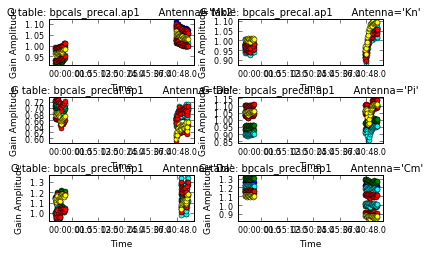

Show log 2018-01-23 10:59:02	INFO	plotcal::tableplot::setgui	Switching to GUI mode. All current plots will be reset.
 2018-01-23 10:59:02	INFO	plotcal::plotcal::createCalTab Detected a NewCalTable!
 2018-01-23 10:59:02	INFO	plotants::::	Now get the data
 2018-01-23 10:59:02	INFO	plotants::::	Done Processing data ... 
 2018-01-23 10:59:02	INFO	plotants::::	Now get the data
 2018-01-23 10:59:02	INFO	plotants::::	Done Processing data ... 
 2018-01-23 10:59:03	INFO	plotants::::	Now get the data
 2018-01-23 10:59:03	INFO	plotants::::	Done Processing data ... 
 2018-01-23 10:59:03	INFO	plotants::::	Now get the data
 2018-01-23 10:59:03	INFO	plotants::::	Done Processing data ... 
 2018-01-23 10:59:03	INFO	plotants::::	Now get the data
 2018-01-23 10:59:03	INFO	plotants::::	Done Processing data ... 
 2018-01-23 10:59:03	INFO	plotants::::	Now get the data
 2018-01-23 10:59:03	INFO	plotants::::	Done Processing data ...

In [40]:
plotcal(caltable='bpcals_precal.ap1',
    xaxis='time',
    yaxis='amp',
    subplot=321,
    iteration='antenna',
    showgui=T)

### Deriving the solutions
Now we apply these gain tables in {{bandpass}} and derive solutions for phase and amplitude as a function of frequency.

In [41]:
os.system('rm -rf bpcal.B1')
bandpass(vis=multi_source,
    caltable='bpcal.B1',           # New table with bandpass solutions
    field=bpcals,
    fillgaps=16,                   # Interpolate over flagged channels
    solint='inf',combine='scan',   # Average the whole time for each source
    refant='Mk2',
    solnorm=T,
    gaintable=['all_avg.K','bpcals_precal.p1','bpcals_precal.ap1'], # Apply all the tables derived for these sources
    minblperant=2,minsnr=3)

Show log 2018-01-23 10:59:25	INFO	bandpass::calibrater::open	Opening MS: all_avg.ms for calibration.
 2018-01-23 10:59:25	INFO	bandpass::Calibrater::	Initializing nominal selection to the whole MS.
 2018-01-23 10:59:25	INFO	bandpass::calibrater::reset	Reseting solve/apply state
 2018-01-23 10:59:25	INFO	bandpass::calibrater::setdata	Beginning selectvis--(MSSelection version)-------
 2018-01-23 10:59:25	INFO	bandpass::calibrater::reset	Reseting solve/apply state
 2018-01-23 10:59:25	INFO	bandpass::Calibrater::selectvis	Performing selection on MeasurementSet
 2018-01-23 10:59:25	INFO	bandpass::Calibrater::selectvis+ Selecting on field: '0319+415,1407+284'
 2018-01-23 10:59:25	INFO	bandpass::Calibrater::selectvis	By selection 747300 rows are reduced to 92700
 2018-01-23 10:59:26	INFO	bandpass::Calibrater::selectvis	Frequency selection: Selecting all channels in all spws.
 2018-01-23 10:59:26	INFO	bandpass::calibrater::setdata	chanmode=none nchan=1 start=0 step=1 mStart='0km/s' mStep='0km/s' msSelect=''
 2018-01-23 10:59:26	INFO	bandpass::calibrater::setapply	Beginning setapply--(MSSelection version)-------
 2018-01-23 10:59:26	INFO	bandpass::Calibrater::setapply(type, applypar)	Arranging to APPLY:
 2018-01-23 10:59:26	INFO	bandpass:::: (K Jones: Enforcing calWt()=False for phase/delay-like terms)
 2018-01-23 10:59:26	INFO	bandpass::Calibrater::setapply(type, applypar)	. K Jones: table=all_avg.K select= interp=linear spwmap=[-1] calWt=false
 2018-01-23 10:59:26	INFO	bandpass::calibrater::setapply	Beginning setapply--(MSSelection version)-------
 2018-01-23 10:59:26	INFO	bandpass::Calibrater::setapply(type, applypar)	Arranging to APPLY:
 2018-01-23 10:59:26	INFO	bandpass::Calibrater::setapply(type, applypar)	. G Jones: table=bpcals_precal.p1 select= interp=linear spwmap=[-1] calWt=true
 2018-01-23 10:59:26	INFO	bandpass::calibrater::setapply	Beginning setapply--(MSSelection version)-------
 2018-01-23 10:59:26	INFO	bandpass::Calibrater::setapply(type, applypar)	Arranging to APPLY:
 2018-01-23 10:59:26	INFO	bandpass::Calibrater::setapply(type, applypar)	. G Jones: table=bpcals_precal.ap1 select= interp=linear spwmap=[-1] calWt=true
 2018-01-23 10:59:26	INFO	bandpass::calibrater::setsolve	Beginning setsolve--(MSSelection version)-------
 2018-01-23 10:59:26	INFO	bandpass::Calibrater::setsolve	Arranging to SOLVE:
 2018-01-23 10:59:26	INFO	bandpass::Calibrater::setsolve	. B Jones: table=bpcal.B1 append=false solint=inf,none refant='Mk2' minsnr=3 apmode=AP solnorm=true
 2018-01-23 10:59:26	INFO	bandpass::calibrater::solve	Beginning solve-----------------------------
 2018-01-23 10:59:26	INFO	bandpass::Calibrater::solve	The following calibration terms are arranged for apply:
 2018-01-23 10:59:26	INFO	bandpass::Calibrater::solve	. K Jones: table=all_avg.K select= interp=linear spwmap=[-1] calWt=false
 2018-01-23 10:59:26	INFO	bandpass::Calibrater::solve	. G Jones: table=bpcals_precal.p1 select= interp=linear spwmap=[-1] calWt=true
 2018-01-23 10:59:26	INFO	bandpass::Calibrater::solve	. G Jones: table=bpcals_precal.ap1 select= interp=linear spwmap=[-1] calWt=true
 2018-01-23 10:59:26	INFO	bandpass::Calibrater::solve	The following calibration term is arranged for solve:
 2018-01-23 10:59:26	INFO	bandpass::Calibrater::solve	. B Jones: table=bpcal.B1 append=false solint=inf,none refant='Mk2' minsnr=3 apmode=AP solnorm=true
 2018-01-23 10:59:26	INFO	bandpass::Calibrater::solve	Solving for B Jones
 2018-01-23 10:59:26	INFO	bandpass::::	Combining scans.
 2018-01-23 10:59:26	INFO	bandpass::::	For solint = inf, found 8 solution intervals.
 2018-01-23 10:59:29	INFO	bandpass::Calibrater::solve Found good B Jones solutions in 8 slots.
 2018-01-23 10:59:29	INFO	bandpass::::	Applying refant: Mk2
 2018-01-23 10:59:29	INFO	bandpass::::	Normalizing solutions per spw, pol, ant, time.
 2018-01-23 10:59:29	INFO	bandpass::::	Filling in flagged solution channels by interpolation.
 2018-01-23 10:59:29	INFO	bandpass::::	Normalizing solutions per spw, pol, ant, t

Inspect the solutions. The phase corrections are small as the delay solutions were already applied. The amplitude solutions will remove local deviations from the bandpass assuming that it is flat in each spw.

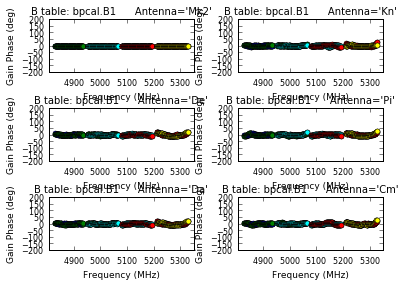

Show log 2018-01-23 11:00:09	INFO	plotcal::tableplot::setgui	Switching to NO-GUI mode. All current plots will be reset.
 2018-01-23 11:00:09	INFO	plotcal::plotcal::createCalTab Detected a NewCalTable!
 2018-01-23 11:00:09	INFO	plotants::::	Now get the data
 2018-01-23 11:00:09	INFO	plotants::::	Done Processing data ... 
 2018-01-23 11:00:09	INFO	plotants::::	Now get the data
 2018-01-23 11:00:09	INFO	plotants::::	Done Processing data ... 
 2018-01-23 11:00:10	INFO	plotants::::	Now get the data
 2018-01-23 11:00:10	INFO	plotants::::	Done Processing data ... 
 2018-01-23 11:00:11	INFO	plotants::::	Now get the data
 2018-01-23 11:00:11	INFO	plotants::::	Done Processing data ... 
 2018-01-23 11:00:11	INFO	plotants::::	Now get the data
 2018-01-23 11:00:11	INFO	plotants::::	Done Processing data ... 
 2018-01-23 11:00:12	INFO	plotants::::	Now get the data
 2018-01-23 11:00:12	INFO	plotants::::	Done Processing data ...

In [44]:
plotcal(caltable='bpcal.B1',
    xaxis='freq',
    yaxis='phase',
    plotrange=[-1,-1,-180,180], # Plot phase solutions v. frequency
    iteration='antenna',subplot=321,
    showgui=F)

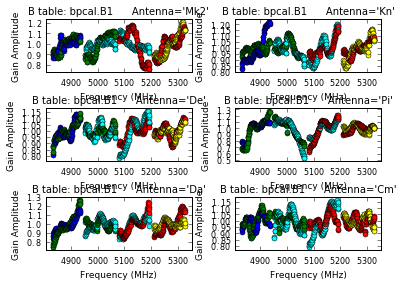

Show log 2018-01-23 11:00:33	INFO	plotcal::tableplot::setgui	Switching to GUI mode. All current plots will be reset.
 2018-01-23 11:00:33	INFO	plotcal::plotcal::createCalTab Detected a NewCalTable!
 2018-01-23 11:00:33	INFO	plotants::::	Now get the data
 2018-01-23 11:00:33	INFO	plotants::::	Done Processing data ... 
 2018-01-23 11:00:33	INFO	plotants::::	Now get the data
 2018-01-23 11:00:33	INFO	plotants::::	Done Processing data ... 
 2018-01-23 11:00:35	INFO	plotants::::	Now get the data
 2018-01-23 11:00:35	INFO	plotants::::	Done Processing data ... 
 2018-01-23 11:00:36	INFO	plotants::::	Now get the data
 2018-01-23 11:00:36	INFO	plotants::::	Done Processing data ... 
 2018-01-23 11:00:37	INFO	plotants::::	Now get the data
 2018-01-23 11:00:37	INFO	plotants::::	Done Processing data ... 
 2018-01-23 11:00:38	INFO	plotants::::	Now get the data
 2018-01-23 11:00:38	INFO	plotants::::	Done Processing data ...

In [46]:
plotcal(caltable='bpcal.B1',
    xaxis='freq',
    yaxis='amp',
    plotrange=[-1,-1,-1,-1], # Plot phase solutions v. frequency
    iteration='antenna',subplot=321,
    showgui=T)

**Apply the delay and bandpass solutions to the calibration sources as a test**

to check that they have the desired effect of producing a flat bandpass. Some notes about {{applycal}}:

- The first time applycal is run, it creates the 'corrected' data column in the MS, which is quite slow.
- Each time applycal is run, it replaces the entries in the 'corrected' column, i.e. the corrected column is not cumlative, but you can give applycal a cumulative list of gain tables.
- Applycal 'applymode' can be used to flag data with failed solutions but we do not want that here as this is just a test.
- The 'interp' parameter can take two values for each gaintable to be applied, the first determining inerpolation in time and the second in frequency. The times of data to be corrected may coincide with, or be bracketed by the times of calibration solutions, in which case 'linear' interpolation can be used, the default, normally used if applying solutions derived from a source to itself, or from phase ref to target. However, if solutions are to be extrapolated in time from one source to another then 'nearest' is used. A similar argument covers frequency. There are additional modes not used here (see help applycal).


In [47]:
applycal(vis='all_avg.ms',
    field=calsources,
    calwt=F, applymode='calonly',        # Test, so don't change the weights or flag data with failed solutions
    gaintable=['all_avg.K','bpcal.B1'],  # Enter the names of the tables used to calibrate the bandpass
    interp=['','nearest,linear'])         # Interpolate the first gaintable linearly in time and frequency. 
                                          # For the second gaintable, transfer solutions to data from the nearest 
                                       # calibration  entry in time, but use linear interpolation in frequency.     
                                       # Change interp if needed depending on order of gaintables.

Show log 2018-01-23 11:01:19	INFO	applycal::calibrater::open	Opening MS: all_avg.ms for calibration.
 2018-01-23 11:01:19	INFO	applycal::VisSetUtil::addScrCols	Adding CORRECTED_DATA column(s).
 2018-01-23 11:01:32	INFO	applycal::Calibrater::	Initializing nominal selection to the whole MS.
 2018-01-23 11:01:32	INFO	applycal::calibrater::setdata	Beginning selectvis--(MSSelection version)-------
 2018-01-23 11:01:32	INFO	applycal::calibrater::reset	Reseting solve/apply state
 2018-01-23 11:01:32	INFO	applycal::Calibrater::selectvis	Performing selection on MeasurementSet
 2018-01-23 11:01:32	INFO	applycal::Calibrater::selectvis+ Selecting on field: '1302+5748,0319+415,1407+284,1331+305'
 2018-01-23 11:01:33	INFO	applycal::Calibrater::selectvis	By selection 747300 rows are reduced to 338100
 2018-01-23 11:01:33	INFO	applycal::Calibrater::selectvis	Frequency selection: Selecting all channels in all spws.
 2018-01-23 11:01:33	INFO	applycal::calibrater::setdata	chanmode=none nchan=1 start=0 step=1 mStart='0km/s' mStep='0km/s' msSelect=''
 2018-01-23 11:01:33	INFO	applycal::calibrater::setapply	Beginning setapply--(MSSelection version)-------
 2018-01-23 11:01:33	INFO	applycal::Calibrater::setapply(type, applypar)	Arranging to APPLY:
 2018-01-23 11:01:33	INFO	applycal::Calibrater::setapply(type, applypar)	. K Jones: table=all_avg.K select= interp=linear spwmap=[-1] calWt=false
 2018-01-23 11:01:33	INFO	applycal::calibrater::setapply	Beginning setapply--(MSSelection version)-------
 2018-01-23 11:01:33	INFO	applycal::Calibrater::setapply(type, applypar)	Arranging to APPLY:
 2018-01-23 11:01:33	INFO	applycal::Calibrater::setapply(type, applypar)	. B Jones: table=bpcal.B1 select= interp=nearest,linear spwmap=[-1] calWt=false
 2018-01-23 11:01:33	INFO	applycal::calibrater::correct	Beginning correct---------------------------
 2018-01-23 11:01:33	INFO	applycal::Calibrater::correct2 (VI2/VB2)	The following calibration terms are arranged for apply:
 2018-01-23 11:01:33	INFO	applycal::Calibrater::correct2 (VI2/VB2)	. K Jones: table=all_avg.K select= interp=linear spwmap=[-1] calWt=false
 2018-01-23 11:01:33	INFO	applycal::Calibrater::correct2 (VI2/VB2)	. B Jones: table=bpcal.B1 select= interp=nearest,linear spwmap=[-1] calWt=false
 2018-01-23 11:01:45	INFO	applycal::calibrater::correct	Finished correcting.
 2018-01-23 11:01:45	INFO	applycal::::	Calibration apply flagging statistics (among calibrateable spws):
 2018-01-23 11:01:45	INFO	applycal:::: Total selected visibilities (among calibrateable spws) = 86553600
 2018-01-23 11:01:45	INFO	applycal:::: Flags:
 2018-01-23 11:01:45	INFO	applycal:::: K Jones: In: 43111106 (49.8085648662%) --> Out: 43389529 (50.1302418386%) (all_avg.K)
 2018-01-23 11:01:45	INFO	applycal:::: B Jones: In: 43389529 (50.1302418386%) --> Out: 43389529 (50.1302418386%) (bpcal.B1)
 2018-01-23 11:01:46	INFO	applycal::::	CASA Version 0.4.7 (REL r00)
 2018-01-23 11:01:46	INFO	applycal:::: Tagged on: 2017-02-20 15:48:56 UTC

**Check that the bandpass corrections are good for all data by plotting the phase reference 
corrected phase and amplitude against time.**

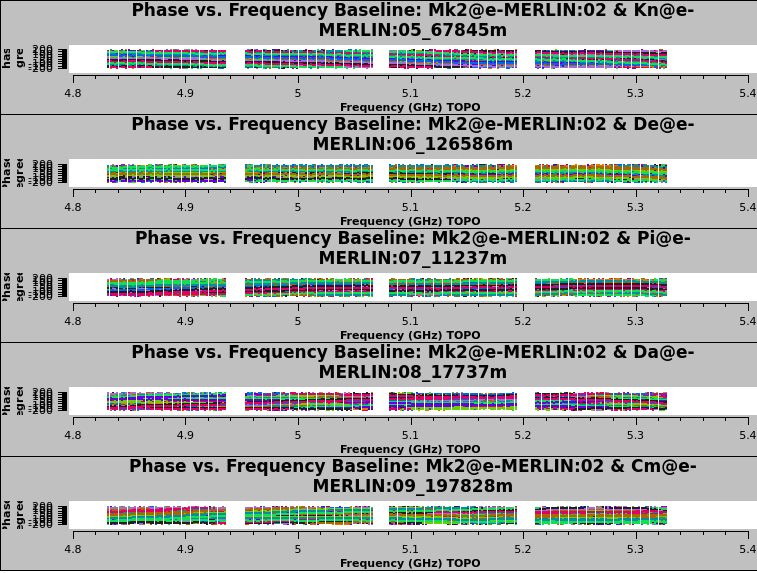

True

Show log 2018-01-23 11:12:59	INFO	PlotMS::params_changed	Updating: REDRAW, MSDATA, CACHE, AXES, CANVAS, DISPLAY, ITERATION, LOG, PLOTMS_OPTIONS.
 2018-01-23 11:12:59	INFO	PlotMS::load_cache	Clearing the existing plotms cache.
 2018-01-23 11:12:59	INFO	PlotMS::load_cache	START Current memory usage: 8233.95 kilobytes.
 2018-01-23 11:12:59	INFO	PlotMS::load_cache	Plot Data Transformations:
 2018-01-23 11:12:59	INFO	PlotMS::load_cache+ Frame = 
 2018-01-23 11:12:59	INFO	PlotMS::load_cache+ VelDef = RADIO
 2018-01-23 11:12:59	INFO	PlotMS::load_cache+ RestFreq = 0 MHz
 2018-01-23 11:12:59	INFO	PlotMS::load_cache+ dX = 0 arcsec
 2018-01-23 11:12:59	INFO	PlotMS::load_cache+ dY = 0 arcsec
 2018-01-23 11:12:59	INFO	PlotMS::load_cache+ formStokes = false
 2018-01-23 11:12:59	INFO	PlotMS::load_cache	Data Averaging: 
 2018-01-23 11:12:59	INFO	PlotMS::load_cache+ Using VECTOR averaging.
 2018-01-23 11:12:59	INFO	PlotMS::load_cache+ Time: 600 seconds. Scan: false; Field: false
 2018-01-23 11:12:59	INFO	PlotMS::load_cache	Plot Data Calibration:
 2018-01-23 11:12:59	INFO	PlotMS::load_cache+ Use Calibration = 0
 2018-01-23 11:12:59	INFO	PlotMS::load_cache+ Calibration Library = 
 2018-01-23 11:12:59	INFO	PlotMS::load_cache	Caching for the new plot: Phase(18) vs. Frequency(6)...
 2018-01-23 11:13:03	INFO	PlotMS::load_cache	Data selection will yield a total of 176640 plottable points (flagged and unflagged).
 2018-01-23 11:13:03	INFO	PlotMS::load_cache+	The plotms cache will require an estimated 0.0012983 GB of memory (7.35 bytes/point).
 2018-01-23 11:13:03	INFO	PlotMS::load_cache+	This is 1.84063% of the memory avail. to CASA (free=0.070536 GB).
 2018-01-23 11:13:03	INFO	PlotMS::load_cache	Loading chunks......
 2018-01-23 11:13:07	INFO	PlotMS::load_cache	Generating the plot mask.
 2018-01-23 11:13:07	INFO	PlotMS::load_cache	refTime = 2015/05/05/00:00:00.0
 2018-01-23 11:13:07	INFO	PlotMS::load_cache	Finished loading.
 2018-01-23 11:13:07	INFO	PlotMS::load_cache	Setting up iteration indexing (if necessary), and calculating plot ranges.
 2018-01-23 11:13:07	INFO	PlotMS::load_cache	Global ranges:
 2018-01-23 11:13:07	INFO	PlotMS::load_cache+	Frequency: 4.831-5.327 (unflagged); 4.817-5.327 (flagged).
 2018-01-23 11:13:07	INFO	PlotMS::load_cache+	Phase: -179.997-179.999 (unflagged); -179.996-179.999(flagged).
 2018-01-23 11:13:07	INFO	PlotMS::load_cache	Setting up iteration indexing (if necessary), and calculating plot ranges.
 2018-01-23 11:13:07	INFO	PlotMS::load_cache	Found 5 Baseline iterations.
 2018-01-23 11:13:07	INFO	PlotMS::load_cache	Global ranges:
 2018-01-23 11:13:07	INFO	PlotMS::load_cache+	Frequency: 4.831-5.327 (unflagged); 4.817-5.327 (flagged).
 2018-01-23 11:13:07	INFO	PlotMS::load_cache+	Phase: -179.997-179.999 (unflagged); -179.996-179.999(flagged).
 2018-01-23 11:13:07	INFO	PlotMS::plot	Stepping to iteration = 1 (of 5): Baseline: Mk2@e-MERLIN:02 & Kn@e-MERLIN:05_67845m
 2018-01-23 11:13:07	INFO	PlotMS::plot	Stepping to iteration = 2 (of 5): Baseline: Mk2@e-MERLIN:02 & De@e-MERLIN:06_126586m
 2018-01-23 11:13:07	INFO	PlotMS::plot	Stepping to iteration = 3 (of 5): Baseline: Mk2@e-MERLIN:02 & Pi@e-MERLIN:07_11237m
 2018-01-23 11:13:07	INFO	PlotMS::plot	Stepping to iteration = 4 (of 5): Baseline: Mk2@e-MERLIN:02 & Da@e-MERLIN:08_17737m
 2018-01-23 11:13:07	INFO	PlotMS::plot	Stepping to iteration = 5 (of 5): Baseline: Mk2@e-MERLIN:02 & Cm@e-MERLIN:09_197828m
 2018-01-23 11:13:07	INFO	PlotMS::plot	Plotting 21244 unflagged points.
 2018-01-23 11:12:59	INFO	PlotMS::load_cache	END Time: +7 seconds. Memory: +5919.77 kilobytes.
 2018-01-23 11:13:07	INFO	plotms::::	Plot file /home/jupyter/plotms_temp.png
 2018-01-23 11:13:07	INFO	plotms::::	Exporting the plot.
 2018-01-23 11:13:07	INFO	plotms::::	Calling pm.save
 2018-01-23 11:13:07	INFO	QPExporter::export	START Current memory usage: 14102.5 kilobytes.
 2018-01-23 11:13:07	INFO	QPExporter::export	END Time: +1 seconds. Memory: +5.09375 kilobytes.
 2018-01-23 11:13:08	INFO	PlotMS::plot	Steppi

In [48]:
plotms(vis=multi_source,
    field=phref,                 # Phase reference
    xaxis='frequency',
    yaxis='phase',
    ydatacolumn='data',  # First, plot uncorrected phase
    gridrows=5, gridcols=1,
    avgtime='600',coloraxis='scan',
    iteraxis='baseline',
    antenna='Mk2&*',
    correlation='LL,RR',
    customsymbol=True,
    symbolsize=3,
    symbolshape='circle',
    showgui=F)


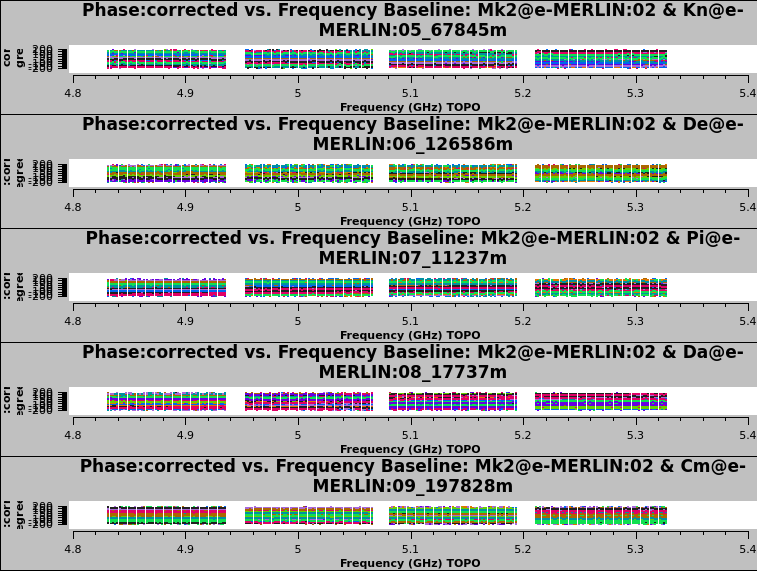

True

Show log 2018-01-23 11:13:19	INFO	PlotMS::params_changed	Updating: REDRAW, MSDATA, CACHE, AXES, CANVAS, DISPLAY, ITERATION, LOG, PLOTMS_OPTIONS.
 2018-01-23 11:13:19	INFO	PlotMS::load_cache	Clearing the existing plotms cache.
 2018-01-23 11:13:19	INFO	PlotMS::load_cache	START Current memory usage: 8279.89 kilobytes.
 2018-01-23 11:13:19	INFO	PlotMS::load_cache	Plot Data Transformations:
 2018-01-23 11:13:19	INFO	PlotMS::load_cache+ Frame = 
 2018-01-23 11:13:19	INFO	PlotMS::load_cache+ VelDef = RADIO
 2018-01-23 11:13:19	INFO	PlotMS::load_cache+ RestFreq = 0 MHz
 2018-01-23 11:13:19	INFO	PlotMS::load_cache+ dX = 0 arcsec
 2018-01-23 11:13:19	INFO	PlotMS::load_cache+ dY = 0 arcsec
 2018-01-23 11:13:19	INFO	PlotMS::load_cache+ formStokes = false
 2018-01-23 11:13:19	INFO	PlotMS::load_cache	Data Averaging: 
 2018-01-23 11:13:19	INFO	PlotMS::load_cache+ Using VECTOR averaging.
 2018-01-23 11:13:19	INFO	PlotMS::load_cache+ Time: 600 seconds. Scan: false; Field: false
 2018-01-23 11:13:19	INFO	PlotMS::load_cache	Plot Data Calibration:
 2018-01-23 11:13:19	INFO	PlotMS::load_cache+ Use Calibration = 0
 2018-01-23 11:13:19	INFO	PlotMS::load_cache+ Calibration Library = 
 2018-01-23 11:13:19	INFO	PlotMS::load_cache	Caching for the new plot: Phase(18) vs. Frequency(6)...
 2018-01-23 11:13:22	INFO	PlotMS::load_cache	Data selection will yield a total of 176640 plottable points (flagged and unflagged).
 2018-01-23 11:13:22	INFO	PlotMS::load_cache+	The plotms cache will require an estimated 0.0012983 GB of memory (7.35 bytes/point).
 2018-01-23 11:13:22	INFO	PlotMS::load_cache+	This is 1.20343% of the memory avail. to CASA (free=0.107884 GB).
 2018-01-23 11:13:22	INFO	PlotMS::load_cache	Loading chunks......
 2018-01-23 11:13:26	INFO	PlotMS::load_cache	Generating the plot mask.
 2018-01-23 11:13:26	INFO	PlotMS::load_cache	refTime = 2015/05/05/00:00:00.0
 2018-01-23 11:13:26	INFO	PlotMS::load_cache	Finished loading.
 2018-01-23 11:13:26	INFO	PlotMS::load_cache	Setting up iteration indexing (if necessary), and calculating plot ranges.
 2018-01-23 11:13:26	INFO	PlotMS::load_cache	Global ranges:
 2018-01-23 11:13:26	INFO	PlotMS::load_cache+	Frequency: 4.831-5.327 (unflagged); 4.817-5.327 (flagged).
 2018-01-23 11:13:26	INFO	PlotMS::load_cache+	Phase: -179.995-180 (unflagged); -180-179.997(flagged).
 2018-01-23 11:13:26	INFO	PlotMS::load_cache	Setting up iteration indexing (if necessary), and calculating plot ranges.
 2018-01-23 11:13:26	INFO	PlotMS::load_cache	Found 5 Baseline iterations.
 2018-01-23 11:13:26	INFO	PlotMS::load_cache	Global ranges:
 2018-01-23 11:13:26	INFO	PlotMS::load_cache+	Frequency: 4.831-5.327 (unflagged); 4.817-5.327 (flagged).
 2018-01-23 11:13:26	INFO	PlotMS::load_cache+	Phase: -179.995-180 (unflagged); -180-179.997(flagged).
 2018-01-23 11:13:26	INFO	PlotMS::plot	Stepping to iteration = 1 (of 5): Baseline: Mk2@e-MERLIN:02 & Kn@e-MERLIN:05_67845m
 2018-01-23 11:13:26	INFO	PlotMS::plot	Stepping to iteration = 2 (of 5): Baseline: Mk2@e-MERLIN:02 & De@e-MERLIN:06_126586m
 2018-01-23 11:13:26	INFO	PlotMS::plot	Stepping to iteration = 3 (of 5): Baseline: Mk2@e-MERLIN:02 & Pi@e-MERLIN:07_11237m
 2018-01-23 11:13:26	INFO	PlotMS::plot	Stepping to iteration = 4 (of 5): Baseline: Mk2@e-MERLIN:02 & Da@e-MERLIN:08_17737m
 2018-01-23 11:13:26	INFO	PlotMS::plot	Stepping to iteration = 5 (of 5): Baseline: Mk2@e-MERLIN:02 & Cm@e-MERLIN:09_197828m
 2018-01-23 11:13:26	INFO	PlotMS::plot	Plotting 21244 unflagged points.
 2018-01-23 11:13:19	INFO	PlotMS::load_cache	END Time: +8 seconds. Memory: +5920.47 kilobytes.
 2018-01-23 11:13:26	INFO	plotms::::	Plot file /home/jupyter/plotms_temp.png
 2018-01-23 11:13:27	INFO	plotms::::	Exporting the plot.
 2018-01-23 11:13:27	INFO	plotms::::	Calling pm.save
 2018-01-23 11:13:27	INFO	QPExporter::export	START Current memory usage: 14162.5 kilobytes.
 2018-01-23 11:13:27	INFO	QPExporter::export	END Time: +1 seconds. Memory: +5.03125 kilobytes.
 2018-01-23 11:13:28	INFO	PlotMS::plot	Stepping to iteration 

In [49]:
plotms(vis=multi_source,
    field=phref,                 # Phase reference
    xaxis='frequency',
    yaxis='phase',
    ydatacolumn='corrected',         # Repeat for corrected phase
    gridrows=5, gridcols=1,
    avgtime='600',coloraxis='scan',
    iteraxis='baseline',
    antenna='Mk2&*',
    correlation='LL,RR',
    customsymbol=True,
    symbolsize=3,
    symbolshape='circle',
    showgui=F)

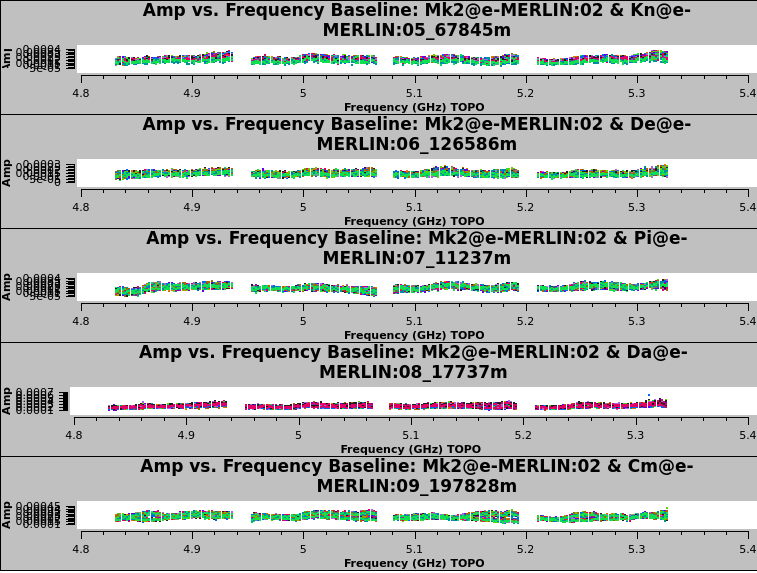

True

Show log 2018-01-23 11:13:32	INFO	PlotMS::params_changed	Updating: REDRAW, MSDATA, CACHE, AXES, CANVAS, DISPLAY, ITERATION, LOG, PLOTMS_OPTIONS.
 2018-01-23 11:13:32	INFO	PlotMS::load_cache	Clearing the existing plotms cache.
 2018-01-23 11:13:32	INFO	PlotMS::load_cache	START Current memory usage: 8339.39 kilobytes.
 2018-01-23 11:13:32	INFO	PlotMS::load_cache	Plot Data Transformations:
 2018-01-23 11:13:32	INFO	PlotMS::load_cache+ Frame = 
 2018-01-23 11:13:32	INFO	PlotMS::load_cache+ VelDef = RADIO
 2018-01-23 11:13:32	INFO	PlotMS::load_cache+ RestFreq = 0 MHz
 2018-01-23 11:13:32	INFO	PlotMS::load_cache+ dX = 0 arcsec
 2018-01-23 11:13:32	INFO	PlotMS::load_cache+ dY = 0 arcsec
 2018-01-23 11:13:32	INFO	PlotMS::load_cache+ formStokes = false
 2018-01-23 11:13:32	INFO	PlotMS::load_cache	Data Averaging: 
 2018-01-23 11:13:32	INFO	PlotMS::load_cache+ Using VECTOR averaging.
 2018-01-23 11:13:32	INFO	PlotMS::load_cache+ Time: 600 seconds. Scan: false; Field: false
 2018-01-23 11:13:32	INFO	PlotMS::load_cache	Plot Data Calibration:
 2018-01-23 11:13:32	INFO	PlotMS::load_cache+ Use Calibration = 0
 2018-01-23 11:13:32	INFO	PlotMS::load_cache+ Calibration Library = 
 2018-01-23 11:13:32	INFO	PlotMS::load_cache	Caching for the new plot: Amp(17) vs. Frequency(6)...
 2018-01-23 11:13:36	INFO	PlotMS::load_cache	Data selection will yield a total of 176640 plottable points (flagged and unflagged).
 2018-01-23 11:13:36	INFO	PlotMS::load_cache+	The plotms cache will require an estimated 0.0012983 GB of memory (7.35 bytes/point).
 2018-01-23 11:13:36	INFO	PlotMS::load_cache+	This is 1.14984% of the memory avail. to CASA (free=0.112912 GB).
 2018-01-23 11:13:36	INFO	PlotMS::load_cache	Loading chunks......
 2018-01-23 11:13:40	INFO	PlotMS::load_cache	Generating the plot mask.
 2018-01-23 11:13:40	INFO	PlotMS::load_cache	refTime = 2015/05/05/00:00:00.0
 2018-01-23 11:13:40	INFO	PlotMS::load_cache	Finished loading.
 2018-01-23 11:13:40	INFO	PlotMS::load_cache	Setting up iteration indexing (if necessary), and calculating plot ranges.
 2018-01-23 11:13:40	INFO	PlotMS::load_cache	Global ranges:
 2018-01-23 11:13:40	INFO	PlotMS::load_cache+	Frequency: 4.831-5.327 (unflagged); 4.817-5.327 (flagged).
 2018-01-23 11:13:40	INFO	PlotMS::load_cache+	Amp: 4.81429e-05-0.000617623 (unflagged); 4.18162e-09-0.00102662(flagged).
 2018-01-23 11:13:40	INFO	PlotMS::load_cache	Setting up iteration indexing (if necessary), and calculating plot ranges.
 2018-01-23 11:13:40	INFO	PlotMS::load_cache	Found 5 Baseline iterations.
 2018-01-23 11:13:40	INFO	PlotMS::load_cache	Global ranges:
 2018-01-23 11:13:40	INFO	PlotMS::load_cache+	Frequency: 4.831-5.327 (unflagged); 4.817-5.327 (flagged).
 2018-01-23 11:13:40	INFO	PlotMS::load_cache+	Amp: 4.81429e-05-0.000617623 (unflagged); 4.18162e-09-0.00102662(flagged).
 2018-01-23 11:13:40	INFO	PlotMS::plot	Stepping to iteration = 1 (of 5): Baseline: Mk2@e-MERLIN:02 & Kn@e-MERLIN:05_67845m
 2018-01-23 11:13:40	INFO	PlotMS::plot	Stepping to iteration = 2 (of 5): Baseline: Mk2@e-MERLIN:02 & De@e-MERLIN:06_126586m
 2018-01-23 11:13:40	INFO	PlotMS::plot	Stepping to iteration = 3 (of 5): Baseline: Mk2@e-MERLIN:02 & Pi@e-MERLIN:07_11237m
 2018-01-23 11:13:40	INFO	PlotMS::plot	Stepping to iteration = 4 (of 5): Baseline: Mk2@e-MERLIN:02 & Da@e-MERLIN:08_17737m
 2018-01-23 11:13:40	INFO	PlotMS::plot	Stepping to iteration = 5 (of 5): Baseline: Mk2@e-MERLIN:02 & Cm@e-MERLIN:09_197828m
 2018-01-23 11:13:40	INFO	PlotMS::plot	Plotting 21244 unflagged points.
 2018-01-23 11:13:32	INFO	PlotMS::load_cache	END Time: +8 seconds. Memory: +5912.59 kilobytes.
 2018-01-23 11:13:40	INFO	plotms::::	Plot file /home/jupyter/plotms_temp.png
 2018-01-23 11:13:40	INFO	plotms::::	Exporting the plot.
 2018-01-23 11:13:40	INFO	plotms::::	Calling pm.save
 2018-01-23 11:13:40	INFO	QPExporter::export	START Current memory usage: 14199.3 kilobytes.
 2018-01-23 11:13:40	INFO	QPExporter::export	END Time: +1 seconds. Memory: +5.21875 kilobytes.
 2018-01-23 11:13:41	INFO

In [50]:
plotms(vis=multi_source,
    field=phref,                     # Phase reference
    xaxis='frequency',
    yaxis='amplitude',
    ydatacolumn='data',             #plot uncorrected Amplitude
    gridrows=5, gridcols=1,
    avgtime='600',coloraxis='scan',
    iteraxis='baseline',
    antenna='Mk2&*',
    correlation='LL,RR',
    customsymbol=True,
    symbolsize=3,
    symbolshape='circle',
    showgui=F)

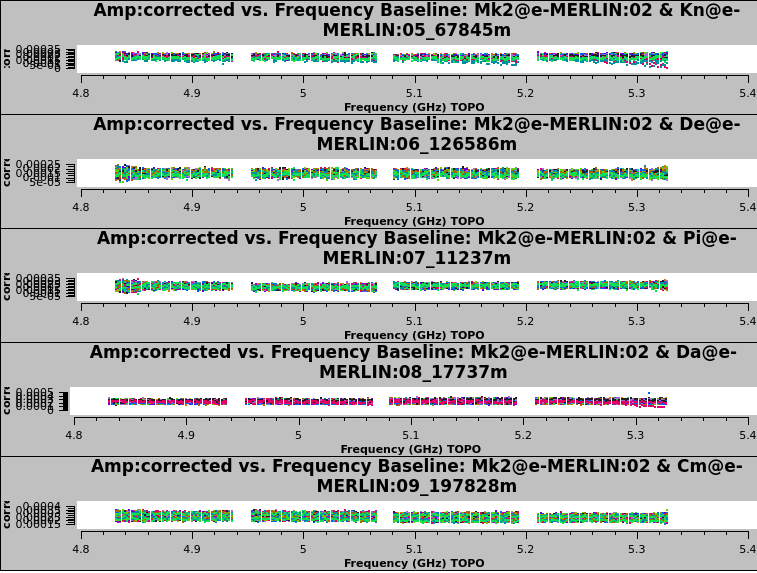

True

Show log 2018-01-23 11:13:44	INFO	PlotMS::params_changed	Updating: REDRAW, MSDATA, CACHE, AXES, CANVAS, DISPLAY, ITERATION, LOG, PLOTMS_OPTIONS.
 2018-01-23 11:13:44	INFO	PlotMS::load_cache	Clearing the existing plotms cache.
 2018-01-23 11:13:44	INFO	PlotMS::load_cache	START Current memory usage: 8388.72 kilobytes.
 2018-01-23 11:13:44	INFO	PlotMS::load_cache	Plot Data Transformations:
 2018-01-23 11:13:44	INFO	PlotMS::load_cache+ Frame = 
 2018-01-23 11:13:44	INFO	PlotMS::load_cache+ VelDef = RADIO
 2018-01-23 11:13:44	INFO	PlotMS::load_cache+ RestFreq = 0 MHz
 2018-01-23 11:13:44	INFO	PlotMS::load_cache+ dX = 0 arcsec
 2018-01-23 11:13:44	INFO	PlotMS::load_cache+ dY = 0 arcsec
 2018-01-23 11:13:44	INFO	PlotMS::load_cache+ formStokes = false
 2018-01-23 11:13:44	INFO	PlotMS::load_cache	Data Averaging: 
 2018-01-23 11:13:44	INFO	PlotMS::load_cache+ Using VECTOR averaging.
 2018-01-23 11:13:44	INFO	PlotMS::load_cache+ Time: 600 seconds. Scan: false; Field: false
 2018-01-23 11:13:44	INFO	PlotMS::load_cache	Plot Data Calibration:
 2018-01-23 11:13:44	INFO	PlotMS::load_cache+ Use Calibration = 0
 2018-01-23 11:13:44	INFO	PlotMS::load_cache+ Calibration Library = 
 2018-01-23 11:13:44	INFO	PlotMS::load_cache	Caching for the new plot: Amp(17) vs. Frequency(6)...
 2018-01-23 11:13:47	INFO	PlotMS::load_cache	Data selection will yield a total of 176640 plottable points (flagged and unflagged).
 2018-01-23 11:13:47	INFO	PlotMS::load_cache+	The plotms cache will require an estimated 0.0012983 GB of memory (7.35 bytes/point).
 2018-01-23 11:13:47	INFO	PlotMS::load_cache+	This is 0.840109% of the memory avail. to CASA (free=0.15454 GB).
 2018-01-23 11:13:48	INFO	PlotMS::load_cache	Loading chunks......
 2018-01-23 11:13:51	INFO	PlotMS::load_cache	Generating the plot mask.
 2018-01-23 11:13:51	INFO	PlotMS::load_cache	refTime = 2015/05/05/00:00:00.0
 2018-01-23 11:13:51	INFO	PlotMS::load_cache	Finished loading.
 2018-01-23 11:13:51	INFO	PlotMS::load_cache	Setting up iteration indexing (if necessary), and calculating plot ranges.
 2018-01-23 11:13:51	INFO	PlotMS::load_cache	Global ranges:
 2018-01-23 11:13:51	INFO	PlotMS::load_cache+	Frequency: 4.831-5.327 (unflagged); 4.817-5.327 (flagged).
 2018-01-23 11:13:51	INFO	PlotMS::load_cache+	Amp: 1.26639e-05-0.000492742 (unflagged); 5.75468e-09-0.000954586(flagged).
 2018-01-23 11:13:51	INFO	PlotMS::load_cache	Setting up iteration indexing (if necessary), and calculating plot ranges.
 2018-01-23 11:13:51	INFO	PlotMS::load_cache	Found 5 Baseline iterations.
 2018-01-23 11:13:51	INFO	PlotMS::load_cache	Global ranges:
 2018-01-23 11:13:51	INFO	PlotMS::load_cache+	Frequency: 4.831-5.327 (unflagged); 4.817-5.327 (flagged).
 2018-01-23 11:13:51	INFO	PlotMS::load_cache+	Amp: 1.26639e-05-0.000492742 (unflagged); 5.75468e-09-0.000954586(flagged).
 2018-01-23 11:13:51	INFO	PlotMS::plot	Stepping to iteration = 1 (of 5): Baseline: Mk2@e-MERLIN:02 & Kn@e-MERLIN:05_67845m
 2018-01-23 11:13:51	INFO	PlotMS::plot	Stepping to iteration = 2 (of 5): Baseline: Mk2@e-MERLIN:02 & De@e-MERLIN:06_126586m
 2018-01-23 11:13:51	INFO	PlotMS::plot	Stepping to iteration = 3 (of 5): Baseline: Mk2@e-MERLIN:02 & Pi@e-MERLIN:07_11237m
 2018-01-23 11:13:51	INFO	PlotMS::plot	Stepping to iteration = 4 (of 5): Baseline: Mk2@e-MERLIN:02 & Da@e-MERLIN:08_17737m
 2018-01-23 11:13:51	INFO	PlotMS::plot	Stepping to iteration = 5 (of 5): Baseline: Mk2@e-MERLIN:02 & Cm@e-MERLIN:09_197828m
 2018-01-23 11:13:51	INFO	PlotMS::plot	Plotting 21244 unflagged points.
 2018-01-23 11:13:44	INFO	PlotMS::load_cache	END Time: +7 seconds. Memory: +5917.97 kilobytes.
 2018-01-23 11:13:51	INFO	plotms::::	Plot file /home/jupyter/plotms_temp.png
 2018-01-23 11:13:52	INFO	plotms::::	Exporting the plot.
 2018-01-23 11:13:52	INFO	plotms::::	Calling pm.save
 2018-01-23 11:13:52	INFO	QPExporter::export	START Current memory usage: 14249.5 kilobytes.
 2018-01-23 11:13:52	INFO	QPExporter::export	END Time: +1 seconds. Memory: +5.10938 kilobytes.
 2018-01-23 11:13:53	IN

In [51]:
plotms(vis=multi_source,
    field=phref,                     # Phase reference
    xaxis='frequency',
    yaxis='amplitude',
    ydatacolumn='corrected',             #plot corrected Amplitude
    gridrows=5, gridcols=1,
    avgtime='600',coloraxis='scan',
    iteraxis='baseline',
    antenna='Mk2&*',
    correlation='LL,RR',
    customsymbol=True,
    symbolsize=3,
    symbolshape='circle',
    showgui=F)

In the plots above, each scan is coloured separately and shows a random offset in phase and some discrepancies in amplitude compared to other scans, but for each individual time interval it is quite flat.  So we can average in frequency across each spw and plot the data to show remaining, time-dependent errors.

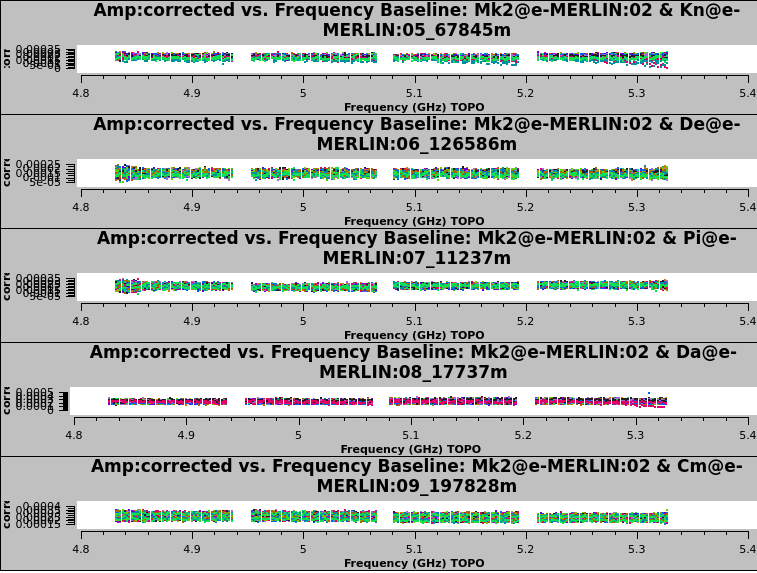

True

Show log 2018-01-23 11:14:32	INFO	PlotMS::params_changed	Updating: REDRAW, MSDATA, CACHE, AXES, CANVAS, DISPLAY, ITERATION, LOG, PLOTMS_OPTIONS.
 2018-01-23 11:14:32	INFO	PlotMS::load_cache	Clearing the existing plotms cache.
 2018-01-23 11:14:32	INFO	PlotMS::load_cache	START Current memory usage: 7849.08 kilobytes.
 2018-01-23 11:14:32	INFO	PlotMS::load_cache	Plot Data Transformations:
 2018-01-23 11:14:32	INFO	PlotMS::load_cache+ Frame = 
 2018-01-23 11:14:32	INFO	PlotMS::load_cache+ VelDef = RADIO
 2018-01-23 11:14:32	INFO	PlotMS::load_cache+ RestFreq = 0 MHz
 2018-01-23 11:14:32	INFO	PlotMS::load_cache+ dX = 0 arcsec
 2018-01-23 11:14:32	INFO	PlotMS::load_cache+ dY = 0 arcsec
 2018-01-23 11:14:32	INFO	PlotMS::load_cache+ formStokes = false
 2018-01-23 11:14:32	INFO	PlotMS::load_cache	Data Averaging: 
 2018-01-23 11:14:32	INFO	PlotMS::load_cache+ Using VECTOR averaging.
 2018-01-23 11:14:32	INFO	PlotMS::load_cache+ Channel: 64 channels
 2018-01-23 11:14:32	INFO	PlotMS::load_cache	Plot Data Calibration:
 2018-01-23 11:14:32	INFO	PlotMS::load_cache+ Use Calibration = 0
 2018-01-23 11:14:32	INFO	PlotMS::load_cache+ Calibration Library = 
 2018-01-23 11:14:32	INFO	PlotMS::load_cache	Caching for the new plot: Phase(18) vs. Time(2)...
 2018-01-23 11:14:40	INFO	PlotMS::load_cache	Data selection will yield a total of 68300 plottable points (flagged and unflagged).
 2018-01-23 11:14:40	INFO	PlotMS::load_cache+	The plotms cache will require an estimated 0.00183044 GB of memory (26.8 bytes/point).
 2018-01-23 11:14:40	INFO	PlotMS::load_cache+	This is 3.05114% of the memory avail. to CASA (free=0.059992 GB).
 2018-01-23 11:14:40	INFO	PlotMS::load_cache	Loading chunks......
 2018-01-23 11:14:47	INFO	PlotMS::load_cache	SPW 0: number of channels averaged = 64
 2018-01-23 11:14:47	INFO	PlotMS::load_cache	SPW 1: number of channels averaged = 64
 2018-01-23 11:14:47	INFO	PlotMS::load_cache	SPW 2: number of channels averaged = 64
 2018-01-23 11:14:47	INFO	PlotMS::load_cache	SPW 3: number of channels averaged = 64
 2018-01-23 11:14:47	INFO	PlotMS::load_cache	Generating the plot mask.
 2018-01-23 11:14:47	INFO	PlotMS::load_cache	refTime = 2015/05/05/00:00:00.0
 2018-01-23 11:14:47	INFO	PlotMS::load_cache	Finished loading.
 2018-01-23 11:14:47	INFO	PlotMS::load_cache	Setting up iteration indexing (if necessary), and calculating plot ranges.
 2018-01-23 11:14:47	INFO	PlotMS::load_cache	Global ranges:
 2018-01-23 11:14:47	INFO	PlotMS::load_cache+	Time: 4.93758e+09-4.93761e+09 (unflagged); 4.93757e+09-4.93761e+09 (flagged).
 2018-01-23 11:14:47	INFO	PlotMS::load_cache+	Phase: -179.998-179.976 (unflagged); -179.995-179.988(flagged).
 2018-01-23 11:14:47	INFO	PlotMS::load_cache	Setting up iteration indexing (if necessary), and calculating plot ranges.
 2018-01-23 11:14:47	INFO	PlotMS::load_cache	Found 5 Baseline iterations.
 2018-01-23 11:14:47	INFO	PlotMS::load_cache	Global ranges:
 2018-01-23 11:14:47	INFO	PlotMS::load_cache+	Time: 4.93758e+09-4.93761e+09 (unflagged); 4.93757e+09-4.93761e+09 (flagged).
 2018-01-23 11:14:47	INFO	PlotMS::load_cache+	Phase: -179.998-179.976 (unflagged); -179.995-179.988(flagged).
 2018-01-23 11:14:47	INFO	PlotMS::plot	Stepping to iteration = 1 (of 5): Baseline: Mk2@e-MERLIN:02 & Kn@e-MERLIN:05_67845m
 2018-01-23 11:14:47	INFO	PlotMS::plot	Stepping to iteration = 2 (of 5): Baseline: Mk2@e-MERLIN:02 & De@e-MERLIN:06_126586m
 2018-01-23 11:14:47	INFO	PlotMS::plot	Stepping to iteration = 3 (of 5): Baseline: Mk2@e-MERLIN:02 & Pi@e-MERLIN:07_11237m
 2018-01-23 11:14:47	INFO	PlotMS::plot	Stepping to iteration = 4 (of 5): Baseline: Mk2@e-MERLIN:02 & Da@e-MERLIN:08_17737m
 2018-01-23 11:14:47	INFO	PlotMS::plot	Stepping to iteration = 5 (of 5): Baseline: Mk2@e-MERLIN:02 & Cm@e-MERLIN:09_197828m
 2018-01-23 11:14:47	INFO	PlotMS::plot	Plotting 5444 unflagged points.
 2018-01-23 11:14:32	INFO	PlotMS::load_cache	END Time: +15 seconds. Memory: +196148 kilobytes.
 2018-01-23 11:14:48	INFO	plotms::::	Plot file /home/jupyter/plotms_tem

In [52]:
plotms(vis=multi_source,
    field=phref, 
    xaxis='time',yaxis='phase',ydatacolumn='corrected',
    antenna='Mk2&*',iteraxis='baseline',
    avgchannel='64', coloraxis='spw',
    correlation='LL',    # Just one pol as previous plots show both are similar
    showgui=F)

## 6. Gain calibration 

### Time-dependent phase calibration of all calibration sources

Derive time-dependent solutions for all the calibration sources, applying the delay and bandpass tables.

In [53]:
# Delete any previous models for sources other than 1331+305
delmod(vis=multi_source, 
    field='{},{},{},{}'.format(bpcal,bpcal2,phref,target))

Show log 2018-01-23 11:15:19	INFO	delmod::calibrater::open	Opening MS: all_avg.ms for calibration.
 2018-01-23 11:15:19	INFO	delmod::Calibrater::	Initializing nominal selection to the whole MS.
 2018-01-23 11:15:20	INFO	delmod::calibrater::delmod	Beginning delmod------------------------
 2018-01-23 11:15:20	INFO	delmod::::	Deleting OTF Visbility Model info.
 2018-01-23 11:15:20	INFO	delmod::::	Clearing model records in MS header for selected fields.
 2018-01-23 11:15:20	INFO	delmod:::: 1302+5748 (id = 0) not found.
 2018-01-23 11:15:20	INFO	delmod:::: 1252+5634 (id = 1) not found.
 2018-01-23 11:15:20	INFO	delmod:::: 1407+284 (id = 3) not found.
 2018-01-23 11:15:20	INFO	delmod:::: 0319+415 (id = 4) not found.

In [54]:
# Derive phase solutions
os.system('rm -rf calsources.p1')
gaincal(vis=multi_source,
        calmode='p',
        caltable='calsources.p1',
        field=calsources,
        solint=30,
        refant='Mk2',
        minblperant=2,minsnr=2,
        gaintable=['all_avg.K','bpcal.B1'],
        interp=['linear','nearest,linear'])

Show log 2018-01-23 11:15:28	INFO	gaincal::calibrater::open	Opening MS: all_avg.ms for calibration.
 2018-01-23 11:15:28	INFO	gaincal::Calibrater::	Initializing nominal selection to the whole MS.
 2018-01-23 11:15:28	INFO	gaincal::calibrater::setdata	Beginning selectvis--(MSSelection version)-------
 2018-01-23 11:15:28	INFO	gaincal::calibrater::reset	Reseting solve/apply state
 2018-01-23 11:15:28	INFO	gaincal::Calibrater::selectvis	Performing selection on MeasurementSet
 2018-01-23 11:15:28	INFO	gaincal::Calibrater::selectvis+ Selecting on field: '1302+5748,0319+415,1407+284,1331+305'
 2018-01-23 11:15:28	INFO	gaincal::Calibrater::selectvis	By selection 747300 rows are reduced to 338100
 2018-01-23 11:15:29	INFO	gaincal::Calibrater::selectvis	Frequency selection: Selecting all channels in all spws.
 2018-01-23 11:15:29	INFO	gaincal::calibrater::setdata	chanmode=none nchan=1 start=0 step=1 mStart='0km/s' mStep='0km/s' msSelect=''
 2018-01-23 11:15:29	INFO	gaincal::calibrater::setapply	Beginning setapply--(MSSelection version)-------
 2018-01-23 11:15:29	INFO	gaincal::Calibrater::setapply(type, applypar)	Arranging to APPLY:
 2018-01-23 11:15:29	INFO	gaincal:::: (K Jones: Enforcing calWt()=False for phase/delay-like terms)
 2018-01-23 11:15:29	INFO	gaincal::Calibrater::setapply(type, applypar)	. K Jones: table=all_avg.K select= interp=linear spwmap=[-1] calWt=false
 2018-01-23 11:15:29	INFO	gaincal::calibrater::setapply	Beginning setapply--(MSSelection version)-------
 2018-01-23 11:15:29	INFO	gaincal::Calibrater::setapply(type, applypar)	Arranging to APPLY:
 2018-01-23 11:15:30	INFO	gaincal::Calibrater::setapply(type, applypar)	. B Jones: table=bpcal.B1 select= interp=nearest,linear spwmap=[-1] calWt=true
 2018-01-23 11:15:30	INFO	gaincal::calibrater::setsolve	Beginning setsolve--(MSSelection version)-------
 2018-01-23 11:15:30	INFO	gaincal::Calibrater::setsolve	Arranging to SOLVE:
 2018-01-23 11:15:30	INFO	gaincal::Calibrater::setsolve	. G Jones: table=calsources.p1 append=false solint=30s refant='Mk2' minsnr=2 apmode=P solnorm=false
 2018-01-23 11:15:30	INFO	gaincal::calibrater::solve	Beginning solve-----------------------------
 2018-01-23 11:15:30	INFO	gaincal::Calibrater::solve	The following calibration terms are arranged for apply:
 2018-01-23 11:15:30	INFO	gaincal::Calibrater::solve	. K Jones: table=all_avg.K select= interp=linear spwmap=[-1] calWt=false
 2018-01-23 11:15:30	INFO	gaincal::Calibrater::solve	. B Jones: table=bpcal.B1 select= interp=nearest,linear spwmap=[-1] calWt=true
 2018-01-23 11:15:30	INFO	gaincal::Calibrater::solve	The following calibration term is arranged for solve:
 2018-01-23 11:15:30	INFO	gaincal::Calibrater::solve	. G Jones: table=calsources.p1 append=false solint=30s refant='Mk2' minsnr=2 apmode=P solnorm=false
 2018-01-23 11:15:30	INFO	gaincal::Calibrater::solve	Solving for G Jones
 2018-01-23 11:15:31	INFO	gaincal::::	For solint = 30s, found 2928 solution intervals.
 2018-01-23 11:15:45	INFO	gaincal::Calibrater::solve Found good G Jones solutions in 1772 slots.
 2018-01-23 11:15:45	INFO	gaincal::::	Applying refant: Mk2
 2018-01-23 11:15:46	INFO	gaincal::::	Enforcing apmode on solutions.
 2018-01-23 11:15:50	INFO	gaincal::::	Writing solutions to table: calsources.p1
 2018-01-23 11:15:52	INFO	gaincal::calibrater::solve	Finished solving.
 2018-01-23 11:15:52	INFO	gaincal::::	Calibration solve statistics per spw: (expected/attempted/succeeded):
 2018-01-23 11:15:52	INFO	gaincal:::: Spw 0: 732/446/443
 2018-01-23 11:15:52	INFO	gaincal:::: Spw 1: 732/446/443
 2018-01-23 11:15:52	INFO	gaincal:::: Spw 2: 732/446/443
 2018-01-23 11:15:52	INFO	gaincal:::: Spw 3: 732/446/443

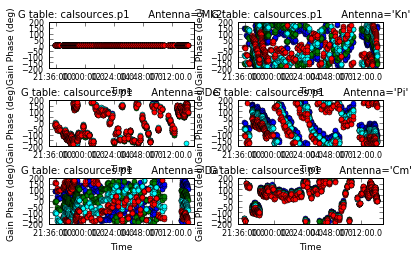

Show log 2018-01-23 11:16:22	INFO	plotcal::tableplot::setgui	Switching to NO-GUI mode. All current plots will be reset.
 2018-01-23 11:16:27	INFO	plotcal::plotcal::createCalTab Detected a NewCalTable!
 2018-01-23 11:16:27	INFO	plotants::::	Now get the data
 2018-01-23 11:16:27	INFO	plotants::::	Done Processing data ... 
 2018-01-23 11:16:29	INFO	plotants::::	Now get the data
 2018-01-23 11:16:29	INFO	plotants::::	Done Processing data ... 
 2018-01-23 11:16:50	INFO	plotants::::	Now get the data
 2018-01-23 11:16:50	INFO	plotants::::	Done Processing data ... 
 2018-01-23 11:16:51	INFO	plotants::::	Now get the data
 2018-01-23 11:16:51	INFO	plotants::::	Done Processing data ... 
 2018-01-23 11:16:51	INFO	plotants::::	Now get the data
 2018-01-23 11:16:51	INFO	plotants::::	Done Processing data ... 
 2018-01-23 11:16:51	INFO	plotants::::	Now get the data
 2018-01-23 11:16:51	INFO	plotants::::	Done Processing data ...

In [55]:
#Plot the solutions separately for L and R for clarity:
plotcal(caltable='calsources.p1',
    xaxis='time',
    yaxis='phase',
    plotrange=[-1,-1,-180,180],
    poln='L',        # Note that solutions are per antenna, hence 'L' not 'LL'
    iteration='antenna',
    subplot=321, 
    showgui=F)

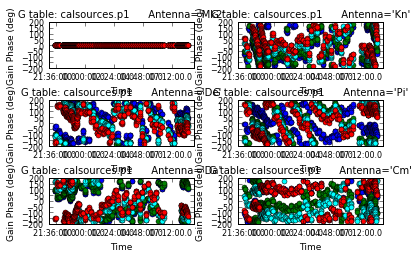

Show log 2018-01-23 11:17:05	INFO	plotcal::tableplot::setgui	Switching to GUI mode. All current plots will be reset.
 2018-01-23 11:17:05	INFO	plotcal::plotcal::createCalTab Detected a NewCalTable!
 2018-01-23 11:17:05	INFO	plotants::::	Now get the data
 2018-01-23 11:17:05	INFO	plotants::::	Done Processing data ... 
 2018-01-23 11:17:05	INFO	plotants::::	Now get the data
 2018-01-23 11:17:05	INFO	plotants::::	Done Processing data ... 
 2018-01-23 11:17:05	INFO	plotants::::	Now get the data
 2018-01-23 11:17:05	INFO	plotants::::	Done Processing data ... 
 2018-01-23 11:17:05	INFO	plotants::::	Now get the data
 2018-01-23 11:17:05	INFO	plotants::::	Done Processing data ... 
 2018-01-23 11:17:05	INFO	plotants::::	Now get the data
 2018-01-23 11:17:05	INFO	plotants::::	Done Processing data ... 
 2018-01-23 11:17:06	INFO	plotants::::	Now get the data
 2018-01-23 11:17:06	INFO	plotants::::	Done Processing data ...

In [56]:
plotcal(caltable='calsources.p1',
    xaxis='time',
    yaxis='phase',
    plotrange=[-1,-1,-180,180],
    poln='R',        # Note that solutions are per antenna, hence 'L' not 'LL'
    iteration='antenna',
    subplot=321, 
    showgui=T)

The phase corrections have a similar time-dependence as the uncorrected data phase, and are not random (if they look just like noise something is wrong)

### Time-dependent amplitude calibration of all calibration source

Derive time-dependent solutions for all the calibration sources, applying the delay and bandpass tables and the time-dependent phase solution table.
At this point, 1331+305 has a realistic model set in the MS. The other calibration sources have the default of a 1 Jy point source at the phase centre. In case you are repeating a failed attempt, reset any previous models for sources other than 1331+305

In [57]:
os.system('rm -rf calsources.ap1')
gaincal(vis=multi_source,
        calmode='ap',
        caltable='calsources.ap1',
        field=calsources,
        solint='180s',
        refant=antref,
        minblperant=2,minsnr=2,
        gaintable=['all_avg.K','bpcal.B1','calsources.p1'],
        interp=['linear','nearest,linear','nearest'])

Show log 2018-01-23 11:17:29	INFO	gaincal::calibrater::open	Opening MS: all_avg.ms for calibration.
 2018-01-23 11:17:29	INFO	gaincal::Calibrater::	Initializing nominal selection to the whole MS.
 2018-01-23 11:17:29	INFO	gaincal::calibrater::setdata	Beginning selectvis--(MSSelection version)-------
 2018-01-23 11:17:29	INFO	gaincal::calibrater::reset	Reseting solve/apply state
 2018-01-23 11:17:29	INFO	gaincal::Calibrater::selectvis	Performing selection on MeasurementSet
 2018-01-23 11:17:29	INFO	gaincal::Calibrater::selectvis+ Selecting on field: '1302+5748,0319+415,1407+284,1331+305'
 2018-01-23 11:17:29	INFO	gaincal::Calibrater::selectvis	By selection 747300 rows are reduced to 338100
 2018-01-23 11:17:30	INFO	gaincal::Calibrater::selectvis	Frequency selection: Selecting all channels in all spws.
 2018-01-23 11:17:30	INFO	gaincal::calibrater::setdata	chanmode=none nchan=1 start=0 step=1 mStart='0km/s' mStep='0km/s' msSelect=''
 2018-01-23 11:17:30	INFO	gaincal::calibrater::setapply	Beginning setapply--(MSSelection version)-------
 2018-01-23 11:17:30	INFO	gaincal::Calibrater::setapply(type, applypar)	Arranging to APPLY:
 2018-01-23 11:17:30	INFO	gaincal:::: (K Jones: Enforcing calWt()=False for phase/delay-like terms)
 2018-01-23 11:17:30	INFO	gaincal::Calibrater::setapply(type, applypar)	. K Jones: table=all_avg.K select= interp=linear spwmap=[-1] calWt=false
 2018-01-23 11:17:30	INFO	gaincal::calibrater::setapply	Beginning setapply--(MSSelection version)-------
 2018-01-23 11:17:30	INFO	gaincal::Calibrater::setapply(type, applypar)	Arranging to APPLY:
 2018-01-23 11:17:30	INFO	gaincal::Calibrater::setapply(type, applypar)	. B Jones: table=bpcal.B1 select= interp=nearest,linear spwmap=[-1] calWt=true
 2018-01-23 11:17:30	INFO	gaincal::calibrater::setapply	Beginning setapply--(MSSelection version)-------
 2018-01-23 11:17:30	INFO	gaincal::Calibrater::setapply(type, applypar)	Arranging to APPLY:
 2018-01-23 11:17:30	INFO	gaincal::Calibrater::setapply(type, applypar)	. G Jones: table=calsources.p1 select= interp=nearest spwmap=[-1] calWt=true
 2018-01-23 11:17:30	INFO	gaincal::calibrater::setsolve	Beginning setsolve--(MSSelection version)-------
 2018-01-23 11:17:30	INFO	gaincal::Calibrater::setsolve	Arranging to SOLVE:
 2018-01-23 11:17:30	INFO	gaincal::Calibrater::setsolve	. G Jones: table=calsources.ap1 append=false solint=180s refant='Mk2' minsnr=2 apmode=AP solnorm=false
 2018-01-23 11:17:30	INFO	gaincal::calibrater::solve	Beginning solve-----------------------------
 2018-01-23 11:17:30	INFO	gaincal::Calibrater::solve	The following calibration terms are arranged for apply:
 2018-01-23 11:17:30	INFO	gaincal::Calibrater::solve	. K Jones: table=all_avg.K select= interp=linear spwmap=[-1] calWt=false
 2018-01-23 11:17:30	INFO	gaincal::Calibrater::solve	. B Jones: table=bpcal.B1 select= interp=nearest,linear spwmap=[-1] calWt=true
 2018-01-23 11:17:30	INFO	gaincal::Calibrater::solve	. G Jones: table=calsources.p1 select= interp=nearest spwmap=[-1] calWt=true
 2018-01-23 11:17:30	INFO	gaincal::Calibrater::solve	The following calibration term is arranged for solve:
 2018-01-23 11:17:30	INFO	gaincal::Calibrater::solve	. G Jones: table=calsources.ap1 append=false solint=180s refant='Mk2' minsnr=2 apmode=AP solnorm=false
 2018-01-23 11:17:30	INFO	gaincal::Calibrater::solve	Solving for G Jones
 2018-01-23 11:17:31	INFO	gaincal::::	For solint = 180s, found 516 solution intervals.
 2018-01-23 11:17:45	INFO	gaincal::Calibrater::solve Found good G Jones solutions in 384 slots.
 2018-01-23 11:17:45	INFO	gaincal::::	Applying refant: Mk2
 2018-01-23 11:17:45	INFO	gaincal::::	Writing solutions to table: calsources.ap1
 2018-01-23 11:17:47	INFO	gaincal::calibrater::solve	Finished solving.
 2018-01-23 11:17:47	INFO	gaincal::::	Calibration solve statistics per spw: (expected/attempted/succeeded):
 2018-01-23 11:17:47	INFO	gaincal:::: Spw 0: 129/96/96
 2018-01-23 11:17:47	INFO	gaincal:::: Spw 1: 129/96/96
 2018-01-23 11:17:47	INFO	gaincal:::

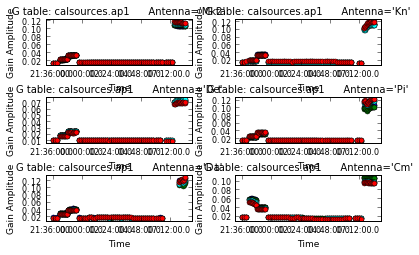

Show log 2018-01-23 11:17:54	INFO	plotcal::tableplot::setgui	Switching to NO-GUI mode. All current plots will be reset.
 2018-01-23 11:17:55	INFO	plotcal::plotcal::createCalTab Detected a NewCalTable!
 2018-01-23 11:17:55	INFO	plotants::::	Now get the data
 2018-01-23 11:17:55	INFO	plotants::::	Done Processing data ... 
 2018-01-23 11:17:55	INFO	plotants::::	Now get the data
 2018-01-23 11:17:55	INFO	plotants::::	Done Processing data ... 
 2018-01-23 11:17:55	INFO	plotants::::	Now get the data
 2018-01-23 11:17:55	INFO	plotants::::	Done Processing data ... 
 2018-01-23 11:17:55	INFO	plotants::::	Now get the data
 2018-01-23 11:17:55	INFO	plotants::::	Done Processing data ... 
 2018-01-23 11:17:55	INFO	plotants::::	Now get the data
 2018-01-23 11:17:55	INFO	plotants::::	Done Processing data ... 
 2018-01-23 11:17:55	INFO	plotants::::	Now get the data
 2018-01-23 11:17:55	INFO	plotants::::	Done Processing data ... 
 2018-01-23 11:17:55	INFO	plotants::::	Saving plot to file calsources.ap1_L.png

In [58]:
# Plot solutions
plotcal(caltable='calsources.ap1',xaxis='time',
    iteration='antenna',yaxis='amp',subplot=321,
    poln='L',figfile='calsources.ap1_L.png',
    showgui=F)

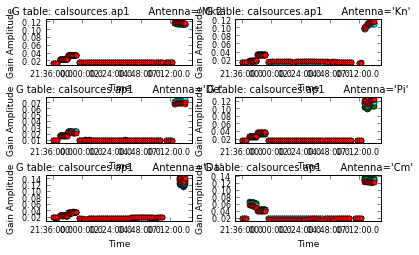

Show log 2018-01-23 11:18:16	INFO	plotcal::tableplot::setgui	Switching to GUI mode. All current plots will be reset.
 2018-01-23 11:18:16	INFO	plotcal::plotcal::createCalTab Detected a NewCalTable!
 2018-01-23 11:18:16	INFO	plotants::::	Now get the data
 2018-01-23 11:18:16	INFO	plotants::::	Done Processing data ... 
 2018-01-23 11:18:16	INFO	plotants::::	Now get the data
 2018-01-23 11:18:16	INFO	plotants::::	Done Processing data ... 
 2018-01-23 11:18:17	INFO	plotants::::	Now get the data
 2018-01-23 11:18:17	INFO	plotants::::	Done Processing data ... 
 2018-01-23 11:18:17	INFO	plotants::::	Now get the data
 2018-01-23 11:18:17	INFO	plotants::::	Done Processing data ... 
 2018-01-23 11:18:17	INFO	plotants::::	Now get the data
 2018-01-23 11:18:17	INFO	plotants::::	Done Processing data ... 
 2018-01-23 11:18:17	INFO	plotants::::	Now get the data
 2018-01-23 11:18:17	INFO	plotants::::	Done Processing data ... 
 2018-01-23 11:18:17	INFO	plotants::::	Saving plot to file calsources.ap1_R.png

In [59]:
# Plot solutions
plotcal(caltable='calsources.ap1',xaxis='time',
    iteration='antenna',yaxis='amp',subplot=321,
    poln='R',figfile='calsources.ap1_R.png',
    showgui=T)

The solutions for each separate source look similar but there are big differences between sources, since they have all (apart from 1331+305) been compared with a 1 Jy model but they have different flux densities.

## 7. Determining flux densities of calibration sources
### Derive calibrator flux densities

The solutions for 1331+305 in calsources.ap1 contain the correct scaling factor to convert the raw units to Jy as well as removing time-dependent errors. This is used to calculate the scaling factor for the other calibration sources in {{fluxscale}}. We run this task in a different way because the calculated fluxes are returned in the form of a python dictionary. They are also written to a text file. Only the best data are used to derive the flux densities but the output is valid for all antennas. This method assumes that all sources without starting models are points, so it cannot be used for an extended target.

In [60]:
os.system('rm -rf calsources.ap1_flux calsources_flux.txt')
calfluxes=fluxscale(vis=multi_source,                 # calfluxes will hold the calculated fluxes in memory 
                    caltable='calsources.ap1',        # Input table containing amplitude solutions          
                    fluxtable='calsources.ap1_flux',  # Scaled output table
                    listfile='calsources_flux.txt',   # Text file on disk listing the calculated fluxes
                    gainthreshold=0.3,                # Exclude solutions >30% from mean
                    antenna='!De',                    # Exclude least sensitive antenna 
                    reference=fluxcal)                # Source with known flux density and previous model 

Show log 2018-01-23 11:19:10	INFO	fluxscale::calibrater::open	Opening MS: all_avg.ms for calibration.
 2018-01-23 11:19:10	INFO	fluxscale::Calibrater::	Initializing nominal selection to the whole MS.
 2018-01-23 11:19:11	INFO	fluxscale::calibrater::fluxscale	Beginning fluxscale--(MSSelection version)-------
 2018-01-23 11:19:11	INFO	fluxscale:::: Assuming all non-reference fields are transfer fields.
 2018-01-23 11:19:11	INFO	fluxscale:::: Found reference field(s): 1331+305
 2018-01-23 11:19:11	INFO	fluxscale:::: Found transfer field(s): 1302+5748 1407+284 0319+415
 2018-01-23 11:19:11	INFO	fluxscale:::: Selected antennas: [0, 1, 3, 4, 5]
 2018-01-23 11:19:12	INFO	fluxscale:::: Applying gain threshold=0.3
 2018-01-23 11:19:12	INFO	fluxscale:::: 1331+305(id=2) Antenna:Cm(id=5): 100 % of 26 solution(s) will be excluded
 2018-01-23 11:19:12	INFO	fluxscale:::: 1331+305(id=2) Antenna:Cm(id=5): 100 % of 26 solution(s) will be excluded
 2018-01-23 11:19:12	INFO	fluxscale:::: 1331+305(id=2) Antenna:Kn(id=1): 53.8 % of 26 solution(s) will be excluded
 2018-01-23 11:19:12	INFO	fluxscale:::: 1331+305(id=2) Antenna:Cm(id=5): 100 % of 26 solution(s) will be excluded
 2018-01-23 11:19:12	INFO	fluxscale:::: 1331+305(id=2) Antenna:Kn(id=1): 26.9 % of 26 solution(s) will be excluded
 2018-01-23 11:19:12	INFO	fluxscale:::: 1331+305(id=2) Antenna:Cm(id=5): 100 % of 26 solution(s) will be excluded
 2018-01-23 11:19:12	INFO	fluxscale:::: 1302+5748(id=0) Antenna:Cm(id=5): 6.25 % of 96 solution(s) will be excluded
 2018-01-23 11:19:12	INFO	fluxscale:::: 1302+5748(id=0) Antenna:Da(id=4): 1.11 % of 90 solution(s) will be excluded
 2018-01-23 11:19:12	INFO	fluxscale:::: 1407+284(id=3) Antenna:Cm(id=5): 50 % of 30 solution(s) will be excluded
 2018-01-23 11:19:12	INFO	fluxscale:::: Flux density for 1302+5748 in SpW=0 (freq=4.88e+09 Hz) is: 0.436022 +/- 0.0707135 (SNR = 6.16604, N = 8)
 2018-01-23 11:19:12	INFO	fluxscale:::: Flux density for 1302+5748 in SpW=1 (freq=5.008e+09 Hz) is: 0.435214 +/- 0.0826746 (SNR = 5.26418, N = 8)
 2018-01-23 11:19:12	INFO	fluxscale:::: Flux density for 1302+5748 in SpW=2 (freq=5.136e+09 Hz) is: 0.425905 +/- 0.0663382 (SNR = 6.4202, N = 7)
 2018-01-23 11:19:12	INFO	fluxscale:::: Flux density for 1302+5748 in SpW=3 (freq=5.264e+09 Hz) is: 0.427283 +/- 0.0673871 (SNR = 6.34072, N = 8)
 2018-01-23 11:19:12	INFO	fluxscale:::: Flux density for 1407+284 in SpW=0 (freq=4.88e+09 Hz) is: 2.11895 +/- 0.142005 (SNR = 14.9216, N = 8)
 2018-01-23 11:19:12	INFO	fluxscale:::: Flux density for 1407+284 in SpW=1 (freq=5.008e+09 Hz) is: 2.01943 +/- 0.167784 (SNR = 12.0359, N = 8)
 2018-01-23 11:19:12	INFO	fluxscale:::: Flux density for 1407+284 in SpW=2 (freq=5.136e+09 Hz) is: 2.00081 +/- 0.127734 (SNR = 15.6638, N = 7)
 2018-01-23 11:19:12	INFO	fluxscale:::: Flux density for 1407+284 in SpW=3 (freq=5.264e+09 Hz) is: 1.96472 +/- 0.133357 (SNR = 14.7327, N = 8)
 2018-01-23 11:19:12	INFO	fluxscale:::: Flux density for 0319+415 in SpW=0 (freq=4.88e+09 Hz) is: 24.1345 +/- 0.514015 (SNR = 46.953, N = 8)
 2018-01-23 11:19:12	INFO	fluxscale:::: Flux density for 0319+415 in SpW=1 (freq=5.008e+09 Hz) is: 24.4026 +/- 0.616783 (SNR = 39.5643, N = 8)
 2018-01-23 11:19:12	INFO	fluxscale:::: Flux density for 0319+415 in SpW=2 (freq=5.136e+09 Hz) is: 24.2954 +/- 0.561006 (SNR = 43.3068, N = 7)
 2018-01-23 11:19:12	INFO	fluxscale:::: Flux density for 0319+415 in SpW=3 (freq=5.264e+09 Hz) is: 24.9791 +/- 0.504486 (SNR = 49.5139, N = 8)
 2018-01-23 11:19:12	INFO	fluxscale:::: Fitted spectrum for 1302+5748 with fitorder=1: Flux density = 0.430859 +/- 0.00156299 (freq=5.06998 GHz) spidx=-0.320294 +/- 0.125347
 2018-01-23 11:19:12	INFO	fluxscale:::: Fitted spectrum for 1407+284 with fitorder=1: Flux density = 2.0279 +/- 0.0114951 (freq=5.06998 GHz) spidx=-0.960845 +/- 0.196041
 2018-01-23 11:19:12	INFO	fluxscale:::: Fitted spectrum for 0319+415 with fitorder=1: Flux density = 24.4611 +/- 0.117436 (freq=5.06998 GHz) spidx=0.40725 +/- 0.160731
 2018-01-23 11:19:1

In [61]:
with open('calsources_flux.txt', 'r') as f:
    for line in f:
        print(line)

# Flux density for 1302+5748 in SpW=0 (freq=4.88e+09 Hz) is: 0.436022 +/- 0.0707135 (SNR = 6.16604, N = 8)

# Flux density for 1302+5748 in SpW=1 (freq=5.008e+09 Hz) is: 0.435214 +/- 0.0826746 (SNR = 5.26418, N = 8)

# Flux density for 1302+5748 in SpW=2 (freq=5.136e+09 Hz) is: 0.425905 +/- 0.0663382 (SNR = 6.4202, N = 7)

# Flux density for 1302+5748 in SpW=3 (freq=5.264e+09 Hz) is: 0.427283 +/- 0.0673871 (SNR = 6.34072, N = 8)

# Flux density for 1407+284 in SpW=0 (freq=4.88e+09 Hz) is: 2.11895 +/- 0.142005 (SNR = 14.9216, N = 8)

# Flux density for 1407+284 in SpW=1 (freq=5.008e+09 Hz) is: 2.01943 +/- 0.167784 (SNR = 12.0359, N = 8)

# Flux density for 1407+284 in SpW=2 (freq=5.136e+09 Hz) is: 2.00081 +/- 0.127734 (SNR = 15.6638, N = 7)

# Flux density for 1407+284 in SpW=3 (freq=5.264e+09 Hz) is: 1.96472 +/- 0.133357 (SNR = 14.7327, N = 8)

# Flux density for 0319+415 in SpW=0 (freq=4.88e+09 Hz) is: 24.1345 +/- 0.514015 (SNR = 46.953, N = 8)

# Flux density for 0319+415 in SpW=1 (f

In [62]:
eMcalfluxes={} 
for k in calfluxes.keys():
    if len(calfluxes[k]) > 4:
        a=[]
        a.append(calfluxes[k]['fitFluxd']*eMfactor)
        a.append(calfluxes[k]['spidx'][0])
        a.append(calfluxes[k]['fitRefFreq'])
        eMcalfluxes[calfluxes[k]['fieldName']]=a
# eMcalfluxes now contains the scaled flux density for each source

In [63]:
eMcalfluxes

{'0319+415': [22.944495581339694, 1.3884756760966461, 5069980155.629359],
 '1302+5748': [0.4041456086127169, -0.3656649741994033, 5069980155.629359],
 '1407+284': [1.9021734179898948, 0.30704726993359355, 5069980155.629359]}

You should see the scaled fluxes; the first column or 'key' is the source name and the values are [flux density (Jy), spectral index and reference frequency (Hz)].

### Setting the calibrator flux densities

Use setjy in a loop to set each of the calibration source flux densities. The logger will report the values being set.

In [64]:
for f in eMcalfluxes.keys():                # For each source in eMcalfluxes
    setjy(vis='all_avg.ms',
          field=f,
          standard='manual',                # Use our values, not a built-in catalogue
          fluxdensity=eMcalfluxes[f][0],
          spix=eMcalfluxes[f][1],
          reffreq=str(eMcalfluxes[f][2])+'Hz')

Show log 2018-01-23 11:20:02	INFO	setjy::::	{'field': '0319+415'}
 2018-01-23 11:20:03	INFO	Imager::open() Opening MeasurementSet /home/jupyter/all_avg.ms
 2018-01-23 11:20:03	INFO	setjy::::	CASA Version 0.4.7 (REL r00)
 2018-01-23 11:20:03	INFO	setjy:::: Tagged on: 2017-02-20 15:48:56 UTC
 2018-01-23 11:20:06	INFO	imager::setjy()	Using channel dependent flux densities
 2018-01-23 11:20:06	INFO	imager::data selection	Selected 54000 out of 747300 rows.
 2018-01-23 11:20:07	INFO	imager::setjy()	Will clear any existing model with matching field=0319+415 and spw=*
 2018-01-23 11:20:07	INFO Clearing model records in MS header for selected fields.
 2018-01-23 11:20:07	INFO 0319+415 (id = 4) not found.
 2018-01-23 11:20:07	INFO	imager::data selection	Selected 13500 out of 747300 rows.
 2018-01-23 11:20:07	INFO	imager::ft() Fourier transforming: replacing visibility model header
 2018-01-23 11:20:07	INFO	imager::createSkyEquation() Processing after subtracting componentlist /home/jupyter/all_avg.ms_setjy_spw0_0319+415_5.06998GHz57147.8d.cl
 2018-01-23 11:20:07	INFO	imager::createFTMachine() Performing interferometric gridding...
 2018-01-23 11:20:07	INFO	imager::data selection	Selected 13500 out of 747300 rows.
 2018-01-23 11:20:07	INFO	imager::ft() Fourier transforming: replacing visibility model header
 2018-01-23 11:20:07	INFO	imager::createSkyEquation() Processing after subtracting componentlist /home/jupyter/all_avg.ms_setjy_spw1_0319+415_5.06998GHz57147.8d.cl
 2018-01-23 11:20:07	INFO	imager::createFTMachine() Performing interferometric gridding...
 2018-01-23 11:20:07	INFO	imager::data selection	Selected 13500 out of 747300 rows.
 2018-01-23 11:20:07	INFO	imager::ft() Fourier transforming: replacing visibility model header
 2018-01-23 11:20:07	INFO	imager::createSkyEquation() Processing after subtracting componentlist /home/jupyter/all_avg.ms_setjy_spw2_0319+415_5.06998GHz57147.8d.cl
 2018-01-23 11:20:07	INFO	imager::createFTMachine() Performing interferometric gridding...
 2018-01-23 11:20:07	INFO	imager::data selection	Selected 13500 out of 747300 rows.
 2018-01-23 11:20:07	INFO	imager::ft() Fourier transforming: replacing visibility model header
 2018-01-23 11:20:07	INFO	imager::createSkyEquation() Processing after subtracting componentlist /home/jupyter/all_avg.ms_setjy_spw3_0319+415_5.06998GHz57147.8d.cl
 2018-01-23 11:20:07	INFO	imager::createFTMachine() Performing interferometric gridding...
 2018-01-23 11:20:07	INFO	imager::setjy()	Flux density as a function of frequency (channel 0 of each spw):
 2018-01-23 11:20:07	INFO	imager::setjy()+ Frequency (GHz) Flux Density (Jy, Stokes I)
 2018-01-23 11:20:07	INFO	imager::setjy() 4.817 21.3714
 2018-01-23 11:20:07	INFO	imager::setjy() 4.945 22.164
 2018-01-23 11:20:07	INFO	imager::setjy() 5.073 22.9646
 2018-01-23 11:20:07	INFO	imager::setjy() 5.201 23.773
 2018-01-23 11:20:08	INFO	setjy::::	{'field': '1302+5748'}
 2018-01-23 11:20:08	INFO	Imager::open() Opening MeasurementSet /home/jupyter/all_avg.ms
 2018-01-23 11:20:08	INFO	setjy::::	CASA Version 0.4.7 (REL r00)
 2018-01-23 11:20:08	INFO	setjy:::: Tagged on: 2017-02-20 15:48:56 UTC
 2018-01-23 11:20:11	INFO	imager::setjy()	Using channel dependent flux densities
 2018-01-23 11:20:11	INFO	imager::data selection	Selected 204900 out of 747300 rows.
 2018-01-23 11:20:12	INFO	imager::setjy()	Will clear any existing model with matching field=1302+5748 and spw=*
 2018-01-23 11:20:12	INFO Clearing model records in MS header for selected fields.
 2018-01-23 11:20:12	INFO 1302+5748 (id = 0) not found.
 2018-01-23 11:20:12	INFO	imager::data selection	Selected 51225 out of 747300 rows.
 2018-01-23 11:20:12	INFO	imager::ft() Fourier transforming: replacing visibility model header
 2018-01-23 11:20:12	INFO	imager::createSkyEquation() Processing after subtracting componentlist /home/jupyter/all_avg.ms_setjy_spw0_1302+5748_5.06998GHz57147.8d.cl
 2018-01-23 11:20:12	INFO	imager::createFTMachine() Performing interferometric gridding...
 2018-0

The default in setjy is to scale by the spectral index for each channel and plotting the models for the bandpass calibrators shows a slope corresponding to the spectral index (zoom in on the fainter source to see this). Both sources have positive spectral indices in this frequency range; this is less unusual for compact, bright QSO than for radio galaxies in general.
#### Plot the  models we have just set

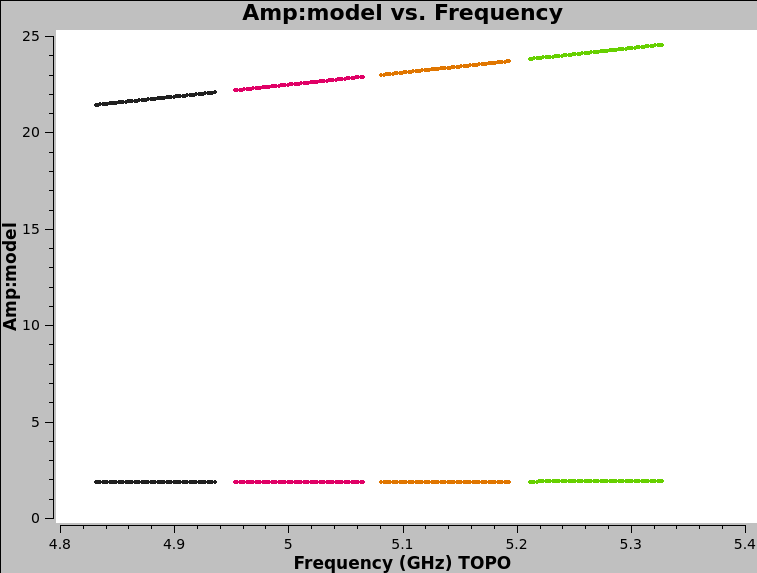

True

Show log 2018-01-23 11:20:45	INFO	PlotMS::params_changed	Updating: REDRAW, MSDATA, CACHE, AXES, CANVAS, DISPLAY, ITERATION, LOG, PLOTMS_OPTIONS.
 2018-01-23 11:20:45	INFO	PlotMS::load_cache	Clearing the existing plotms cache.
 2018-01-23 11:20:45	INFO	PlotMS::load_cache	START Current memory usage: 8521.56 kilobytes.
 2018-01-23 11:20:45	INFO	PlotMS::load_cache	Plot Data Transformations:
 2018-01-23 11:20:45	INFO	PlotMS::load_cache+ Frame = 
 2018-01-23 11:20:45	INFO	PlotMS::load_cache+ VelDef = RADIO
 2018-01-23 11:20:45	INFO	PlotMS::load_cache+ RestFreq = 0 MHz
 2018-01-23 11:20:45	INFO	PlotMS::load_cache+ dX = 0 arcsec
 2018-01-23 11:20:45	INFO	PlotMS::load_cache+ dY = 0 arcsec
 2018-01-23 11:20:45	INFO	PlotMS::load_cache+ formStokes = false
 2018-01-23 11:20:45	INFO	PlotMS::load_cache	Data Averaging: None.
 2018-01-23 11:20:45	INFO	PlotMS::load_cache	Plot Data Calibration:
 2018-01-23 11:20:45	INFO	PlotMS::load_cache+ Use Calibration = 0
 2018-01-23 11:20:45	INFO	PlotMS::load_cache+ Calibration Library = 
 2018-01-23 11:20:45	INFO	PlotMS::load_cache	Caching for the new plot: Amp(17) vs. Frequency(6)...
 2018-01-23 11:20:49	INFO	PlotMS::load_cache	Data selection will yield a total of 5932800 plottable points (flagged and unflagged).
 2018-01-23 11:20:49	INFO	PlotMS::load_cache+	The plotms cache will require an estimated 0.0416532 GB of memory (7.02083 bytes/point).
 2018-01-23 11:20:49	INFO	PlotMS::load_cache+	This is 72.0344% of the memory avail. to CASA (free=0.057824 GB).
 2018-01-23 11:20:50	INFO	PlotMS::load_cache	Loading chunks......
 2018-01-23 11:21:02	INFO	PlotMS::load_cache	Generating the plot mask.
 2018-01-23 11:21:02	INFO	PlotMS::load_cache	refTime = 2015/05/05/00:00:00.0
 2018-01-23 11:21:02	INFO	PlotMS::load_cache	Finished loading.
 2018-01-23 11:21:02	INFO	PlotMS::load_cache	Setting up iteration indexing (if necessary), and calculating plot ranges.
 2018-01-23 11:21:02	INFO	PlotMS::load_cache	Global ranges:
 2018-01-23 11:21:02	INFO	PlotMS::load_cache+	Frequency: 4.831-5.327 (unflagged); 4.817-5.327 (flagged).
 2018-01-23 11:21:02	INFO	PlotMS::load_cache+	Amp: 1.87418-24.5753 (unflagged); 1.87251-24.5753(flagged).
 2018-01-23 11:21:02	INFO	PlotMS::plot	Plotting 4465760 unflagged points.
 2018-01-23 11:20:45	INFO	PlotMS::load_cache	END Time: +16 seconds. Memory: +127540 kilobytes.
 2018-01-23 11:21:03	INFO	plotms::::	Plot file /home/jupyter/plotms_temp.png
 2018-01-23 11:21:29	INFO	plotms::::	Exporting the plot.
 2018-01-23 11:21:30	INFO	plotms::::	Calling pm.save
 2018-01-23 11:21:30	INFO	QPExporter::export	START Current memory usage: 136063 kilobytes.
 2018-01-23 11:21:30	INFO	QPExporter::export	END Time: +30 seconds. Memory: +0.953125 kilobytes.

In [65]:
plotms(vis='all_avg.ms', field=bpcals,      # Plot the bandpass calibrators
    xaxis='frequency', 
    yaxis='amp',ydatacolumn='model',
    coloraxis='spw',correlation='LL',       # Just LL for speed; model is unpolarized
    customsymbol=T,symbolshape='circle',
    symbolsize=5, showgui=F)

## 8.  Improve bandpass with spectral index

#### Use the models including spectral indices to derive a more accurate bandpass correction.

In [66]:
os.system('rm -rf '+bpcal+'.B2')
bandpass(vis=multi_source,
    caltable=bpcal+'.B2',
    field=bpcal,
    fillgaps=16,
    solint='inf',combine='scan',
    refant=antref,
    minblperant=2,
    solnorm=F,
    gaintable=['all_avg.K','calsources.p1','calsources.ap1_flux'], 
    gainfield=bpcal,
    minsnr=3)

Show log 2018-01-23 11:22:27	INFO	bandpass::calibrater::open	Opening MS: all_avg.ms for calibration.
 2018-01-23 11:22:28	INFO	bandpass::Calibrater::	Initializing nominal selection to the whole MS.
 2018-01-23 11:22:29	INFO	bandpass::calibrater::reset	Reseting solve/apply state
 2018-01-23 11:22:29	INFO	bandpass::calibrater::setdata	Beginning selectvis--(MSSelection version)-------
 2018-01-23 11:22:29	INFO	bandpass::calibrater::reset	Reseting solve/apply state
 2018-01-23 11:22:29	INFO	bandpass::Calibrater::selectvis	Performing selection on MeasurementSet
 2018-01-23 11:22:29	INFO	bandpass::Calibrater::selectvis+ Selecting on field: '0319+415'
 2018-01-23 11:22:29	INFO	bandpass::Calibrater::selectvis	By selection 747300 rows are reduced to 54000
 2018-01-23 11:22:29	INFO	bandpass::Calibrater::selectvis	Frequency selection: Selecting all channels in all spws.
 2018-01-23 11:22:29	INFO	bandpass::calibrater::setdata	chanmode=none nchan=1 start=0 step=1 mStart='0km/s' mStep='0km/s' msSelect=''
 2018-01-23 11:22:29	INFO	bandpass::calibrater::setapply	Beginning setapply--(MSSelection version)-------
 2018-01-23 11:22:29	INFO	bandpass::Calibrater::setapply(type, applypar)	Arranging to APPLY:
 2018-01-23 11:22:30	INFO	bandpass:::: (K Jones: Enforcing calWt()=False for phase/delay-like terms)
 2018-01-23 11:22:30	INFO	bandpass::Calibrater::setapply(type, applypar)	. K Jones: table=all_avg.K select= interp=linear spwmap=[-1] calWt=false
 2018-01-23 11:22:30	INFO	bandpass::calibrater::setapply	Beginning setapply--(MSSelection version)-------
 2018-01-23 11:22:30	INFO	bandpass::Calibrater::setapply(type, applypar)	Arranging to APPLY:
 2018-01-23 11:22:30	INFO	bandpass::Calibrater::setapply(type, applypar)	. G Jones: table=calsources.p1 select= interp=linear spwmap=[-1] calWt=true
 2018-01-23 11:22:30	INFO	bandpass::calibrater::setapply	Beginning setapply--(MSSelection version)-------
 2018-01-23 11:22:30	INFO	bandpass::Calibrater::setapply(type, applypar)	Arranging to APPLY:
 2018-01-23 11:22:31	INFO	bandpass::Calibrater::setapply(type, applypar)	. G Jones: table=calsources.ap1_flux select= interp=linear spwmap=[-1] calWt=true
 2018-01-23 11:22:31	INFO	bandpass::calibrater::setsolve	Beginning setsolve--(MSSelection version)-------
 2018-01-23 11:22:31	INFO	bandpass::Calibrater::setsolve	Arranging to SOLVE:
 2018-01-23 11:22:31	INFO	bandpass::Calibrater::setsolve	. B Jones: table=0319+415.B2 append=false solint=inf,none refant='Mk2' minsnr=3 apmode=AP solnorm=false
 2018-01-23 11:22:31	INFO	bandpass::calibrater::solve	Beginning solve-----------------------------
 2018-01-23 11:22:31	INFO	bandpass::Calibrater::solve	The following calibration terms are arranged for apply:
 2018-01-23 11:22:31	INFO	bandpass::Calibrater::solve	. K Jones: table=all_avg.K select= interp=linear spwmap=[-1] calWt=false
 2018-01-23 11:22:31	INFO	bandpass::Calibrater::solve	. G Jones: table=calsources.p1 select= interp=linear spwmap=[-1] calWt=true
 2018-01-23 11:22:31	INFO	bandpass::Calibrater::solve	. G Jones: table=calsources.ap1_flux select= interp=linear spwmap=[-1] calWt=true
 2018-01-23 11:22:31	INFO	bandpass::Calibrater::solve	The following calibration term is arranged for solve:
 2018-01-23 11:22:31	INFO	bandpass::Calibrater::solve	. B Jones: table=0319+415.B2 append=false solint=inf,none refant='Mk2' minsnr=3 apmode=AP solnorm=false
 2018-01-23 11:22:31	INFO	bandpass::Calibrater::solve	Solving for B Jones
 2018-01-23 11:22:31	INFO	bandpass::::	Combining scans.
 2018-01-23 11:22:31	INFO	bandpass::::	For solint = inf, found 4 solution intervals.
 2018-01-23 11:22:38	INFO	bandpass::Calibrater::solve Found good B Jones solutions in 4 slots.
 2018-01-23 11:22:38	INFO	bandpass::::	Applying refant: Mk2
 2018-01-23 11:22:38	INFO	bandpass::::	Filling in flagged solution channels by interpolation.
 2018-01-23 11:22:38	INFO	bandpass::::	Normalizing solutions per spw, pol, ant, time.
 2018-01-23 11:22:38	INFO	bandpass::::	Writing solutions to table: 0319+415.B2
 2018

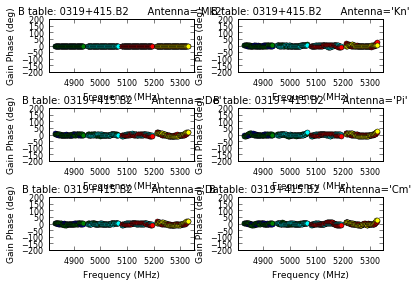

Show log 2018-01-23 11:22:43	INFO	plotcal::tableplot::setgui	Switching to NO-GUI mode. All current plots will be reset.
 2018-01-23 11:22:43	INFO	plotcal::plotcal::createCalTab Detected a NewCalTable!
 2018-01-23 11:22:44	INFO	plotants::::	Now get the data
 2018-01-23 11:22:44	INFO	plotants::::	Done Processing data ... 
 2018-01-23 11:22:46	INFO	plotants::::	Now get the data
 2018-01-23 11:22:46	INFO	plotants::::	Done Processing data ... 
 2018-01-23 11:22:53	INFO	plotants::::	Now get the data
 2018-01-23 11:22:53	INFO	plotants::::	Done Processing data ... 
 2018-01-23 11:22:55	INFO	plotants::::	Now get the data
 2018-01-23 11:22:55	INFO	plotants::::	Done Processing data ... 
 2018-01-23 11:22:56	INFO	plotants::::	Now get the data
 2018-01-23 11:22:56	INFO	plotants::::	Done Processing data ... 
 2018-01-23 11:22:57	INFO	plotants::::	Now get the data
 2018-01-23 11:22:57	INFO	plotants::::	Done Processing data ...

In [67]:
# Plot bandpass phase solutions
plotcal(caltable=bpcal+'.B2',xaxis='freq',
    plotrange=[-1,-1,-180,180],
    iteration='antenna',yaxis='phase',subplot=321,
    showgui=F)

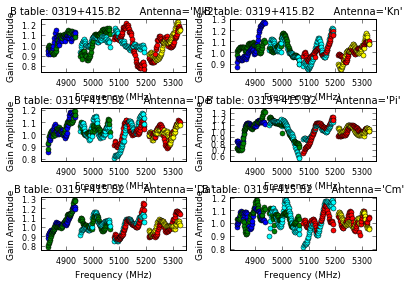

Show log 2018-01-23 11:23:17	INFO	plotcal::tableplot::setgui	Switching to GUI mode. All current plots will be reset.
 2018-01-23 11:23:17	INFO	plotcal::plotcal::createCalTab Detected a NewCalTable!
 2018-01-23 11:23:17	INFO	plotants::::	Now get the data
 2018-01-23 11:23:17	INFO	plotants::::	Done Processing data ... 
 2018-01-23 11:23:18	INFO	plotants::::	Now get the data
 2018-01-23 11:23:18	INFO	plotants::::	Done Processing data ... 
 2018-01-23 11:23:20	INFO	plotants::::	Now get the data
 2018-01-23 11:23:20	INFO	plotants::::	Done Processing data ... 
 2018-01-23 11:23:21	INFO	plotants::::	Now get the data
 2018-01-23 11:23:21	INFO	plotants::::	Done Processing data ... 
 2018-01-23 11:23:23	INFO	plotants::::	Now get the data
 2018-01-23 11:23:23	INFO	plotants::::	Done Processing data ... 
 2018-01-23 11:23:24	INFO	plotants::::	Now get the data
 2018-01-23 11:23:24	INFO	plotants::::	Done Processing data ...

In [68]:
# Plot bandpass amplitude solutions    
plotcal(caltable=bpcal+'.B2',xaxis='freq',
    iteration='antenna',yaxis='amp',subplot=321,
    showgui=T)    

## 9. Derive improved amp solutions with improved bandpass table

For each calibration source, there is now a flux density and spectral index set for the MS Model column, as well as the delay, phase and improved bandpass calibration. These are used to derive time-dependent amplitude solutions which will both correct for short-term errors and contain an accurate flux scale factor.

In [69]:
os.system('rm -rf calsources.ap2')
gaincal(vis=multi_source,
    calmode='ap',
    caltable='calsources.ap2',
    field=calsources,
    solint='inf',
    refant=antref,
    minblperant=2,minsnr=2,
    gaintable=['all_avg.K',bpcal+'.B2','calsources.p1'],
    interp=['linear','nearest,linear','nearest'])

Show log 2018-01-23 11:23:46	INFO	gaincal::calibrater::open	Opening MS: all_avg.ms for calibration.
 2018-01-23 11:23:47	INFO	gaincal::Calibrater::	Initializing nominal selection to the whole MS.
 2018-01-23 11:23:48	INFO	gaincal::calibrater::setdata	Beginning selectvis--(MSSelection version)-------
 2018-01-23 11:23:48	INFO	gaincal::calibrater::reset	Reseting solve/apply state
 2018-01-23 11:23:48	INFO	gaincal::Calibrater::selectvis	Performing selection on MeasurementSet
 2018-01-23 11:23:48	INFO	gaincal::Calibrater::selectvis+ Selecting on field: '1302+5748,0319+415,1407+284,1331+305'
 2018-01-23 11:23:48	INFO	gaincal::Calibrater::selectvis	By selection 747300 rows are reduced to 338100
 2018-01-23 11:23:48	INFO	gaincal::Calibrater::selectvis	Frequency selection: Selecting all channels in all spws.
 2018-01-23 11:23:48	INFO	gaincal::calibrater::setdata	chanmode=none nchan=1 start=0 step=1 mStart='0km/s' mStep='0km/s' msSelect=''
 2018-01-23 11:23:48	INFO	gaincal::calibrater::setapply	Beginning setapply--(MSSelection version)-------
 2018-01-23 11:23:48	INFO	gaincal::Calibrater::setapply(type, applypar)	Arranging to APPLY:
 2018-01-23 11:23:48	INFO	gaincal:::: (K Jones: Enforcing calWt()=False for phase/delay-like terms)
 2018-01-23 11:23:48	INFO	gaincal::Calibrater::setapply(type, applypar)	. K Jones: table=all_avg.K select= interp=linear spwmap=[-1] calWt=false
 2018-01-23 11:23:48	INFO	gaincal::calibrater::setapply	Beginning setapply--(MSSelection version)-------
 2018-01-23 11:23:48	INFO	gaincal::Calibrater::setapply(type, applypar)	Arranging to APPLY:
 2018-01-23 11:23:49	INFO	gaincal::Calibrater::setapply(type, applypar)	. B Jones: table=0319+415.B2 select= interp=nearest,linear spwmap=[-1] calWt=true
 2018-01-23 11:23:49	INFO	gaincal::calibrater::setapply	Beginning setapply--(MSSelection version)-------
 2018-01-23 11:23:49	INFO	gaincal::Calibrater::setapply(type, applypar)	Arranging to APPLY:
 2018-01-23 11:23:49	INFO	gaincal::Calibrater::setapply(type, applypar)	. G Jones: table=calsources.p1 select= interp=nearest spwmap=[-1] calWt=true
 2018-01-23 11:23:49	INFO	gaincal::calibrater::setsolve	Beginning setsolve--(MSSelection version)-------
 2018-01-23 11:23:49	INFO	gaincal::Calibrater::setsolve	Arranging to SOLVE:
 2018-01-23 11:23:49	INFO	gaincal::Calibrater::setsolve	. G Jones: table=calsources.ap2 append=false solint=inf refant='Mk2' minsnr=2 apmode=AP solnorm=false
 2018-01-23 11:23:49	INFO	gaincal::calibrater::solve	Beginning solve-----------------------------
 2018-01-23 11:23:49	INFO	gaincal::Calibrater::solve	The following calibration terms are arranged for apply:
 2018-01-23 11:23:49	INFO	gaincal::Calibrater::solve	. K Jones: table=all_avg.K select= interp=linear spwmap=[-1] calWt=false
 2018-01-23 11:23:49	INFO	gaincal::Calibrater::solve	. B Jones: table=0319+415.B2 select= interp=nearest,linear spwmap=[-1] calWt=true
 2018-01-23 11:23:49	INFO	gaincal::Calibrater::solve	. G Jones: table=calsources.p1 select= interp=nearest spwmap=[-1] calWt=true
 2018-01-23 11:23:49	INFO	gaincal::Calibrater::solve	The following calibration term is arranged for solve:
 2018-01-23 11:23:49	INFO	gaincal::Calibrater::solve	. G Jones: table=calsources.ap2 append=false solint=inf refant='Mk2' minsnr=2 apmode=AP solnorm=false
 2018-01-23 11:23:49	INFO	gaincal::Calibrater::solve	Solving for G Jones
 2018-01-23 11:23:49	INFO	gaincal::::	For solint = inf, found 276 solution intervals.
 2018-01-23 11:24:24	INFO	gaincal::Calibrater::solve Found good G Jones solutions in 208 slots.
 2018-01-23 11:24:24	INFO	gaincal::::	Applying refant: Mk2
 2018-01-23 11:24:24	INFO	gaincal::::	Writing solutions to table: calsources.ap2
 2018-01-23 11:24:25	INFO	gaincal::calibrater::solve	Finished solving.
 2018-01-23 11:24:26	INFO	gaincal::::	Calibration solve statistics per spw: (expected/attempted/succeeded):
 2018-01-23 11:24:26	INFO	gaincal:::: Spw 0: 69/52/52
 2018-01-23 11:24:26	INFO	gaincal:::: Spw 1: 69/52/52
 2018-01-23 11:24:26	INFO	gaincal::

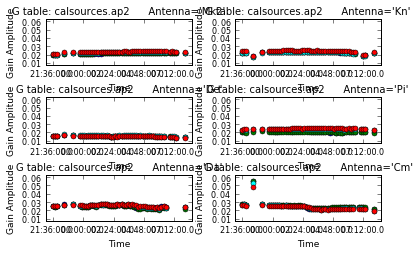

Show log 2018-01-23 11:24:35	INFO	plotcal::tableplot::setgui	Switching to NO-GUI mode. All current plots will be reset.
 2018-01-23 11:24:35	INFO	plotcal::plotcal::createCalTab Detected a NewCalTable!
 2018-01-23 11:24:35	INFO	plotants::::	Now get the data
 2018-01-23 11:24:35	INFO	plotants::::	Done Processing data ... 
 2018-01-23 11:24:35	INFO	plotants::::	Now get the data
 2018-01-23 11:24:35	INFO	plotants::::	Done Processing data ... 
 2018-01-23 11:24:35	INFO	plotants::::	Now get the data
 2018-01-23 11:24:35	INFO	plotants::::	Done Processing data ... 
 2018-01-23 11:24:35	INFO	plotants::::	Now get the data
 2018-01-23 11:24:35	INFO	plotants::::	Done Processing data ... 
 2018-01-23 11:24:35	INFO	plotants::::	Now get the data
 2018-01-23 11:24:35	INFO	plotants::::	Done Processing data ... 
 2018-01-23 11:24:35	INFO	plotants::::	Now get the data
 2018-01-23 11:24:35	INFO	plotants::::	Done Processing data ...

In [71]:
# Plot solutions
plotcal(caltable='calsources.ap2',xaxis='time',
iteration='antenna',yaxis='amp',subplot=321,
    plotrange=[-1,-1,0.01,0.06],
    poln='L', showgui=F)

## 10. Apply solutions to target and calibrators

In [72]:
cals

['0319+415', '1302+5748', '1331+305', '1407+284']

In [73]:
#first apply to the calibrators 
for c in cals:
    applycal(vis=multi_source,
        field=c,
        gainfield=[c, '',c,c],
        calwt=False,
        applymode='calflag',
        gaintable=['all_avg.K',bpcal+'.B2','calsources.p1','calsources.ap2'],
        interp=['linear','nearest,linear','linear','linear'],
        flagbackup=False)

Show log 2018-01-23 11:25:04	INFO	applycal::calibrater::open	Opening MS: all_avg.ms for calibration.
 2018-01-23 11:25:04	INFO	applycal::Calibrater::	Initializing nominal selection to the whole MS.
 2018-01-23 11:25:05	INFO	applycal::calibrater::setdata	Beginning selectvis--(MSSelection version)-------
 2018-01-23 11:25:05	INFO	applycal::calibrater::reset	Reseting solve/apply state
 2018-01-23 11:25:05	INFO	applycal::Calibrater::selectvis	Performing selection on MeasurementSet
 2018-01-23 11:25:05	INFO	applycal::Calibrater::selectvis+ Selecting on field: '0319+415'
 2018-01-23 11:25:05	INFO	applycal::Calibrater::selectvis	By selection 747300 rows are reduced to 54000
 2018-01-23 11:25:05	INFO	applycal::Calibrater::selectvis	Frequency selection: Selecting all channels in all spws.
 2018-01-23 11:25:05	INFO	applycal::calibrater::setdata	chanmode=none nchan=1 start=0 step=1 mStart='0km/s' mStep='0km/s' msSelect=''
 2018-01-23 11:25:05	INFO	applycal::calibrater::setapply	Beginning setapply--(MSSelection version)-------
 2018-01-23 11:25:05	INFO	applycal::Calibrater::setapply(type, applypar)	Arranging to APPLY:
 2018-01-23 11:25:05	INFO	applycal::Calibrater::setapply(type, applypar)	. K Jones: table=all_avg.K select= interp=linear spwmap=[-1] calWt=false
 2018-01-23 11:25:05	INFO	applycal::calibrater::setapply	Beginning setapply--(MSSelection version)-------
 2018-01-23 11:25:05	INFO	applycal::Calibrater::setapply(type, applypar)	Arranging to APPLY:
 2018-01-23 11:25:05	INFO	applycal::Calibrater::setapply(type, applypar)	. B Jones: table=0319+415.B2 select= interp=nearest,linear spwmap=[-1] calWt=false
 2018-01-23 11:25:05	INFO	applycal::calibrater::setapply	Beginning setapply--(MSSelection version)-------
 2018-01-23 11:25:05	INFO	applycal::Calibrater::setapply(type, applypar)	Arranging to APPLY:
 2018-01-23 11:25:05	INFO	applycal::Calibrater::setapply(type, applypar)	. G Jones: table=calsources.p1 select= interp=linear spwmap=[-1] calWt=false
 2018-01-23 11:25:05	INFO	applycal::calibrater::setapply	Beginning setapply--(MSSelection version)-------
 2018-01-23 11:25:05	INFO	applycal::Calibrater::setapply(type, applypar)	Arranging to APPLY:
 2018-01-23 11:25:05	INFO	applycal::Calibrater::setapply(type, applypar)	. G Jones: table=calsources.ap2 select= interp=linear spwmap=[-1] calWt=false
 2018-01-23 11:25:05	INFO	applycal::calibrater::correct	Beginning correct---------------------------
 2018-01-23 11:25:05	INFO	applycal::Calibrater::correct2 (VI2/VB2)	The following calibration terms are arranged for apply:
 2018-01-23 11:25:05	INFO	applycal::Calibrater::correct2 (VI2/VB2)	. K Jones: table=all_avg.K select= interp=linear spwmap=[-1] calWt=false
 2018-01-23 11:25:05	INFO	applycal::Calibrater::correct2 (VI2/VB2)	. B Jones: table=0319+415.B2 select= interp=nearest,linear spwmap=[-1] calWt=false
 2018-01-23 11:25:05	INFO	applycal::Calibrater::correct2 (VI2/VB2)	. G Jones: table=calsources.p1 select= interp=linear spwmap=[-1] calWt=false
 2018-01-23 11:25:05	INFO	applycal::Calibrater::correct2 (VI2/VB2)	. G Jones: table=calsources.ap2 select= interp=linear spwmap=[-1] calWt=false
 2018-01-23 11:25:07	INFO	applycal::calibrater::correct	Finished correcting.
 2018-01-23 11:25:07	INFO	applycal::::	Calibration apply flagging statistics (among calibrateable spws):
 2018-01-23 11:25:07	INFO	applycal:::: Total selected visibilities (among calibrateable spws) = 13824000
 2018-01-23 11:25:07	INFO	applycal:::: Flags:
 2018-01-23 11:25:07	INFO	applycal:::: K Jones: In: 4422400 (31.9907407407%) --> Out: 4422400 (31.9907407407%) (all_avg.K)
 2018-01-23 11:25:07	INFO	applycal:::: B Jones: In: 4422400 (31.9907407407%) --> Out: 4422400 (31.9907407407%) (0319+415.B2)
 2018-01-23 11:25:07	INFO	applycal:::: G Jones: In: 4422400 (31.9907407407%) --> Out: 4426920 (32.0234375%) (calsources.p1)
 2018-01-23 11:25:07	INFO	applycal:::: G Jones: In: 4426920 (32.0234375%) --> Out: 4426920 (32.0234375%) (calsources.ap2)
 2018-01-23 11:25:08	INFO	applycal::::	CASA Ve

Apply the phase-ref solutions to the target. We assume that the phase reference scans bracket the target scans so linear interpolation is used except for bandpass.

In [74]:
applycal(vis=multi_source,
     field=target,
     gainfield=[phref,'',phref,phref],
     calwt=False,
     applymode='calflag',                  # Not too many failed solutions - OK to flag target data
     gaintable=['all_avg.K',bpcal+'.B2','calsources.p1','calsources.ap2'],
     interp=['linear','nearest,linear','linear','linear'],
     flagbackup=True)

Show log 2018-01-23 11:26:02	INFO	applycal::calibrater::open	Opening MS: all_avg.ms for calibration.
 2018-01-23 11:26:02	INFO	applycal::Calibrater::	Initializing nominal selection to the whole MS.
 2018-01-23 11:26:03	INFO	applycal::AgentFlagger::open	Table type is Measurement Set
 2018-01-23 11:26:03	INFO	plotants::::	Creating new backup flag file called applycal_1
 2018-01-23 11:26:04	INFO	calibrater::setdata	Beginning selectvis--(MSSelection version)-------
 2018-01-23 11:26:04	INFO	calibrater::reset	Reseting solve/apply state
 2018-01-23 11:26:04	INFO	Calibrater::selectvis	Performing selection on MeasurementSet
 2018-01-23 11:26:04	INFO	Calibrater::selectvis+ Selecting on field: '1252+5634'
 2018-01-23 11:26:04	INFO	Calibrater::selectvis	By selection 747300 rows are reduced to 409200
 2018-01-23 11:26:05	INFO	Calibrater::selectvis	Frequency selection: Selecting all channels in all spws.
 2018-01-23 11:26:05	INFO	calibrater::setdata	chanmode=none nchan=1 start=0 step=1 mStart='0km/s' mStep='0km/s' msSelect=''
 2018-01-23 11:26:05	INFO	calibrater::setapply	Beginning setapply--(MSSelection version)-------
 2018-01-23 11:26:05	INFO	Calibrater::setapply(type, applypar)	Arranging to APPLY:
 2018-01-23 11:26:05	INFO	Calibrater::setapply(type, applypar)	. K Jones: table=all_avg.K select= interp=linear spwmap=[-1] calWt=false
 2018-01-23 11:26:05	INFO	calibrater::setapply	Beginning setapply--(MSSelection version)-------
 2018-01-23 11:26:05	INFO	Calibrater::setapply(type, applypar)	Arranging to APPLY:
 2018-01-23 11:26:05	INFO	Calibrater::setapply(type, applypar)	. B Jones: table=0319+415.B2 select= interp=nearest,linear spwmap=[-1] calWt=false
 2018-01-23 11:26:05	INFO	calibrater::setapply	Beginning setapply--(MSSelection version)-------
 2018-01-23 11:26:05	INFO	Calibrater::setapply(type, applypar)	Arranging to APPLY:
 2018-01-23 11:26:05	INFO	Calibrater::setapply(type, applypar)	. G Jones: table=calsources.p1 select= interp=linear spwmap=[-1] calWt=false
 2018-01-23 11:26:05	INFO	calibrater::setapply	Beginning setapply--(MSSelection version)-------
 2018-01-23 11:26:05	INFO	Calibrater::setapply(type, applypar)	Arranging to APPLY:
 2018-01-23 11:26:05	INFO	Calibrater::setapply(type, applypar)	. G Jones: table=calsources.ap2 select= interp=linear spwmap=[-1] calWt=false
 2018-01-23 11:26:05	INFO	calibrater::correct	Beginning correct---------------------------
 2018-01-23 11:26:05	INFO	Calibrater::correct2 (VI2/VB2)	The following calibration terms are arranged for apply:
 2018-01-23 11:26:05	INFO	Calibrater::correct2 (VI2/VB2)	. K Jones: table=all_avg.K select= interp=linear spwmap=[-1] calWt=false
 2018-01-23 11:26:05	INFO	Calibrater::correct2 (VI2/VB2)	. B Jones: table=0319+415.B2 select= interp=nearest,linear spwmap=[-1] calWt=false
 2018-01-23 11:26:05	INFO	Calibrater::correct2 (VI2/VB2)	. G Jones: table=calsources.p1 select= interp=linear spwmap=[-1] calWt=false
 2018-01-23 11:26:05	INFO	Calibrater::correct2 (VI2/VB2)	. G Jones: table=calsources.ap2 select= interp=linear spwmap=[-1] calWt=false
 2018-01-23 11:26:24	INFO	calibrater::correct	Finished correcting.
 2018-01-23 11:26:24	INFO	applycal::::	Calibration apply flagging statistics (among calibrateable spws):
 2018-01-23 11:26:24	INFO	applycal:::: Total selected visibilities (among calibrateable spws) = 104755200
 2018-01-23 11:26:24	INFO	applycal:::: Flags:
 2018-01-23 11:26:24	INFO	applycal:::: K Jones: In: 48990214 (46.7663791392%) --> Out: 49492838 (47.2461873014%) (all_avg.K)
 2018-01-23 11:26:24	INFO	applycal:::: B Jones: In: 49492838 (47.2461873014%) --> Out: 49492838 (47.2461873014%) (0319+415.B2)
 2018-01-23 11:26:24	INFO	applycal:::: G Jones: In: 49492838 (47.2461873014%) --> Out: 50297398 (48.0142255468%) (calsources.p1)
 2018-01-23 11:26:24	INFO	applycal:::: G Jones: In: 50297398 (48.0142255468%) --> Out: 50297398 (48.0142255468%) (calsources.ap2)
 2018-01-23 11:26:26	INFO	applycal::::	CASA Version 0.4.7 (REL r00)
 2018-01-23 11:26:26	INFO	applycal:::: Tagged 

**Plot phase-ref and target amps against uv distance**

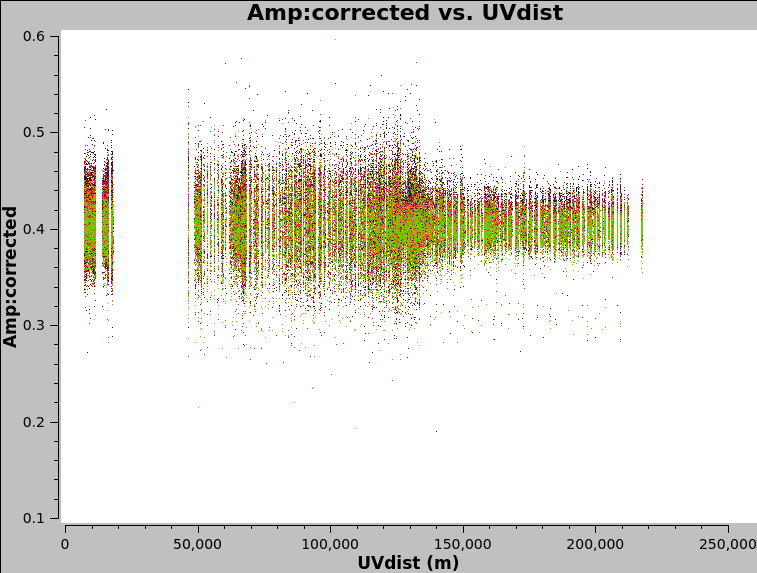

True

Show log 2018-01-23 11:27:03	INFO	PlotMS::params_changed	Updating: REDRAW, MSDATA, CACHE, AXES, CANVAS, DISPLAY, ITERATION, LOG, PLOTMS_OPTIONS.
 2018-01-23 11:27:03	INFO	PlotMS::load_cache	Clearing the existing plotms cache.
 2018-01-23 11:27:03	INFO	PlotMS::load_cache	START Current memory usage: 8550.84 kilobytes.
 2018-01-23 11:27:03	INFO	PlotMS::load_cache	Plot Data Transformations:
 2018-01-23 11:27:03	INFO	PlotMS::load_cache+ Frame = 
 2018-01-23 11:27:03	INFO	PlotMS::load_cache+ VelDef = RADIO
 2018-01-23 11:27:03	INFO	PlotMS::load_cache+ RestFreq = 0 MHz
 2018-01-23 11:27:03	INFO	PlotMS::load_cache+ dX = 0 arcsec
 2018-01-23 11:27:03	INFO	PlotMS::load_cache+ dY = 0 arcsec
 2018-01-23 11:27:03	INFO	PlotMS::load_cache+ formStokes = false
 2018-01-23 11:27:03	INFO	PlotMS::load_cache	Data Averaging: 
 2018-01-23 11:27:03	INFO	PlotMS::load_cache+ Using VECTOR averaging.
 2018-01-23 11:27:03	INFO	PlotMS::load_cache+ Channel: 64 channels
 2018-01-23 11:27:03	INFO	PlotMS::load_cache	Plot Data Calibration:
 2018-01-23 11:27:03	INFO	PlotMS::load_cache+ Use Calibration = 0
 2018-01-23 11:27:03	INFO	PlotMS::load_cache+ Calibration Library = 
 2018-01-23 11:27:03	INFO	PlotMS::load_cache	Caching for the new plot: Amp(17) vs. UVdist(28)...
 2018-01-23 11:27:09	INFO	PlotMS::load_cache	Data selection will yield a total of 409800 plottable points (flagged and unflagged).
 2018-01-23 11:27:09	INFO	PlotMS::load_cache+	The plotms cache will require an estimated 0.00721248 GB of memory (17.6 bytes/point).
 2018-01-23 11:27:09	INFO	PlotMS::load_cache+	This is 5.80042% of the memory avail. to CASA (free=0.124344 GB).
 2018-01-23 11:27:09	INFO	PlotMS::load_cache	Loading chunks......
 2018-01-23 11:27:20	INFO	PlotMS::load_cache	SPW 0: number of channels averaged = 64
 2018-01-23 11:27:20	INFO	PlotMS::load_cache	SPW 1: number of channels averaged = 64
 2018-01-23 11:27:20	INFO	PlotMS::load_cache	SPW 2: number of channels averaged = 64
 2018-01-23 11:27:20	INFO	PlotMS::load_cache	SPW 3: number of channels averaged = 64
 2018-01-23 11:27:20	INFO	PlotMS::load_cache	Generating the plot mask.
 2018-01-23 11:27:20	INFO	PlotMS::load_cache	refTime = 2015/05/05/00:00:00.0
 2018-01-23 11:27:20	INFO	PlotMS::load_cache	Finished loading.
 2018-01-23 11:27:20	INFO	PlotMS::load_cache	Setting up iteration indexing (if necessary), and calculating plot ranges.
 2018-01-23 11:27:20	INFO	PlotMS::load_cache	Global ranges:
 2018-01-23 11:27:20	INFO	PlotMS::load_cache+	UVdist: 7070.28-217462 (unflagged); 7069.88-217446 (flagged).
 2018-01-23 11:27:20	INFO	PlotMS::load_cache+	Amp: 0.190969-0.597491 (unflagged); 0-1.10657(flagged).
 2018-01-23 11:27:20	INFO	PlotMS::plot	Plotting 155672 unflagged points.
 2018-01-23 11:27:03	INFO	PlotMS::load_cache	END Time: +18 seconds. Memory: +200432 kilobytes.
 2018-01-23 11:27:20	INFO	plotms::::	Plot file /home/jupyter/plotms_temp.png
 2018-01-23 11:27:21	INFO	plotms::::	Exporting the plot.
 2018-01-23 11:27:21	INFO	plotms::::	Calling pm.save
 2018-01-23 11:27:21	INFO	QPExporter::export	START Current memory usage: 208982 kilobytes.
 2018-01-23 11:27:21	INFO	QPExporter::export	END Time: +1 seconds. Memory: +0.953125 kilobytes.

In [75]:
plotms(vis=multi_source, 
    field=phref, xaxis='uvdist', 
    yaxis='amp',ydatacolumn='corrected',
    avgchannel='64',correlation='LL,RR',
    overwrite=True,                   
    coloraxis='spw',showgui=F)

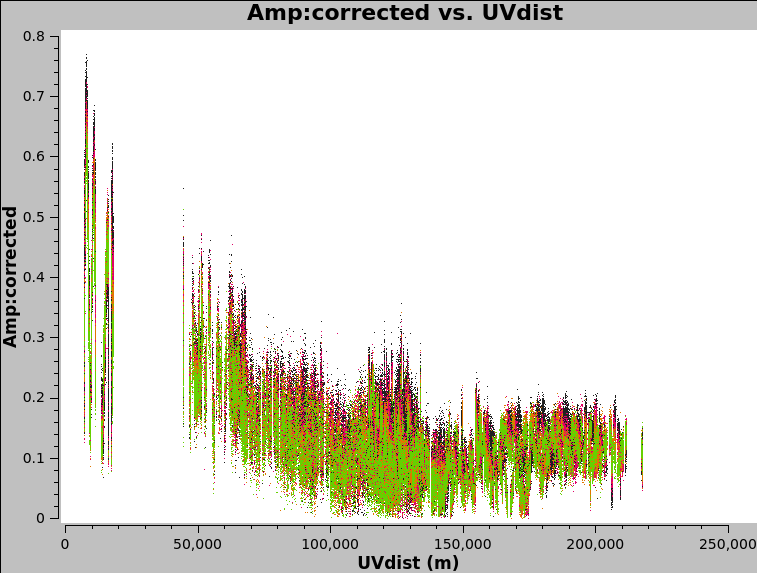

True

Show log 2018-01-23 11:27:33	INFO	PlotMS::params_changed	Updating: REDRAW, MSDATA, CACHE, AXES, CANVAS, DISPLAY, ITERATION, LOG, PLOTMS_OPTIONS.
 2018-01-23 11:27:33	INFO	PlotMS::load_cache	Clearing the existing plotms cache.
 2018-01-23 11:27:33	INFO	PlotMS::load_cache	START Current memory usage: 8565.67 kilobytes.
 2018-01-23 11:27:33	INFO	PlotMS::load_cache	Plot Data Transformations:
 2018-01-23 11:27:33	INFO	PlotMS::load_cache+ Frame = 
 2018-01-23 11:27:33	INFO	PlotMS::load_cache+ VelDef = RADIO
 2018-01-23 11:27:33	INFO	PlotMS::load_cache+ RestFreq = 0 MHz
 2018-01-23 11:27:33	INFO	PlotMS::load_cache+ dX = 0 arcsec
 2018-01-23 11:27:33	INFO	PlotMS::load_cache+ dY = 0 arcsec
 2018-01-23 11:27:33	INFO	PlotMS::load_cache+ formStokes = false
 2018-01-23 11:27:33	INFO	PlotMS::load_cache	Data Averaging: 
 2018-01-23 11:27:33	INFO	PlotMS::load_cache+ Using VECTOR averaging.
 2018-01-23 11:27:33	INFO	PlotMS::load_cache+ Channel: 64 channels
 2018-01-23 11:27:33	INFO	PlotMS::load_cache	Plot Data Calibration:
 2018-01-23 11:27:33	INFO	PlotMS::load_cache+ Use Calibration = 0
 2018-01-23 11:27:33	INFO	PlotMS::load_cache+ Calibration Library = 
 2018-01-23 11:27:33	INFO	PlotMS::load_cache	Caching for the new plot: Amp(17) vs. UVdist(28)...
 2018-01-23 11:27:39	INFO	PlotMS::load_cache	Data selection will yield a total of 818400 plottable points (flagged and unflagged).
 2018-01-23 11:27:39	INFO	PlotMS::load_cache+	The plotms cache will require an estimated 0.0144038 GB of memory (17.6 bytes/point).
 2018-01-23 11:27:39	INFO	PlotMS::load_cache+	This is 36.5988% of the memory avail. to CASA (free=0.039356 GB).
 2018-01-23 11:27:39	INFO	PlotMS::load_cache	Loading chunks......
 2018-01-23 11:28:02	INFO	PlotMS::load_cache	SPW 0: number of channels averaged = 64
 2018-01-23 11:28:02	INFO	PlotMS::load_cache	SPW 1: number of channels averaged = 64
 2018-01-23 11:28:02	INFO	PlotMS::load_cache	SPW 2: number of channels averaged = 64
 2018-01-23 11:28:02	INFO	PlotMS::load_cache	SPW 3: number of channels averaged = 64
 2018-01-23 11:28:02	INFO	PlotMS::load_cache	Generating the plot mask.
 2018-01-23 11:28:03	INFO	PlotMS::load_cache	refTime = 2015/05/05/00:00:00.0
 2018-01-23 11:28:03	INFO	PlotMS::load_cache	Finished loading.
 2018-01-23 11:28:03	INFO	PlotMS::load_cache	Setting up iteration indexing (if necessary), and calculating plot ranges.
 2018-01-23 11:28:04	INFO	PlotMS::load_cache	Global ranges:
 2018-01-23 11:28:04	INFO	PlotMS::load_cache+	UVdist: 6878.97-217488 (unflagged); 6879.79-217488 (flagged).
 2018-01-23 11:28:04	INFO	PlotMS::load_cache+	Amp: 0.000273474-0.770196 (unflagged); 0-1.86886(flagged).
 2018-01-23 11:28:04	INFO	PlotMS::plot	Plotting 481928 unflagged points.
 2018-01-23 11:27:33	INFO	PlotMS::load_cache	END Time: +30 seconds. Memory: +400103 kilobytes.
 2018-01-23 11:28:06	INFO	plotms::::	Plot file /home/jupyter/plotms_temp.png
 2018-01-23 11:28:08	INFO	plotms::::	Exporting the plot.
 2018-01-23 11:28:08	INFO	plotms::::	Calling pm.save
 2018-01-23 11:28:09	INFO	QPExporter::export	START Current memory usage: 408666 kilobytes.
 2018-01-23 11:28:09	INFO	QPExporter::export	END Time: +3 seconds. Memory: +0.953125 kilobytes.

In [76]:
# Check target
plotms(vis=multi_source, 
    field=target, xaxis='uvdist', 
    yaxis='amp',ydatacolumn='corrected',
    avgchannel='64',correlation='LL,RR',
    overwrite=True,                  
    coloraxis='spw',
    showgui=F)

**QUESTION 6** What do the plots of amplitude against uv distance tell you? [Answer](Answer_6.html)

Note: If there is just a little bad data, no need to worry if the target is bright enough to self-calibrate

## 11. Split out target

At this point we are happy with the solutions and the final results. The next stage is to split-out the target MS with the solutions applied, so we can make some images!

In [77]:
os.system('rm -rf '+target+'.ms*')
split(vis=multi_source, 
    field=target, 
    outputvis=target+'.ms',
    keepflags=False)

True

Show log 2018-01-23 11:28:44	INFO	MSTransformManager::parseMsSpecParams	Input file name is all_avg.ms
 2018-01-23 11:28:44	INFO	MSTransformManager::parseMsSpecParams	Data column is CORRECTED
 2018-01-23 11:28:44	INFO	MSTransformManager::parseMsSpecParams	Output file name is 1252+5634.ms
 2018-01-23 11:28:44	INFO	MSTransformManager::parseDataSelParams	field selection is 1252+5634
 2018-01-23 11:28:44	INFO	MSTransformManager::colCheckInfo	Adding DATA column to output MS from input CORRECTED_DATA column
 2018-01-23 11:28:44	INFO	MSTransformManager::initDataSelectionParams	Selected Fields Ids are [1]
 2018-01-23 11:28:44	INFO	MSTransformManager::open	Select data
 2018-01-23 11:28:44	INFO	MSTransformManager::open	Create output MS structure
 2018-01-23 11:28:46	INFO	MSTransformDataHandler::makeSelection	240964 out of 747300 rows are going to be considered due to the selection criteria.
 2018-01-23 11:29:01	INFO	split::::	CASA Version 0.4.7 (REL r00)
 2018-01-23 11:29:01	INFO	split:::: Tagged on: 2017-02-20 15:48:56 UTC

## 12. IMAGING AND SELF-CALIBRATION


In [78]:
os.system('rm -rf '+target+'_1.clean*')
clean(vis=target+'.ms',
      imagename=target+'_1.clean',
      cell='0.012arcsec',
      niter=500,
      imsize=512,
      interactive=False)

Show log 2018-01-23 11:29:16	INFO	clean::::	nchan=-1 start=0 width=1
 2018-01-23 11:29:16	INFO	clean::::	Use default channelization for clean
 2018-01-23 11:29:16	INFO	clean::::	clean image: 1252+5634_1.clean
 2018-01-23 11:29:17	INFO	clean::::	FTMachine used is ft 
 2018-01-23 11:29:17	INFO	imager::setDataOnThisMS()	Performing selection on MeasurementSet : /home/jupyter/1252+5634.ms
 2018-01-23 11:29:17	INFO	imager::setDataOnThisMS()	Selecting on fields : 0
 2018-01-23 11:29:17	INFO	imager::setDataOnThisMS()	Selecting on spectral windows expression :*
 2018-01-23 11:29:17	INFO	imager::setDataOnThisMS()	Selected all 240964 rows
 2018-01-23 11:29:17	INFO	imager::setDataOnThisMS()	Selected : [64 chans in spw 0] [64 chans in spw 1] [64 chans in spw 2] [64 chans in spw 3]
 2018-01-23 11:29:17	INFO	msmetadata_cmpt.cc::open	Performing internal consistency checks on 1252+5634.ms...
 2018-01-23 11:29:17	INFO	msmetadata_cmpt.cc::open	Performing internal consistency checks on 1252+5634.ms...
 2018-01-23 11:29:18	INFO	imager::defineimage()	Defining image properties:nx=512 ny=512 cellx='0.012arcsec' celly='0.012arcsec' stokes=I' mode=MFS nchan=-1 start=0 step=1 spwids=[-1] fieldid=-1 facets=1 frame=5 distance='0'
 2018-01-23 11:29:18	INFO	imager::defineimage() phaseCenter='12:52:26.29, 56.34.19.49, ' mStart='Radialvelocity: 0' qStep='0 '' mFreqStart='Frequency: 0
 2018-01-23 11:29:20	INFO	Imager::setvp() Setting voltage pattern parameters
 2018-01-23 11:29:20	INFO	Imager::setvp() Sky position tolerance is 180 degrees
 2018-01-23 11:29:20	INFO	Imager::setvp() Using system default voltage patterns for each telescope
 2018-01-23 11:29:20	INFO	imager::makeimage() Calculating image (without full skyequation)
 2018-01-23 11:29:21	WARN	imager::makeimage() (file /usr/local/casa/code/synthesis/MeasurementEquations/Imager.cc, line 2973)	The MS has multiple antenna diameters ..PB could be wrong 
 2018-01-23 11:29:23	INFO	Imager::setvp() Setting voltage pattern parameters
 2018-01-23 11:29:23	INFO	imager::weight()	Weighting MS: Imaging weights will be changed
 2018-01-23 11:29:23	INFO	imager::weight()	Natural weighting
 2018-01-23 11:29:23	INFO	clean::::	Used mask(s) : [''] to create mask image(s) : 1252+5634_1.clean.mask
 2018-01-23 11:29:23	INFO	imager::setoptions() Setting processing options
 2018-01-23 11:29:23	INFO	clean::::	No model found. Making empty initial model : 1252+5634_1.clean.model
 2018-01-23 11:29:24	INFO	Imager::imagecoordinates() Center frequency = 5.07209 GHz, synthesized continuum bandwidth = 0.512013 GHz
 2018-01-23 11:29:24	INFO	imager::clean()	Using multifield Clark clean
 2018-01-23 11:29:24	INFO	imager::createFTMachine() Multiple fields or facets: transforms will be padded by a factor 1.2
 2018-01-23 11:29:24	INFO	imager::createFTMachine() Performing interferometric gridding...
 2018-01-23 11:29:25	INFO	imager::clean()	Clean gain = 0.1, Niter = 500, Threshold = 0 mJy
 2018-01-23 11:29:25	INFO	imager::clean()	Starting deconvolution
 2018-01-23 11:29:34	INFO	ImageSkyModel::makeApproxPSFs	bmaj: 0.0649763", bmin: 0.0533521", bpa: 10.1155 deg
 2018-01-23 11:29:34	INFO	MFCleanImageSkyModel::solve	*** Starting major cycle 0
 2018-01-23 11:29:44	INFO	MFCleanImageSkyModel::solve	The minor-cycle threshold is MAX[ 0.95 x 0 , peak residual x 0.43587 ] 
 2018-01-23 11:29:44	INFO	MFCleanImageSkyModel::solve	Maximum residual = 0.16719, cleaning down to 0.0728731
 2018-01-23 11:29:44	INFO	MFCleanImageSkyModel::solve	Processing model 0
 2018-01-23 11:29:44	INFO	ClarkCleanModel::singleSolve	Initial maximum residual: 0.16719
 2018-01-23 11:29:44	INFO	MFCleanImageSkyModel::solve	Finished Clark clean inner cycle 
 2018-01-23 11:29:44	INFO	MFCleanImageSkyModel::solve	Clean used 11 iterations to approach a threshhold of 0.0728731
 2018-01-23 11:29:44	INFO	MFCleanImageSkyModel::solve	0.122994 Jy <- cleaned in this cycle for model 0 (Total flux : 0.122994Jy)
 2018-01-23 11:29:44	INFO	MFCleanImageSkyModel::solve	*** Starting major cycle 1
 2018-01-2

In [79]:
rms1=imstat(imagename=target+'_1.clean.image',
              box='10,400,199,499')['rms'][0]
peak1=imstat(imagename=target+'_1.clean.image',
              box='10,10,499,499')['max'][0]

print target+'_1.clean.image rms %7.3f mJy' % (rms1*1000.)
print target+'_1.clean.image peak %7.3f mJy/bm' % (peak1*1000.)

1252+5634_1.clean.image rms   1.585 mJy
1252+5634_1.clean.image peak 142.773 mJy/bm


Show log 2018-01-23 11:31:40	INFO	imstat::CasacRegionManager::fromBCS	Using specified box(es) 10,400,199,499
 2018-01-23 11:31:40	INFO	imstat::image::statistics Determining stats for image 1252+5634_1.clean.image
 2018-01-23 11:31:40	INFO	imstat::ImageRegion::fromRecord	Selected bounding box : 
 2018-01-23 11:31:40	INFO	imstat::ImageRegion::fromRecord+ [10, 400, 0, 0] to [199, 499, 0, 0] (12:52:26.643, +56.34.21.216, I, 5.072e+09Hz to 12:52:26.369, +56.34.22.404, I, 5.072e+09Hz)
 2018-01-23 11:31:40	INFO	imstat::ImageStatsCalculator::statistics	Statistics calculated using Classic algorithm
 2018-01-23 11:31:40	INFO	imstat::ImageStatsCalculator::statistics	Regions --- 
 2018-01-23 11:31:40	INFO	imstat::ImageStatsCalculator::statistics -- bottom-left corner (pixel) [blc]: [10, 400, 0, 0]
 2018-01-23 11:31:40	INFO	imstat::ImageStatsCalculator::statistics -- top-right corner (pixel) [trc]: [199, 499, 0, 0]
 2018-01-23 11:31:40	INFO	imstat::ImageStatsCalculator::statistics -- bottom-left corner (world) [blcf]: 12:52:26.6431, +56.34.21.2160, I, 5.072e+09Hz
 2018-01-23 11:31:40	INFO	imstat::ImageStatsCalculator::statistics -- top-right corner (world) [trcf]: 12:52:26.3687, +56.34.22.4040, I, 5.072e+09Hz
 2018-01-23 11:31:40	INFO	imstat::ImageStatsCalculator::statistics	Computing quantiles...
 2018-01-23 11:31:40	INFO	imstat::::	Values --- 
 2018-01-23 11:31:40	INFO	imstat:::: -- flux density [flux]: 0.141054 Jy
 2018-01-23 11:31:40	INFO	imstat:::: -- number of points [npts]: 19000
 2018-01-23 11:31:40	INFO	imstat:::: -- maximum value [max]: 0.00458745 Jy/beam
 2018-01-23 11:31:40	INFO	imstat:::: -- minimum value [min]: -0.0040033 Jy/beam
 2018-01-23 11:31:40	INFO	imstat:::: -- position of max value (pixel) [maxpos]: [12, 479, 0, 0]
 2018-01-23 11:31:40	INFO	imstat:::: -- position of min value (pixel) [minpos]: [139, 481, 0, 0]
 2018-01-23 11:31:40	INFO	imstat:::: -- position of max value (world) [maxposf]: 12:52:26.6402, +56.34.22.1640, I, 5.072e+09Hz
 2018-01-23 11:31:40	INFO	imstat:::: -- position of min value (world) [minposf]: 12:52:26.4558, +56.34.22.1880, I, 5.072e+09Hz
 2018-01-23 11:31:40	INFO	imstat:::: -- Sum of pixel values [sum]: 3.84764 Jy/beam
 2018-01-23 11:31:40	INFO	imstat:::: -- Sum of squared pixel values [sumsq]: 0.0477315 Jy/beam.Jy/beam
 2018-01-23 11:31:40	INFO	imstat::::	Statistics --- 
 2018-01-23 11:31:40	INFO	imstat:::: -- Mean of the pixel values [mean]: 0.000202508 Jy/beam
 2018-01-23 11:31:40	INFO	imstat:::: -- Variance of the pixel values : 2.4713e-06 Jy/beam
 2018-01-23 11:31:40	INFO	imstat:::: -- Standard deviation of the Mean [sigma]: 0.00157204 Jy/beam
 2018-01-23 11:31:40	INFO	imstat:::: -- Root mean square [rms]: 0.00158499 Jy/beam
 2018-01-23 11:31:40	INFO	imstat:::: -- Median of the pixel values [median]: 0.000167431 Jy/beam
 2018-01-23 11:31:40	INFO	imstat:::: -- Median of the deviations [medabsdevmed]: 0.00111664 Jy/beam
 2018-01-23 11:31:40	INFO	imstat:::: -- IQR [quartile]: 0.00223608 Jy/beam
 2018-01-23 11:31:40	INFO	imstat:::: -- First quartile [q1]: -0.000928325 Jy/beam
 2018-01-23 11:31:40	INFO	imstat:::: -- Third quartile [q3]: 0.00130775 Jy/beam
 2018-01-23 11:31:40	INFO	imstat::::	Created Temp image of shape [1, 1, 1, 1] with float valued pixels.
 2018-01-23 11:31:40	INFO	imstat::ImageStatsCalculator::statistics	Sum column unit = Jy/beam
 2018-01-23 11:31:40	INFO	imstat::ImageStatsCalculator::statistics+	Mean column unit = Jy/beam
 2018-01-23 11:31:40	INFO	imstat::ImageStatsCalculator::statistics+	Std_dev column unit = Jy/beam
 2018-01-23 11:31:40	INFO	imstat::ImageStatsCalculator::statistics+	Minimum column unit = Jy/beam
 2018-01-23 11:31:40	INFO	imstat::ImageStatsCalculator::statistics+	Maximum column unit = Jy/beam
 2018-01-23 11:31:40	INFO	imstat::ImageStatsCalculator::statistics	Sum column unit = Jy/beam
 2018-01-23 11:31:40	INFO	imstat::ImageStatsCalculator::statistics+	Mean column unit = Jy/beam
 2018-01-23 11:31:40	INFO	imstat::ImageStatsCalculator::statistics+	Std_dev column

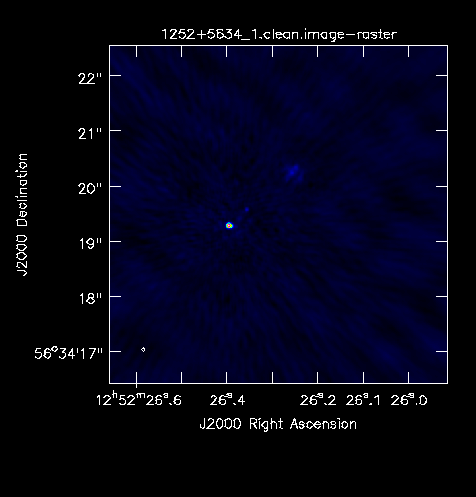

Show log 2018-01-23 11:31:55	SEVERE	MeasTable::dUTC(Double) (file /usr/local/casa/casacore/measures/Measures/MeasTable.cc, line 4396)	Leap second table TAI_UTC seems out-of-date. 
 2018-01-23 11:31:55	SEVERE	MeasTable::dUTC(Double) (file /usr/local/casa/casacore/measures/Measures/MeasTable.cc, line 4396)+	Until the table is updated (see the CASA documentation or your system admin),
 2018-01-23 11:31:55	SEVERE	MeasTable::dUTC(Double) (file /usr/local/casa/casacore/measures/Measures/MeasTable.cc, line 4396)+	times and coordinates derived from UTC could be wrong by 1s or more.

In [80]:
viewer(target+'_1.clean.image')

### View the model made by this image

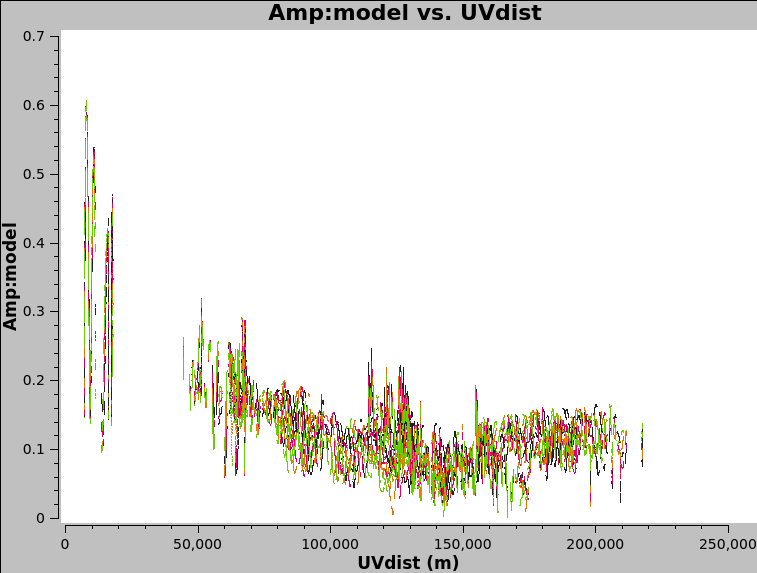

True

Show log 2018-01-23 11:32:00	INFO	PlotMS::params_changed	Updating: REDRAW, MSDATA, CACHE, AXES, CANVAS, DISPLAY, ITERATION, LOG, PLOTMS_OPTIONS.
 2018-01-23 11:32:00	INFO	PlotMS::load_cache	Clearing the existing plotms cache.
 2018-01-23 11:32:00	INFO	PlotMS::load_cache	Clearing the existing plotms cache.
 2018-01-23 11:32:00	INFO	PlotMS::params_changed	Updating: REDRAW, MSDATA, CACHE, AXES, CANVAS, DISPLAY, ITERATION, LOG, PLOTMS_OPTIONS.
 2018-01-23 11:32:00	INFO	PlotMS::load_cache	Clearing the existing plotms cache.
 2018-01-23 11:32:00	INFO	PlotMS::load_cache	START Current memory usage: 1670.34 kilobytes.
 2018-01-23 11:32:00	INFO	PlotMS::load_cache	Plot Data Transformations:
 2018-01-23 11:32:00	INFO	PlotMS::load_cache+ Frame = 
 2018-01-23 11:32:00	INFO	PlotMS::load_cache+ VelDef = RADIO
 2018-01-23 11:32:00	INFO	PlotMS::load_cache+ RestFreq = 0 MHz
 2018-01-23 11:32:00	INFO	PlotMS::load_cache+ dX = 0 arcsec
 2018-01-23 11:32:00	INFO	PlotMS::load_cache+ dY = 0 arcsec
 2018-01-23 11:32:00	INFO	PlotMS::load_cache+ formStokes = false
 2018-01-23 11:32:00	INFO	PlotMS::load_cache	Data Averaging: 
 2018-01-23 11:32:00	INFO	PlotMS::load_cache+ Using VECTOR averaging.
 2018-01-23 11:32:00	INFO	PlotMS::load_cache+ Channel: 64 channels
 2018-01-23 11:32:00	INFO	PlotMS::load_cache	Plot Data Calibration:
 2018-01-23 11:32:00	INFO	PlotMS::load_cache+ Use Calibration = 0
 2018-01-23 11:32:00	INFO	PlotMS::load_cache+ Calibration Library = 
 2018-01-23 11:32:00	INFO	PlotMS::load_cache	Caching for the new plot: Amp(17) vs. UVdist(28)...
 2018-01-23 11:32:04	INFO	PlotMS::load_cache	Data selection will yield a total of 481928 plottable points (flagged and unflagged).
 2018-01-23 11:32:04	INFO	PlotMS::load_cache+	The plotms cache will require an estimated 0.00854298 GB of memory (17.7267 bytes/point).
 2018-01-23 11:32:04	INFO	PlotMS::load_cache+	This is 15.1128% of the memory avail. to CASA (free=0.056528 GB).
 2018-01-23 11:32:04	INFO	PlotMS::load_cache	Loading chunks......
 2018-01-23 11:32:28	INFO	PlotMS::load_cache	SPW 0: number of channels averaged = 64
 2018-01-23 11:32:28	INFO	PlotMS::load_cache	SPW 1: number of channels averaged = 64
 2018-01-23 11:32:28	INFO	PlotMS::load_cache	SPW 2: number of channels averaged = 64
 2018-01-23 11:32:28	INFO	PlotMS::load_cache	SPW 3: number of channels averaged = 64
 2018-01-23 11:32:29	INFO	PlotMS::load_cache	Generating the plot mask.
 2018-01-23 11:32:29	INFO	PlotMS::load_cache	refTime = 2015/05/05/00:00:00.0
 2018-01-23 11:32:29	INFO	PlotMS::load_cache	Finished loading.
 2018-01-23 11:32:29	INFO	PlotMS::load_cache	Setting up iteration indexing (if necessary), and calculating plot ranges.
 2018-01-23 11:32:29	INFO	PlotMS::load_cache	Global ranges:
 2018-01-23 11:32:29	INFO	PlotMS::load_cache+	UVdist: 6878.97-217488 (unflagged); 1.79769e+308--1.79769e+308 (flagged).
 2018-01-23 11:32:29	INFO	PlotMS::load_cache+	Amp: 0.00243932-0.608288 (unflagged); 1.79769e+308--1.79769e+308(flagged).
 2018-01-23 11:32:29	INFO	PlotMS::plot	Plotting 481928 unflagged points.
 2018-01-23 11:32:00	INFO	PlotMS::load_cache	END Time: +29 seconds. Memory: +257289 kilobytes.
 2018-01-23 11:32:30	INFO	plotms::::	Plot file /home/jupyter/plotms_temp.png
 2018-01-23 11:32:31	INFO	plotms::::	Exporting the plot.
 2018-01-23 11:32:31	INFO	plotms::::	Calling pm.save
 2018-01-23 11:32:31	INFO	QPExporter::export	START Current memory usage: 258988 kilobytes.
 2018-01-23 11:32:31	INFO	QPExporter::export	END Time: +3 seconds. Memory: +47.1719 kilobytes.

In [81]:
plotms(vis=target+'.ms',
   xaxis='uvdist',
   yaxis='amp',
   ydatacolumn='model',
   correlation='RR,LL',
   avgchannel='64',
   coloraxis='spw')

Inspect phases against time to help decide solint. However, phase slopes are also due to source structure. Look at the shortest baseline (Mk2&Pi). Inadvisable to use a very short solint while model imperfect. Half a scan length seems OK.

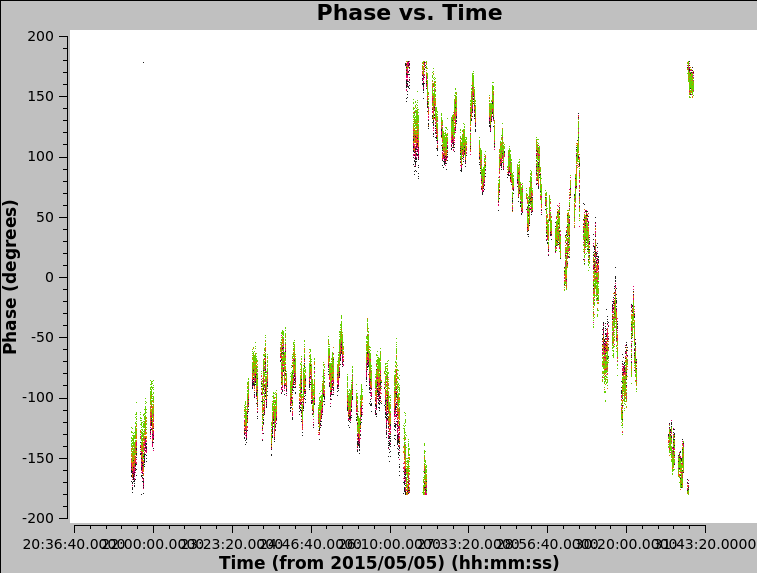

True

Show log 2018-01-23 11:33:00	INFO	PlotMS::params_changed	Updating: REDRAW, MSDATA, CACHE, AXES, CANVAS, DISPLAY, ITERATION, LOG, PLOTMS_OPTIONS.
 2018-01-23 11:33:00	INFO	PlotMS::load_cache	Clearing the existing plotms cache.
 2018-01-23 11:33:00	INFO	PlotMS::load_cache	START Current memory usage: 6773.05 kilobytes.
 2018-01-23 11:33:00	INFO	PlotMS::load_cache	Plot Data Transformations:
 2018-01-23 11:33:00	INFO	PlotMS::load_cache+ Frame = 
 2018-01-23 11:33:00	INFO	PlotMS::load_cache+ VelDef = RADIO
 2018-01-23 11:33:00	INFO	PlotMS::load_cache+ RestFreq = 0 MHz
 2018-01-23 11:33:00	INFO	PlotMS::load_cache+ dX = 0 arcsec
 2018-01-23 11:33:00	INFO	PlotMS::load_cache+ dY = 0 arcsec
 2018-01-23 11:33:00	INFO	PlotMS::load_cache+ formStokes = false
 2018-01-23 11:33:00	INFO	PlotMS::load_cache	Data Averaging: 
 2018-01-23 11:33:00	INFO	PlotMS::load_cache+ Using VECTOR averaging.
 2018-01-23 11:33:00	INFO	PlotMS::load_cache+ Channel: 64 channels
 2018-01-23 11:33:00	INFO	PlotMS::load_cache	Plot Data Calibration:
 2018-01-23 11:33:00	INFO	PlotMS::load_cache+ Use Calibration = 0
 2018-01-23 11:33:00	INFO	PlotMS::load_cache+ Calibration Library = 
 2018-01-23 11:33:00	INFO	PlotMS::load_cache	Caching for the new plot: Phase(18) vs. Time(2)...
 2018-01-23 11:33:05	INFO	PlotMS::load_cache	Data selection will yield a total of 33712 plottable points (flagged and unflagged).
 2018-01-23 11:33:05	INFO	PlotMS::load_cache+	The plotms cache will require an estimated 0.00121363 GB of memory (36 bytes/point).
 2018-01-23 11:33:05	INFO	PlotMS::load_cache+	This is 2.58% of the memory avail. to CASA (free=0.04704 GB).
 2018-01-23 11:33:05	INFO	PlotMS::load_cache	Loading chunks......
 2018-01-23 11:33:13	INFO	PlotMS::load_cache	SPW 0: number of channels averaged = 64
 2018-01-23 11:33:13	INFO	PlotMS::load_cache	SPW 1: number of channels averaged = 64
 2018-01-23 11:33:13	INFO	PlotMS::load_cache	SPW 2: number of channels averaged = 64
 2018-01-23 11:33:13	INFO	PlotMS::load_cache	SPW 3: number of channels averaged = 64
 2018-01-23 11:33:13	INFO	PlotMS::load_cache	Generating the plot mask.
 2018-01-23 11:33:13	INFO	PlotMS::load_cache	refTime = 2015/05/05/00:00:00.0
 2018-01-23 11:33:13	INFO	PlotMS::load_cache	Finished loading.
 2018-01-23 11:33:13	INFO	PlotMS::load_cache	Setting up iteration indexing (if necessary), and calculating plot ranges.
 2018-01-23 11:33:13	INFO	PlotMS::load_cache	Global ranges:
 2018-01-23 11:33:13	INFO	PlotMS::load_cache+	Time: 4.93758e+09-4.93761e+09 (unflagged); 1.79769e+308--1.79769e+308 (flagged).
 2018-01-23 11:33:13	INFO	PlotMS::load_cache+	Phase: -179.974-179.997 (unflagged); 1.79769e+308--1.79769e+308(flagged).
 2018-01-23 11:33:13	INFO	PlotMS::plot	Plotting 33712 unflagged points.
 2018-01-23 11:33:00	INFO	PlotMS::load_cache	END Time: +14 seconds. Memory: +239282 kilobytes.
 2018-01-23 11:33:13	INFO	plotms::::	Plot file /home/jupyter/plotms_temp.png
 2018-01-23 11:33:14	INFO	plotms::::	Exporting the plot.
 2018-01-23 11:33:14	INFO	plotms::::	Calling pm.save
 2018-01-23 11:33:14	INFO	QPExporter::export	START Current memory usage: 246068 kilobytes.
 2018-01-23 11:33:14	INFO	QPExporter::export	END Time: +0 seconds. Memory: +1.67188 kilobytes.

In [82]:
plotms(vis=target+'.ms',
   xaxis='time',
   yaxis='phase',
   antenna='Mk2&Pi',
   correlation='RR,LL',
   avgchannel='64',
   coloraxis='spw')

### First phase self-cal

In [83]:
gaincal(vis=target+'.ms',
    calmode='p',
    caltable=target+'.p1',
    field=target,
    solint='180s',
    refant=antref,
    minblperant=2,minsnr=2)

Show log 2018-01-23 11:33:32	INFO	gaincal::calibrater::open	Opening MS: 1252+5634.ms for calibration.
 2018-01-23 11:33:32	INFO	gaincal::Calibrater::	Initializing nominal selection to the whole MS.
 2018-01-23 11:33:33	INFO	gaincal::calibrater::setdata	Beginning selectvis--(MSSelection version)-------
 2018-01-23 11:33:33	INFO	gaincal::calibrater::reset	Reseting solve/apply state
 2018-01-23 11:33:33	INFO	gaincal::Calibrater::selectvis	Performing selection on MeasurementSet
 2018-01-23 11:33:33	INFO	gaincal::Calibrater::selectvis+ Selecting on field: '1252+5634'
 2018-01-23 11:33:33	INFO	gaincal::Calibrater::selectvis	Selection did not drop any rows
 2018-01-23 11:33:34	INFO	gaincal::Calibrater::selectvis	Frequency selection: Selecting all channels in all spws.
 2018-01-23 11:33:34	INFO	gaincal::calibrater::setdata	chanmode=none nchan=1 start=0 step=1 mStart='0km/s' mStep='0km/s' msSelect=''
 2018-01-23 11:33:34	INFO	gaincal::calibrater::setsolve	Beginning setsolve--(MSSelection version)-------
 2018-01-23 11:33:34	INFO	gaincal::Calibrater::setsolve	Arranging to SOLVE:
 2018-01-23 11:33:34	INFO	gaincal::Calibrater::setsolve	. G Jones: table=1252+5634.p1 append=false solint=180s refant='Mk2' minsnr=2 apmode=P solnorm=false
 2018-01-23 11:33:34	INFO	gaincal::calibrater::solve	Beginning solve-----------------------------
 2018-01-23 11:33:34	INFO	gaincal::Calibrater::solve	The following calibration terms are arranged for apply:
 2018-01-23 11:33:34	INFO	gaincal::Calibrater::solve	. (None)
 2018-01-23 11:33:34	INFO	gaincal::Calibrater::solve	The following calibration term is arranged for solve:
 2018-01-23 11:33:34	INFO	gaincal::Calibrater::solve	. G Jones: table=1252+5634.p1 append=false solint=180s refant='Mk2' minsnr=2 apmode=P solnorm=false
 2018-01-23 11:33:34	INFO	gaincal::Calibrater::solve	Solving for G Jones
 2018-01-23 11:33:34	INFO	gaincal::::	For solint = 180s, found 396 solution intervals.
 2018-01-23 11:33:55	INFO	gaincal::Calibrater::solve Found good G Jones solutions in 396 slots.
 2018-01-23 11:33:55	INFO	gaincal::::	Applying refant: Mk2
 2018-01-23 11:33:55	INFO	gaincal::::	Enforcing apmode on solutions.
 2018-01-23 11:33:56	INFO	gaincal::::	Writing solutions to table: 1252+5634.p1
 2018-01-23 11:33:58	INFO	gaincal::calibrater::solve	Finished solving.
 2018-01-23 11:33:58	INFO	gaincal::::	Calibration solve statistics per spw: (expected/attempted/succeeded):
 2018-01-23 11:33:58	INFO	gaincal:::: Spw 0: 99/99/99
 2018-01-23 11:33:58	INFO	gaincal:::: Spw 1: 99/99/99
 2018-01-23 11:33:58	INFO	gaincal:::: Spw 2: 99/99/99
 2018-01-23 11:33:58	INFO	gaincal:::: Spw 3: 99/99/99

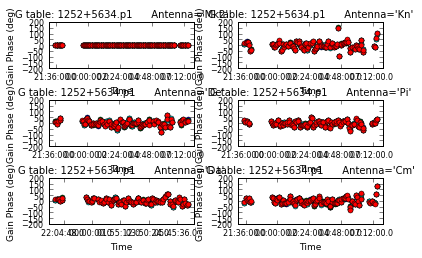

Show log 2018-01-23 11:38:02	INFO	plotcal::tableplot::setgui	Switching to GUI mode. All current plots will be reset.
 2018-01-23 11:38:07	INFO	plotcal::plotcal::createCalTab Detected a NewCalTable!
 2018-01-23 11:38:07	INFO	plotants::::	Now get the data
 2018-01-23 11:38:07	INFO	plotants::::	Done Processing data ... 
 2018-01-23 11:38:10	INFO	plotants::::	Now get the data
 2018-01-23 11:38:10	INFO	plotants::::	Done Processing data ... 
 2018-01-23 11:38:10	INFO	plotants::::	Now get the data
 2018-01-23 11:38:10	INFO	plotants::::	Done Processing data ... 
 2018-01-23 11:38:11	INFO	plotants::::	Now get the data
 2018-01-23 11:38:11	INFO	plotants::::	Done Processing data ... 
 2018-01-23 11:38:11	INFO	plotants::::	Now get the data
 2018-01-23 11:38:11	INFO	plotants::::	Done Processing data ... 
 2018-01-23 11:38:11	INFO	plotants::::	Now get the data
 2018-01-23 11:38:11	INFO	plotants::::	Done Processing data ...

In [84]:
# Plot solutions
plotcal(caltable=target+'.p1',xaxis='time',
    plotrange=[-1,-1,-180,180],
    iteration='antenna',yaxis='phase',subplot=321,
    poln='L',
    showgui=T)

## Apply phase solutions

In [85]:
applycal(vis=target+'.ms',
    gaintable=target+'.p1')

Show log 2018-01-23 11:38:16	INFO	applycal::calibrater::open	Opening MS: 1252+5634.ms for calibration.
 2018-01-23 11:38:16	INFO	applycal::VisSetUtil::addScrCols	Adding CORRECTED_DATA column(s).
 2018-01-23 11:38:21	INFO	applycal::Calibrater::	Initializing nominal selection to the whole MS.
 2018-01-23 11:38:21	INFO	applycal::AgentFlagger::open	Table type is Measurement Set
 2018-01-23 11:38:21	INFO	plotants::::	Creating new backup flag file called applycal_1
 2018-01-23 11:38:22	INFO	calibrater::setdata	Beginning selectvis--(MSSelection version)-------
 2018-01-23 11:38:22	INFO	calibrater::reset	Reseting solve/apply state
 2018-01-23 11:38:22	INFO	Calibrater::selectvis	Performing selection on MeasurementSet
 2018-01-23 11:38:22	INFO	Calibrater::selectvis	Selection did not drop any rows
 2018-01-23 11:38:22	INFO	Calibrater::selectvis	Frequency selection: Selecting all channels in all spws.
 2018-01-23 11:38:22	INFO	calibrater::setdata	chanmode=none nchan=1 start=0 step=1 mStart='0km/s' mStep='0km/s' msSelect=''
 2018-01-23 11:38:22	INFO	calibrater::setapply	Beginning setapply--(MSSelection version)-------
 2018-01-23 11:38:22	INFO	Calibrater::setapply(type, applypar)	Arranging to APPLY:
 2018-01-23 11:38:22	INFO	Calibrater::setapply(type, applypar)	. G Jones: table=1252+5634.p1 select= interp=linear spwmap=[-1] calWt=true
 2018-01-23 11:38:22	INFO	calibrater::correct	Beginning correct---------------------------
 2018-01-23 11:38:22	INFO	Calibrater::correct2 (VI2/VB2)	The following calibration terms are arranged for apply:
 2018-01-23 11:38:22	INFO	Calibrater::correct2 (VI2/VB2)	. G Jones: table=1252+5634.p1 select= interp=linear spwmap=[-1] calWt=true
 2018-01-23 11:38:29	INFO	calibrater::correct	Finished correcting.
 2018-01-23 11:38:30	INFO	applycal::::	Calibration apply flagging statistics (among calibrateable spws):
 2018-01-23 11:38:30	INFO	applycal:::: Total selected visibilities (among calibrateable spws) = 61686784
 2018-01-23 11:38:30	INFO	applycal:::: Flags:
 2018-01-23 11:38:30	INFO	applycal:::: G Jones: In: 7228982 (11.7188505078%) --> Out: 8315102 (13.4795517951%) (1252+5634.p1)
 2018-01-23 11:38:31	INFO	applycal::::	CASA Version 0.4.7 (REL r00)
 2018-01-23 11:38:31	INFO	applycal:::: Tagged on: 2017-02-20 15:48:56 UTC

## Clean phase self-calibrated image

In [87]:
clean(vis=target+'.ms',
    imagename=target+'_p1.clean',
    cell='0.012arcsec',
    niter=1000, # stop before this if residuals reach noise
    imsize=512,
    interactive=False)

Show log 2018-01-23 13:06:54	INFO	clean::::	nchan=-1 start=0 width=1
 2018-01-23 13:06:54	INFO	clean::::	Use default channelization for clean
 2018-01-23 13:06:54	INFO	clean::::	clean image: 1252+5634_p1.clean
 2018-01-23 13:06:54	INFO	clean::::	FTMachine used is ft 
 2018-01-23 13:06:54	INFO	imager::setDataOnThisMS()	Performing selection on MeasurementSet : /home/jupyter/1252+5634.ms
 2018-01-23 13:06:54	INFO	imager::setDataOnThisMS()	Selecting on fields : 0
 2018-01-23 13:06:54	INFO	imager::setDataOnThisMS()	Selecting on spectral windows expression :*
 2018-01-23 13:06:54	INFO	imager::setDataOnThisMS()	Selected all 240964 rows
 2018-01-23 13:06:54	INFO	imager::setDataOnThisMS()	Selected : [64 chans in spw 0] [64 chans in spw 1] [64 chans in spw 2] [64 chans in spw 3]
 2018-01-23 13:06:55	INFO	msmetadata_cmpt.cc::open	Performing internal consistency checks on 1252+5634.ms...
 2018-01-23 13:06:55	INFO	msmetadata_cmpt.cc::open	Performing internal consistency checks on 1252+5634.ms...
 2018-01-23 13:06:55	INFO	imager::defineimage()	Defining image properties:nx=512 ny=512 cellx='0.012arcsec' celly='0.012arcsec' stokes=I' mode=MFS nchan=-1 start=0 step=1 spwids=[-1] fieldid=-1 facets=1 frame=5 distance='0'
 2018-01-23 13:06:55	INFO	imager::defineimage() phaseCenter='12:52:26.29, 56.34.19.49, ' mStart='Radialvelocity: 0' qStep='0 '' mFreqStart='Frequency: 0
 2018-01-23 13:06:56	INFO	Imager::setvp() Setting voltage pattern parameters
 2018-01-23 13:06:56	INFO	Imager::setvp() Sky position tolerance is 180 degrees
 2018-01-23 13:06:56	INFO	Imager::setvp() Using system default voltage patterns for each telescope
 2018-01-23 13:06:56	INFO	imager::makeimage() Calculating image (without full skyequation)
 2018-01-23 13:06:57	WARN	imager::makeimage() (file /usr/local/casa/code/synthesis/MeasurementEquations/Imager.cc, line 2973)	The MS has multiple antenna diameters ..PB could be wrong 
 2018-01-23 13:06:58	INFO	Imager::setvp() Setting voltage pattern parameters
 2018-01-23 13:06:58	INFO	imager::weight()	Weighting MS: Imaging weights will be changed
 2018-01-23 13:06:58	INFO	imager::weight()	Natural weighting
 2018-01-23 13:06:58	INFO	clean::::	Used mask(s) : [''] to create mask image(s) : 1252+5634_p1.clean.mask
 2018-01-23 13:06:58	INFO	imager::setoptions() Setting processing options
 2018-01-23 13:06:58	INFO	clean::::	No model found. Making empty initial model : 1252+5634_p1.clean.model
 2018-01-23 13:06:59	INFO	Imager::imagecoordinates() Center frequency = 5.07209 GHz, synthesized continuum bandwidth = 0.512013 GHz
 2018-01-23 13:07:00	INFO	imager::clean()	Using multifield Clark clean
 2018-01-23 13:07:00	INFO	imager::createFTMachine() Multiple fields or facets: transforms will be padded by a factor 1.2
 2018-01-23 13:07:00	INFO	imager::createFTMachine() Performing interferometric gridding...
 2018-01-23 13:07:00	INFO	imager::clean()	Clean gain = 0.1, Niter = 1000, Threshold = 0 mJy
 2018-01-23 13:07:00	INFO	imager::clean()	Starting deconvolution
 2018-01-23 13:07:08	INFO	ImageSkyModel::makeApproxPSFs	bmaj: 0.0648986", bmin: 0.0532424", bpa: 8.9424 deg
 2018-01-23 13:07:08	INFO	MFCleanImageSkyModel::solve	*** Starting major cycle 0
 2018-01-23 13:07:17	INFO	MFCleanImageSkyModel::solve	The minor-cycle threshold is MAX[ 0.95 x 0 , peak residual x 0.437922 ] 
 2018-01-23 13:07:17	INFO	MFCleanImageSkyModel::solve	Maximum residual = 0.183245, cleaning down to 0.0802468
 2018-01-23 13:07:17	INFO	MFCleanImageSkyModel::solve	Processing model 0
 2018-01-23 13:07:17	INFO	ClarkCleanModel::singleSolve	Initial maximum residual: 0.183245
 2018-01-23 13:07:17	INFO	MFCleanImageSkyModel::solve	Finished Clark clean inner cycle 
 2018-01-23 13:07:17	INFO	MFCleanImageSkyModel::solve	Clean used 11 iterations to approach a threshhold of 0.0802468
 2018-01-23 13:07:17	INFO	MFCleanImageSkyModel::solve	0.134619 Jy <- cleaned in this cycle for model 0 (Total flux : 0.134619Jy)
 2018-01-23 13:07:17	INFO	MFCleanImageSkyModel::solve	*** Starting major cycle 1
 201

In [88]:
rmsp1=imstat(imagename=target+'_p1.clean.image',
              box='10,400,199,499')['rms'][0]
peakp1=imstat(imagename=target+'_p1.clean.image',
              box='10,10,499,499')['max'][0]

print target+'_p1.clean.image rms %7.3f mJy' % (rmsp1*1000.)
print target+'_p1.clean.image peak %7.3f mJy/bm' % (peakp1*1000.)

1252+5634_p1.clean.image rms   0.428 mJy
1252+5634_p1.clean.image peak 158.641 mJy/bm


Show log 2018-01-23 13:09:08	INFO	imstat::CasacRegionManager::fromBCS	Using specified box(es) 10,400,199,499
 2018-01-23 13:09:08	INFO	imstat::image::statistics Determining stats for image 1252+5634_p1.clean.image
 2018-01-23 13:09:08	INFO	imstat::ImageRegion::fromRecord	Selected bounding box : 
 2018-01-23 13:09:08	INFO	imstat::ImageRegion::fromRecord+ [10, 400, 0, 0] to [199, 499, 0, 0] (12:52:26.643, +56.34.21.216, I, 5.072e+09Hz to 12:52:26.369, +56.34.22.404, I, 5.072e+09Hz)
 2018-01-23 13:09:08	INFO	imstat::ImageStatsCalculator::statistics	Statistics calculated using Classic algorithm
 2018-01-23 13:09:08	INFO	imstat::ImageStatsCalculator::statistics	Regions --- 
 2018-01-23 13:09:08	INFO	imstat::ImageStatsCalculator::statistics -- bottom-left corner (pixel) [blc]: [10, 400, 0, 0]
 2018-01-23 13:09:08	INFO	imstat::ImageStatsCalculator::statistics -- top-right corner (pixel) [trc]: [199, 499, 0, 0]
 2018-01-23 13:09:08	INFO	imstat::ImageStatsCalculator::statistics -- bottom-left corner (world) [blcf]: 12:52:26.6431, +56.34.21.2160, I, 5.072e+09Hz
 2018-01-23 13:09:08	INFO	imstat::ImageStatsCalculator::statistics -- top-right corner (world) [trcf]: 12:52:26.3687, +56.34.22.4040, I, 5.072e+09Hz
 2018-01-23 13:09:08	INFO	imstat::ImageStatsCalculator::statistics	Computing quantiles...
 2018-01-23 13:09:09	INFO	imstat::::	Values --- 
 2018-01-23 13:09:09	INFO	imstat:::: -- flux density [flux]: 0.0707853 Jy
 2018-01-23 13:09:09	INFO	imstat:::: -- number of points [npts]: 19000
 2018-01-23 13:09:09	INFO	imstat:::: -- maximum value [max]: 0.00147618 Jy/beam
 2018-01-23 13:09:09	INFO	imstat:::: -- minimum value [min]: -0.00093545 Jy/beam
 2018-01-23 13:09:09	INFO	imstat:::: -- position of max value (pixel) [maxpos]: [115, 424, 0, 0]
 2018-01-23 13:09:09	INFO	imstat:::: -- position of min value (pixel) [minpos]: [111, 464, 0, 0]
 2018-01-23 13:09:09	INFO	imstat:::: -- position of max value (world) [maxposf]: 12:52:26.4907, +56.34.21.5040, I, 5.072e+09Hz
 2018-01-23 13:09:09	INFO	imstat:::: -- position of min value (world) [minposf]: 12:52:26.4965, +56.34.21.9840, I, 5.072e+09Hz
 2018-01-23 13:09:09	INFO	imstat:::: -- Sum of pixel values [sum]: 1.92459 Jy/beam
 2018-01-23 13:09:09	INFO	imstat:::: -- Sum of squared pixel values [sumsq]: 0.00348753 Jy/beam.Jy/beam
 2018-01-23 13:09:09	INFO	imstat::::	Statistics --- 
 2018-01-23 13:09:09	INFO	imstat:::: -- Mean of the pixel values [mean]: 0.000101294 Jy/beam
 2018-01-23 13:09:09	INFO	imstat:::: -- Variance of the pixel values : 1.73303e-07 Jy/beam
 2018-01-23 13:09:09	INFO	imstat:::: -- Standard deviation of the Mean [sigma]: 0.000416296 Jy/beam
 2018-01-23 13:09:09	INFO	imstat:::: -- Root mean square [rms]: 0.000428432 Jy/beam
 2018-01-23 13:09:09	INFO	imstat:::: -- Median of the pixel values [median]: 5.30031e-05 Jy/beam
 2018-01-23 13:09:09	INFO	imstat:::: -- Median of the deviations [medabsdevmed]: 0.00029179 Jy/beam
 2018-01-23 13:09:09	INFO	imstat:::: -- IQR [quartile]: 0.000602205 Jy/beam
 2018-01-23 13:09:09	INFO	imstat:::: -- First quartile [q1]: -0.000212479 Jy/beam
 2018-01-23 13:09:09	INFO	imstat:::: -- Third quartile [q3]: 0.000389726 Jy/beam
 2018-01-23 13:09:09	INFO	imstat::::	Created Temp image of shape [1, 1, 1, 1] with float valued pixels.
 2018-01-23 13:09:09	INFO	imstat::ImageStatsCalculator::statistics	Sum column unit = Jy/beam
 2018-01-23 13:09:09	INFO	imstat::ImageStatsCalculator::statistics+	Mean column unit = Jy/beam
 2018-01-23 13:09:09	INFO	imstat::ImageStatsCalculator::statistics+	Std_dev column unit = Jy/beam
 2018-01-23 13:09:09	INFO	imstat::ImageStatsCalculator::statistics+	Minimum column unit = Jy/beam
 2018-01-23 13:09:09	INFO	imstat::ImageStatsCalculator::statistics+	Maximum column unit = Jy/beam
 2018-01-23 13:09:09	INFO	imstat::ImageStatsCalculator::statistics	Sum column unit = Jy/beam
 2018-01-23 13:09:09	INFO	imstat::ImageStatsCalculator::statistics+	Mean column unit = Jy/beam
 2018-01-23 13:09:09	INFO	imstat::ImageStatsCalculator::statistics+	Std_

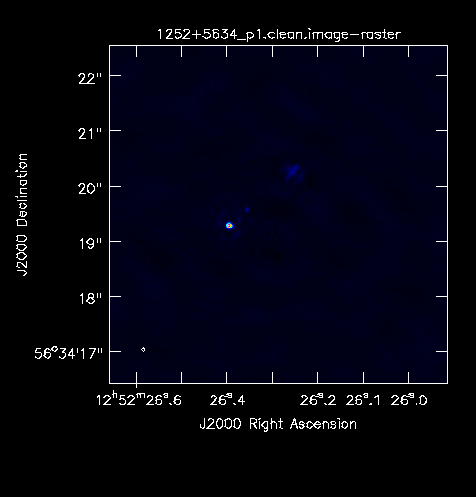

In [89]:
viewer(target+'_p1.clean.image')